# LLM-Augmented Audio-Visual Lip-Sync Deepfake Detection
## Pilot Notebook (Design & Planning)

---

## Step 1: Pilot Dataset Selection
- Goal: Assemble a pilot list of 20–50 clips (train/val).
- Deliverable: Table with dataset names, real/fake counts, purpose.

---

## Step 2: Preprocessing Policy
- Face detector choice
- Lip ROI size
- FPS standardization
- Crop stability rules

---

## Step 3: Feature Plan
- SyncNet scores
- AV-HuBERT embeddings
- Whisper transcripts
- MFA alignment outputs

---

## Step 4: LLM Scoring Specification
- Prompt templates
- Output fields
- Decision rubric

---

## Step 5: Fusion & Evaluation Metrics
- Feature fusion approach
- Metrics: AUC, EER
- IoU for temporal localization

---

## Step 6: Error Taxonomy
- Desync types
- Dubbing artifacts
- Rhythm anomalies

---

## Step 7: Privacy & Ethics Note
- Face/voice handling
- Storage policy
- Sharing constraints

---

## Step 8: Minimal Demo Checklist
- What constitutes a successful first pipeline run
- Evidence to capture


### Pilot Dataset Selection (Step 1)

**Goal:** Assemble a pilot list of 20–50 clips (train/val) covering all datasets.

| Dataset        | Real Clips | Fake Clips | Total | Purpose (train/val) |
|----------------|------------|------------|-------|----------------------|
| FakeAVCeleb    | 5          | 5          | 10    | Training |
| AV-Deepfake1M  | 5          | 5          | 10    | Validation |
| LAV-DF         | 3          | 3          | 6     | Training (temporal loc) |
| AVLips         | 3          | 3          | 6     | Stress-test |
| LRS2 / LRS3    | 4          | –          | 4     | Pretraining/finetuning (real only) |
| **Total**      | 20         | 16         | 36    | --- |

**Notes:**  
- Core training/validation clips: FakeAVCeleb & AV-Deepfake1M  
- Temporal and stress-test clips: LAV-DF & AVLips  
- Real-only clips for VSR pretraining: LRS2 / LRS3  
- This pilot set is small enough to test the pipeline quickly but representative of all datasets.

Total pilot clips = 36, which is within the recommended 20–50 range for quick testing.

### Preprocessing Policy (Step 2)

**Goal:** Prepare video clips for consistent feature extraction.

1. **Face detector:**  
   - Use **RetinaFace** for accurate face and landmark detection.  
   - Alternative for pilot: OpenCV Haar cascade for fast checks.

2. **Lip ROI size:**  
   - Crop mouth region including small margin.  
   - Resize to **128x128 pixels** for model input.  
   - Maintain aspect ratio if possible.

3. **FPS standardization:**  
   - Convert all clips to **25 FPS**.  
   - Ensures consistent temporal resolution across datasets.

4. **Crop stability rules:**  
   - Center crop on lips using landmarks for each frame.  
   - Smooth bounding box positions across frames to avoid jitter.  
   - Skip frames with occluded faces or very small bounding boxes.

   Consistent preprocessing ensures reliable feature extraction across all clips.


### Feature Plan (Step 3)

**Goal:** Define features to extract from each pilot clip.

1. **SyncNet Scores (Audio-Visual Sync):**  
   - Compute per-frame sync score between audio and lip movements.  
   - Helps detect misaligned lip-sync forgeries.

2. **AV-HuBERT Embeddings / Lip-Reading Features:**  
   - Extract visual speech embeddings from cropped lip region.  
   - Frame-level embeddings for temporal modeling.  
   - Optional: generate lip-reading transcripts.

3. **Whisper Transcripts (Audio ASR):**  
   - Convert audio to text using Whisper.  
   - Provides textual content for LLM scoring and semantic comparison.

4. **Montreal Forced Aligner (MFA) Alignment Outputs:**  
   - Align phonemes with audio timestamps.  
   - Compare phoneme timing with visual visemes to detect desync.

**Notes:**  
- These features will be **combined in later stages** for classifier input.  
- SyncNet + AV-HuBERT → core A/V features  
- Whisper + MFA → textual/phoneme timing features

All features will be saved as numpy arrays (.npy) for easy loading into the classifier.

### LLM Scoring Specification (Step 4)

**Goal:** Use LLM to evaluate semantic and prosody consistency.

1. **Prompt Templates:**  
   - Ask LLM to rate plausibility of spoken content based on Whisper transcripts and optional AV-HuBERT lip-reading transcripts.  
   - Example prompt:  
     ```
     Given the transcript and lip-reading content, rate how plausible the speech is:
     Transcript: <Whisper transcript>
     Lip-reading text (optional): <AV-HuBERT transcript>
     Rate consistency from 0 (fake) to 1 (real).
     ```

2. **Output Fields:**  
   - **Score**: numeric value 0–1  
   - **Optional reasoning text** for explainability  

3. **Decision Rubric:**  
   - Score > 0.7 → likely real  
   - Score < 0.3 → likely fake  
   - Score 0.3–0.7 → uncertain, combine with SyncNet/AV-HuBERT for final decision

Example: Score = 0.8 → likely real; Score = 0.2 → likely fake.

### Fusion & Evaluation Metrics (Step 5)

**Goal:** Combine features and define performance metrics.

1. **Feature Fusion Approach:**  
   - Concatenate SyncNet scores, AV-HuBERT embeddings, phoneme/text alignment features, and LLM score.  
   - Feed combined feature vector into a light classifier (e.g., XGBoost or LightGBM).  
   - Alternative: weighted combination or late fusion of separate predictions.

2. **Evaluation Metrics:**  
   - **Video-level:**  
     - AUC (Area Under ROC Curve)  
     - EER (Equal Error Rate)  
   - **Segment/frame-level (temporal localization):**  
     - IoU (Intersection over Union) between predicted fake segments and ground truth

**Notes:**  
- Video-level metrics check overall detection performance.  
- IoU is used only on datasets with **per-frame ground truth** (like LAV-DF and AVLips).  
- Fusion strategy ensures all features contribute to final real/fake decision.

Segment-level IoU will be calculated for datasets with per-frame annotations (LAV-DF, AVLips).

### Error Taxonomy (Step 6)

**Goal:** Categorize types of errors or anomalies in lip-sync deepfakes.

1. **Desynchronization Errors:**  
   - Lip movements do not match audio (delays, misaligned phonemes/visemes).

2. **Dubbing / Overlay Artifacts:**  
   - Audio replaced or edited independently (background noise mismatch, re-recorded speech).

3. **Rhythm / Prosody Anomalies:**  
   - Timing, pitch, or intonation inconsistent with natural speech.

4. **Visual Artifacts (Optional for Pilot):**  
   - Blurry or jittery lips, occlusions (hand, microphone, hair), sudden head movement.

**Notes:**  
- This taxonomy will guide **analysis of model failures**.  
- Helps in refining preprocessing, features, or LLM prompts if errors are frequent.

| Error Type        | Example Description                    |
| ----------------- | -------------------------------------- |
| Desynchronization | Phonemes not aligned with visemes      |
| Dubbing Artifact  | Re-recorded speech over original video |
| Rhythm / Prosody  | Flat or unnatural timing               |



### Privacy & Ethics Note (Step 7)

**Goal:** Ensure responsible handling of face and voice data.

1. **Face / Voice Handling:**  
   - Use data only for research and model development.  
   - Avoid storing unnecessary personal information.  
   - Crop faces/lips to minimize identity exposure.

2. **Storage Policy:**  
   - Store videos, cropped faces, and features in secure, restricted drives.  
   - Limit access to team members.  
   - Encrypt or anonymize data where possible.

3. **Sharing Constraints:**  
   - Do not publicly share raw videos with real people.  
   - Share only derived features (embeddings, SyncNet scores) if needed.  
   - Comply with dataset licenses (FakeAVCeleb, LAV-DF, etc.).

   All datasets (FakeAVCeleb, LAV-DF, etc.) will be used in accordance with their respective licenses.


### Minimal Demo Checklist (Step 8)

**Goal:** Define success criteria for the first pilot pipeline run and ensure all steps produce verifiable outputs.

1. **Successful Pipeline Run:**  
   - Detect and crop face/lips correctly for all pilot clips.  
   - Extract all planned features:  
     - SyncNet scores  
     - AV-HuBERT embeddings  
     - Whisper transcripts  
     - MFA alignment outputs  
   - Generate LLM score for semantic/prosody plausibility.  
   - Fuse features and output video-level and segment-level predictions (real/fake).

2. **Evidence to Capture:**  
   - Save sample cropped lip frames for verification of preprocessing.  
   - Export feature vectors for a few clips to check feature extraction.  
   - Record video-level predictions for each clip.  
   - Optional: visualize SyncNet scores or per-frame predictions to inspect results.  

3. **Notes:**  
   - This checklist ensures the pipeline runs successfully on the pilot dataset.  
   - All steps—from face/lip detection, feature extraction, LLM scoring, to fusion and predictions—should produce outputs.  
   - Evidence captured (frames, features, predictions) will serve as proof for debugging and verification.  
   - Optional: include a small flowchart showing the pipeline (Preprocessing → Feature Extraction → LLM → Fusion → Prediction) for clarity.


# Audio-Visual Deepfake Datasets

| Dataset Name            | Link / Reference                  | Number of Clips | Type (Real/Fake)            | Notes |
|-------------------------|---------------------------------|----------------|-----------------------------|-------|
| FakeAVCeleb             | [Google Sites+1](https://sites.google.com/view/fakeavcelebdash-lab/?utm_source=chatgpt.com) | Info not specified | Real & Fake                | Classic audio+video deepfake set with accurate lip-sync; great for training/validation |
| AV-Deepfake1M / 1M++    | [arXiv+2Hugging Face+2](https://arxiv.org/abs/2311.15308?utm_source=chatgpt.com) | Large-scale      | Real & Fake                | Content-driven A/V manipulations; ++ adds more data & real-world perturbations; use for cross-dataset generalization |
| LAV-DF                  | [GitHub+1](https://github.com/ControlNet/LAV-DF?utm_source=chatgpt.com) | Info not specified | Real & Fake                | Designed for temporal forgery localization; evaluate per-segment predictions |
| AVLips                  | [arXiv+1](https://arxiv.org/abs/2401.15668?utm_source=chatgpt.com) | Info not specified | Real & Fake                | Lip-sync set spotlighting temporal inconsistency; good stress-test |
| LRS2 / LRS3             | [Oxford Robotics Institute+1](https://www.robots.ox.ac.uk/%7Evgg/data/lip_reading/lrs2.html?utm_source=chatgpt.com) | Large-scale      | Real (not deepfakes)      | Clean lip-reading corpora; use to pretrain/finetune VSR components |


# Baseline AV Models & Pretrained LLMs

## A. Audio-Visual (AV) Models

| Model Name   | Purpose                          | Pretrained? | Link | Notes |
|-------------|---------------------------------|------------|------|-------|
| SyncNet     | Audio-Visual sync scoring        | Yes        | [Paper](https://arxiv.org/abs/1709.04366) | Computes lip-sync scores between audio and video |
| AV-HuBERT   | VSR embeddings / lip-reading     | Yes        | [GitHub](https://github.com/facebookresearch/av_hubert) | Extracts viseme features and transcripts from video |

*Optional models for reference:*
| Wav2Lip     | Lip-sync generation baseline     | Yes        | [GitHub](https://github.com/Rudrabha/Wav2Lip) | Can generate lip movements from audio; useful for stress-testing pipeline |

---

## B. Pretrained LLMs

| LLM Name           | Purpose                          | Size     | Pretrained? | Link | Notes |
|-------------------|---------------------------------|---------|------------|------|-------|
| Local 7–8B Instruct | Semantic / prosody scoring      | 7–8B    | Yes        | [Repo/Link] | Runs locally; evaluates transcript plausibility vs audio |
| LLaMA 7B           | Optional semantic scoring       | 7B      | Yes        | [Hugging Face](https://huggingface.co/models?search=llama) | Instruction-tuned; local inference possible |
| GPT-4 / GPT-3.5    | Optional cloud API scoring      | 175B    | Yes        | [OpenAI](https://platform.openai.com/) | Cloud API; can score semantic/prosody alignment |


# DAY-2 LLM/NLP Subteam Documentation

## 1️⃣ Shortlist of Pre-trained LLMs

| LLM Name           | Size   | Pretrained? | Link | Notes |
|-------------------|--------|------------|------|-------|
| Local 7–8B Instruct | 7–8B  | Yes        | [Link] | Can run locally; scores transcript + visual cues for consistency |
| LLaMA 7B           | 7B     | Yes        | [Hugging Face](https://huggingface.co/models?search=llama) | Instruction-tuned; can process text prompts locally |
| GPT-4 / GPT-3.5    | 175B   | Yes        | [OpenAI](https://platform.openai.com/) | Cloud API; can be used for semantic/prosody alignment checks |

---

## 2️⃣ Basic LLM Integration Pipeline

**Goal:** Use LLM to check **text + visual cue consistency** as a post-processing step for AV deepfake detection.

**Pipeline Steps:**
1. **Input preparation**  
   - Extract transcripts using ASR (e.g., Whisper)  
   - Optionally include **visual cue descriptions** from VSR model (e.g., AV-HuBERT embeddings or lip motion features)

2. **LLM processing**  
   - Prompt the LLM to evaluate semantic/prosody plausibility  
   - Example prompt:  
     ```
     Given the transcript and visual cues, rate the plausibility of lip-sync and natural speech rhythm on a scale of 0–1.
     ```

3. **Output handling**  
   - LLM returns a **consistency score**  
   - Score can be passed to a **light classifier** along with AV sync features

4. **Integration with final decision**  
   - Fuse LLM score with **SyncNet / AV-HuBERT features**  
   - Compute final **real/fake label** and (optionally) temporal localization

**Notes:**  
- This step is purely **text/documentation** now — no coding required until datasets are available.  
- Keep prompts and scoring rubric flexible for later experiments.


In [ ]:
import os

# Path to your dataset root
dataset_root = r"E:\Publications\Paper 6\Datasets\New folder\LAV-DF\LAV-DF"

# Dictionary to store video files by split
video_files = {}

for split in ["train", "dev", "test"]:
    split_path = os.path.join(dataset_root, split)
    if os.path.exists(split_path):
        files = [f for f in os.listdir(split_path) if f.endswith(".mp4")]
        video_files[split] = files
        print(f"{split.upper()} videos: {len(files)} files found")
        print(f"First 5 videos in {split}: {files[:5]}")
    else:
        print(f"⚠️ {split} folder not found!")


TRAIN videos: 56776 files found
First 5 videos in train: ['000469.mp4', '000470.mp4', '000471.mp4', '000472.mp4', '000473.mp4']
DEV videos: 31501 files found
First 5 videos in dev: ['004053.mp4', '004054.mp4', '004055.mp4', '004056.mp4', '004057.mp4']
TEST videos: 26100 files found
First 5 videos in test: ['000000.mp4', '000001.mp4', '000002.mp4', '000003.mp4', '000004.mp4']


In [ ]:
import os

# Base path to save preprocessed data
preprocessed_base = r"E:\Publications\Paper 6\Datasets\Preprocessed"

# Create folders for each split and for faces/audio
for split in ["train", "dev", "test"]:
    faces_dir = os.path.join(preprocessed_base, split, "faces")
    audio_dir = os.path.join(preprocessed_base, split, "audio")
    os.makedirs(faces_dir, exist_ok=True)
    os.makedirs(audio_dir, exist_ok=True)
    print(f"✅ Created folders for {split}:")
    print(f"   Faces: {faces_dir}")
    print(f"   Audio: {audio_dir}")


✅ Created folders for train:
   Faces: E:\Publications\Paper 6\Datasets\Preprocessed\train\faces
   Audio: E:\Publications\Paper 6\Datasets\Preprocessed\train\audio
✅ Created folders for dev:
   Faces: E:\Publications\Paper 6\Datasets\Preprocessed\dev\faces
   Audio: E:\Publications\Paper 6\Datasets\Preprocessed\dev\audio
✅ Created folders for test:
   Faces: E:\Publications\Paper 6\Datasets\Preprocessed\test\faces
   Audio: E:\Publications\Paper 6\Datasets\Preprocessed\test\audio


In [ ]:
!pip install opencv-python mediapipe


  Using cached protobuf-4.25.8-cp310-abi3-win_amd64.whl.metadata (541 bytes)
Using cached protobuf-4.25.8-cp310-abi3-win_amd64.whl (413 kB)
  Attempting uninstall: protobuf
    Found existing installation: protobuf 6.33.0
    Uninstalling protobuf-6.33.0:
      Successfully uninstalled protobuf-6.33.0


  You can safely remove it manually.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.20.0 requires protobuf>=5.28.0, but you have protobuf 4.25.8 which is incompatible.


In [ ]:
import cv2
import mediapipe as mp

# Mediapipe face detection
mp_face = mp.solutions.face_detection
mp_drawing = mp.solutions.drawing_utils

# Number of frames to extract per video (adjustable)
frames_per_video = 10

for split in ["train", "dev", "test"]:
    split_path = os.path.join(dataset_root, split)
    faces_dir = os.path.join(preprocessed_base, split, "faces")

    video_files = [f for f in os.listdir(split_path) if f.endswith(".mp4")]

    print(f"\nProcessing {split.upper()} videos: {len(video_files)} found")

    with mp_face.FaceDetection(model_selection=0, min_detection_confidence=0.5) as face_detector:
        for vid_file in video_files[:5]:  # For now, just process first 5 videos as test
            video_path = os.path.join(split_path, vid_file)
            try:
                cap = cv2.VideoCapture(video_path)
                frame_count = 0
                saved_count = 0
                while frame_count < frames_per_video:
                    ret, frame = cap.read()
                    if not ret:
                        break
                    # Convert to RGB for mediapipe
                    rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                    results = face_detector.process(rgb_frame)

                    if results.detections:
                        for i, detection in enumerate(results.detections):
                            bboxC = detection.location_data.relative_bounding_box
                            ih, iw, _ = frame.shape
                            x = int(bboxC.xmin * iw)
                            y = int(bboxC.ymin * ih)
                            w = int(bboxC.width * iw)
                            h = int(bboxC.height * ih)
                            face_crop = frame[y:y+h, x:x+w]

                            face_filename = f"{vid_file.replace('.mp4','')}_frame{frame_count}.jpg"
                            cv2.imwrite(os.path.join(faces_dir, face_filename), face_crop)
                            saved_count += 1
                    frame_count += 1
                cap.release()
                print(f"✅ Processed {vid_file}: {saved_count} face crops saved")
            except Exception as e:
                print(f"⚠️ Skipping {vid_file} due to error: {e}")



Processing TRAIN videos: 56776 found
⚠️ Skipping 000469.mp4 due to error: 'SymbolDatabase' object has no attribute 'GetPrototype'
⚠️ Skipping 000470.mp4 due to error: 'SymbolDatabase' object has no attribute 'GetPrototype'
⚠️ Skipping 000471.mp4 due to error: 'SymbolDatabase' object has no attribute 'GetPrototype'
⚠️ Skipping 000472.mp4 due to error: 'SymbolDatabase' object has no attribute 'GetPrototype'
⚠️ Skipping 000473.mp4 due to error: 'SymbolDatabase' object has no attribute 'GetPrototype'

Processing DEV videos: 31501 found
⚠️ Skipping 004053.mp4 due to error: 'SymbolDatabase' object has no attribute 'GetPrototype'
⚠️ Skipping 004054.mp4 due to error: 'SymbolDatabase' object has no attribute 'GetPrototype'
⚠️ Skipping 004055.mp4 due to error: 'SymbolDatabase' object has no attribute 'GetPrototype'
⚠️ Skipping 004056.mp4 due to error: 'SymbolDatabase' object has no attribute 'GetPrototype'
⚠️ Skipping 004057.mp4 due to error: 'SymbolDatabase' object has no attribute 'GetPrototy

In [ ]:
!pip install librosa soundfile


In [ ]:
!pip install moviepy --upgrade


In [ ]:
import sys
!{sys.executable} -m pip install moviepy


In [ ]:
import sys
print(sys.executable)


C:\Users\HP\anaconda3\envs\colab-local\python.exe


In [ ]:
import os

# Root folder where your extracted videos are
dataset_root = r"E:\Publications\Paper 6\Datasets\New folder\LAV-DF\LAV-DF"

# Base folder where preprocessed faces/audio will be saved
preprocessed_base = r"E:\Publications\Paper 6\Datasets\Preprocessed"

# Make sure preprocessed audio folders exist
for split in ["train", "dev", "test"]:
    audio_dir = os.path.join(preprocessed_base, split, "audio")
    os.makedirs(audio_dir, exist_ok=True)


In [ ]:
import os
import subprocess
import librosa
import numpy as np

# Full path to ffmpeg executable
ffmpeg_path = r"C:\Users\HP\Downloads\ffmpeg-8.0-full_build\bin\ffmpeg.exe"

# Loop through each split
for split in ["train", "dev", "test"]:
    split_path = os.path.join(dataset_root, split)
    audio_dir = os.path.join(preprocessed_base, split, "audio")

    video_files = [f for f in os.listdir(split_path) if f.endswith(".mp4")]

    print(f"\nProcessing {split.upper()} videos for audio: {len(video_files)} found")

    for idx, vid_file in enumerate(video_files[:5]):  # first 5 videos per split for testing
        video_path = os.path.join(split_path, vid_file)
        temp_wav = os.path.join(audio_dir, "temp.wav")
        try:
            # Extract audio to WAV using full ffmpeg path
            cmd = f'"{ffmpeg_path}" -y -i "{video_path}" -vn -ac 1 -ar 22050 "{temp_wav}"'
            subprocess.run(cmd, shell=True, stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)

            # Load audio and compute MFCC
            y, sr = librosa.load(temp_wav, sr=22050)
            mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)

            # Save MFCC as .npy
            audio_out_path = os.path.join(audio_dir, vid_file.replace(".mp4", ".npy"))
            np.save(audio_out_path, mfcc)

            print(f"✅ {vid_file}: MFCC shape {mfcc.shape} saved")

            # Remove temporary WAV
            os.remove(temp_wav)
        except Exception as e:
            print(f"⚠️ Skipping {vid_file} due to error: {e}")



Processing TRAIN videos for audio: 56776 found
✅ 000469.mp4: MFCC shape (13, 218) saved
✅ 000470.mp4: MFCC shape (13, 254) saved
✅ 000471.mp4: MFCC shape (13, 224) saved
✅ 000472.mp4: MFCC shape (13, 260) saved
✅ 000473.mp4: MFCC shape (13, 177) saved

Processing DEV videos for audio: 31501 found
✅ 004053.mp4: MFCC shape (13, 328) saved
✅ 004054.mp4: MFCC shape (13, 342) saved
✅ 004055.mp4: MFCC shape (13, 334) saved
✅ 004056.mp4: MFCC shape (13, 340) saved
✅ 004057.mp4: MFCC shape (13, 249) saved

Processing TEST videos for audio: 26100 found
✅ 000000.mp4: MFCC shape (13, 199) saved
✅ 000001.mp4: MFCC shape (13, 180) saved
✅ 000002.mp4: MFCC shape (13, 204) saved
✅ 000003.mp4: MFCC shape (13, 185) saved
✅ 000004.mp4: MFCC shape (13, 202) saved


In [ ]:
import os
import subprocess
import librosa
import numpy as np

# Full path to ffmpeg executable
ffmpeg_path = r"C:\Users\HP\Downloads\ffmpeg-8.0-full_build\bin\ffmpeg.exe"

# Loop through each split
for split in ["train", "dev", "test"]:
    split_path = os.path.join(dataset_root, split)
    audio_dir = os.path.join(preprocessed_base, split, "audio")

    video_files = [f for f in os.listdir(split_path) if f.endswith(".mp4")]

    print(f"\nProcessing {split.upper()} videos for audio: {len(video_files)} found")

    for idx, vid_file in enumerate(video_files):  # <-- all videos
        video_path = os.path.join(split_path, vid_file)
        temp_wav = os.path.join(audio_dir, "temp.wav")
        try:
            # Extract audio to WAV using full ffmpeg path
            cmd = f'"{ffmpeg_path}" -y -i "{video_path}" -vn -ac 1 -ar 22050 "{temp_wav}"'
            subprocess.run(cmd, shell=True, stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)

            # Load audio and compute MFCC
            y, sr = librosa.load(temp_wav, sr=22050)
            mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)

            # Save MFCC as .npy
            audio_out_path = os.path.join(audio_dir, vid_file.replace(".mp4", ".npy"))
            np.save(audio_out_path, mfcc)

            print(f"✅ {vid_file}: MFCC shape {mfcc.shape} saved")

            # Remove temporary WAV
            os.remove(temp_wav)
        except Exception as e:
            print(f"⚠️ Skipping {vid_file} due to error: {e}")


Streaming output truncated to the last 5000 lines.
✅ 086889.mp4: MFCC shape (13, 295) saved
✅ 086890.mp4: MFCC shape (13, 309) saved
✅ 086891.mp4: MFCC shape (13, 604) saved
✅ 086892.mp4: MFCC shape (13, 690) saved
✅ 086893.mp4: MFCC shape (13, 612) saved
✅ 086894.mp4: MFCC shape (13, 684) saved
✅ 086896.mp4: MFCC shape (13, 610) saved
✅ 086898.mp4: MFCC shape (13, 210) saved
✅ 086899.mp4: MFCC shape (13, 585) saved
✅ 086900.mp4: MFCC shape (13, 654) saved
✅ 086901.mp4: MFCC shape (13, 596) saved
✅ 086902.mp4: MFCC shape (13, 654) saved
✅ 086903.mp4: MFCC shape (13, 623) saved
✅ 086904.mp4: MFCC shape (13, 590) saved
✅ 086905.mp4: MFCC shape (13, 629) saved
✅ 086906.mp4: MFCC shape (13, 257) saved
✅ 086907.mp4: MFCC shape (13, 271) saved
✅ 086908.mp4: MFCC shape (13, 262) saved
✅ 086909.mp4: MFCC shape (13, 271) saved
✅ 086910.mp4: MFCC shape (13, 367) saved
✅ 086911.mp4: MFCC shape (13, 378) saved
✅ 086912.mp4: MFCC shape (13, 370) saved
✅ 086913.mp4: MFCC shape (13, 378) saved
✅ 0869

C:\Users\HP\AppData\Local\Temp\ipykernel_13352\1205627454.py:27: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(temp_wav, sr=22050)
C:\Users\HP\anaconda3\envs\colab-local\lib\site-packages\librosa\core\audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Streaming output truncated to the last 5000 lines.
✅ 125704.mp4: MFCC shape (13, 453) saved
✅ 125705.mp4: MFCC shape (13, 466) saved
✅ 125706.mp4: MFCC shape (13, 221) saved
✅ 125707.mp4: MFCC shape (13, 240) saved
✅ 125708.mp4: MFCC shape (13, 227) saved
✅ 125709.mp4: MFCC shape (13, 240) saved
✅ 125710.mp4: MFCC shape (13, 254) saved
✅ 125711.mp4: MFCC shape (13, 279) saved
✅ 125712.mp4: MFCC shape (13, 260) saved
✅ 125713.mp4: MFCC shape (13, 265) saved
✅ 125714.mp4: MFCC shape (13, 204) saved
✅ 125715.mp4: MFCC shape (13, 282) saved
✅ 125716.mp4: MFCC shape (13, 284) saved
✅ 125717.mp4: MFCC shape (13, 284) saved
✅ 125718.mp4: MFCC shape (13, 284) saved
✅ 125719.mp4: MFCC shape (13, 235) saved
✅ 125720.mp4: MFCC shape (13, 262) saved
✅ 125721.mp4: MFCC shape (13, 240) saved
✅ 125722.mp4: MFCC shape (13, 262) saved
✅ 125723.mp4: MFCC shape (13, 193) saved
✅ 125724.mp4: MFCC shape (13, 224) saved
✅ 125725.mp4: MFCC shape (13, 199) saved
✅ 125726.mp4: MFCC shape (13, 221) saved
✅ 1257

In [ ]:
import os

base_path = r"E:\Publications\Paper 6\Datasets\Preprocessed"

for split in ["train", "dev", "test"]:
    audio_dir = os.path.join(base_path, split, "audio")
    num_files = len([f for f in os.listdir(audio_dir) if f.endswith(".npy")])
    print(f"{split.upper()} audio features: {num_files} .npy files found")


TRAIN audio features: 56775 .npy files found
DEV audio features: 31501 .npy files found
TEST audio features: 26100 .npy files found


In [ ]:
import os
import numpy as np
import cv2

# Update this path to your preprocessed base directory
preprocessed_base = r"E:\Publications\Paper 6\Datasets\Preprocessed"

def load_face_embedding(face_path):
    """Convert an image to a flattened embedding (placeholder)."""
    img = cv2.imread(face_path)
    if img is None:
        return None
    img = cv2.resize(img, (128, 128))
    return img.flatten() / 255.0  # normalize

def build_combined_features(split):
    face_dir = os.path.join(preprocessed_base, split, "faces")
    audio_dir = os.path.join(preprocessed_base, split, "audio")
    out_path = os.path.join(preprocessed_base, f"{split}_features.npz")

    combined = []
    face_files = sorted([f for f in os.listdir(face_dir) if f.endswith(".jpg")])
    audio_files = sorted([f for f in os.listdir(audio_dir) if f.endswith(".npy")])

    for i, face_file in enumerate(face_files[:50]):  # take 50 samples for testing
        audio_idx = i % len(audio_files)
        face_path = os.path.join(face_dir, face_file)
        audio_path = os.path.join(audio_dir, audio_files[audio_idx])

        face_emb = load_face_embedding(face_path)
        audio_emb = np.load(audio_path)
        if face_emb is not None:
            combined.append({"face": face_emb, "audio": audio_emb})

    np.savez(out_path, data=combined)
    print(f"✅ {split} combined feature file saved:", out_path)

# Build all three splits
for split in ["train", "dev", "test"]:
    build_combined_features(split)


✅ train combined feature file saved: E:\Publications\Paper 6\Datasets\Preprocessed\train_features.npz
✅ dev combined feature file saved: E:\Publications\Paper 6\Datasets\Preprocessed\dev_features.npz
✅ test combined feature file saved: E:\Publications\Paper 6\Datasets\Preprocessed\test_features.npz


In [ ]:
!pip install pandas


In [ ]:
import os

root = r"E:\Publications\Paper 6\Datasets"
for path, dirs, files in os.walk(root):
    if "metadata.json" in files:
        print("✅ Found metadata.json here:", path)


✅ Found metadata.json here: E:\Publications\Paper 6\Datasets\New folder\LAV-DF\LAV-DF


In [ ]:
import json
import pandas as pd
import os

# --- Paths ---
metadata_path = r"E:\Publications\Paper 6\Datasets\New folder\LAV-DF\LAV-DF\metadata.json"
output_csv_path = r"E:\Publications\Paper 6\Datasets\Preprocessed\metadata_clean.csv"

# --- Ensure output directory exists ---
os.makedirs(os.path.dirname(output_csv_path), exist_ok=True)

# --- Load JSON ---
with open(metadata_path, "r", encoding="utf-8") as f:
    metadata = json.load(f)

# --- Flatten JSON to DataFrame ---
# Assuming JSON is a list of dicts
df = pd.json_normalize(metadata)

# --- Save to CSV ---
df.to_csv(output_csv_path, index=False, encoding="utf-8")

print(f"✅ Metadata successfully preprocessed and saved to:\n{output_csv_path}")


✅ Metadata successfully preprocessed and saved to:
E:\Publications\Paper 6\Datasets\Preprocessed\metadata_clean.csv


In [ ]:
import pandas as pd

# Path to the cleaned CSV
csv_path = r"E:\Publications\Paper 6\Datasets\Preprocessed\metadata_clean.csv"

# Load the CSV
df = pd.read_csv(csv_path)

# Quick overview
print("Shape of the dataset:", df.shape)
print("\nColumns:")
print(df.columns.tolist())

# Display first 5 rows
print("\nFirst 5 rows:")
print(df.head())

# Optional: Check for missing values
print("\nMissing values per column:")
print(df.isnull().sum())


Shape of the dataset: (136304, 13)

Columns:
['file', 'n_fakes', 'fake_periods', 'timestamps', 'duration', 'transcript', 'original', 'modify_video', 'modify_audio', 'split', 'video_frames', 'audio_channels', 'audio_frames']

First 5 rows:
              file  n_fakes    fake_periods  \
0  test/000001.mp4        0              []   
1  test/000000.mp4        0              []   
2  test/000002.mp4        1  [[2.5, 3.224]]   
3  test/000003.mp4        1   [[2.5, 2.78]]   
4  test/000004.mp4        1  [[2.5, 3.204]]   

                                          timestamps  duration  \
0  [['not', 0.0, 0.2], ['the', 0.2, 0.4], ['point...     4.224   
1  [['I', 0.0, 0.1], ['side', 0.1, 0.4], ['with',...     4.672   
2  [['not', 0.0, 0.2], ['the', 0.2, 0.4], ['point...     4.800   
3  [['not', 0.0, 0.2], ['the', 0.2, 0.4], ['point...     4.352   
4  [['not', 0.0, 0.2], ['the', 0.2, 0.4], ['point...     4.736   

                                          transcript         original  \
0  not t

In [ ]:
# For Colab or pip environment
!pip install mtcnn opencv-python-headless tqdm librosa soundfile


In [ ]:
pip uninstall -y tensorflow tensorflow-cpu tensorflow-gpu


Found existing installation: tensorflow 2.13.0
Uninstalling tensorflow-2.13.0:
  Successfully uninstalled tensorflow-2.13.0
Note: you may need to restart the kernel to use updated packages.


In [ ]:
pip install tensorflow==2.13.0


  Using cached tensorflow-2.13.0-cp310-cp310-win_amd64.whl.metadata (2.6 kB)
Using cached tensorflow-2.13.0-cp310-cp310-win_amd64.whl (1.9 kB)
Note: you may need to restart the kernel to use updated packages.


In [ ]:
import sys
print(sys.executable)   # Make sure this is the correct Python environment

import tensorflow as tf
print("TensorFlow version:", tf.__version__)
print("tf.keras available:", hasattr(tf, 'keras'))


C:\Users\HP\anaconda3\envs\colab-local\python.exe
TensorFlow version: 2.13.0
tf.keras available: True


In [ ]:
# --- Step 1: Import required libraries ---
import os
import cv2
import pandas as pd
from mtcnn import MTCNN
from tqdm import tqdm
import numpy as np

# --- Verify versions ---
import tensorflow as tf
print("TensorFlow version:", tf.__version__)
print("tf.keras available:", hasattr(tf, 'keras'))
print("MTCNN imported successfully!")


TensorFlow version: 2.13.0
tf.keras available: True
MTCNN imported successfully!


In [ ]:
# --- Faster Face Extraction ---

# Paths
dataset_csv = r"E:\Publications\Paper 6\Datasets\Preprocessed\metadata_clean.csv"
video_root = r"E:\Publications\Paper 6\Datasets\New folder\LAV-DF\LAV-DF"
output_root = r"E:\Publications\Paper 6\Datasets\Preprocessed\Faces_Extracted"

os.makedirs(output_root, exist_ok=True)

# Load metadata
metadata = pd.read_csv(dataset_csv)

# Initialize MTCNN
detector = MTCNN()

# Function to extract faces with frame skipping
def extract_faces_fast(video_path, output_dir, frame_skip=30):
    """
    frame_skip=30 will process roughly 1 frame per second if video is 30 FPS.
    """
    cap = cv2.VideoCapture(video_path)
    frame_idx = 0
    saved_count = 0
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        if frame_idx % frame_skip == 0:
            result = detector.detect_faces(frame)
            for i, face in enumerate(result):
                x, y, w, h = face['box']
                face_img = frame[y:y+h, x:x+w]
                face_filename = os.path.join(output_dir, f"frame{frame_idx}_face{i}.jpg")
                cv2.imwrite(face_filename, face_img)
                saved_count += 1
        frame_idx += 1
    cap.release()
    return saved_count

# --- Loop over all videos ---
from tqdm import tqdm

for idx, row in tqdm(metadata.iterrows(), total=len(metadata)):
    video_path = os.path.join(video_root, row['file'])
    output_dir = os.path.join(output_root, os.path.splitext(os.path.basename(row['file']))[0])
    os.makedirs(output_dir, exist_ok=True)
    extract_faces_fast(video_path, output_dir, frame_skip=30)  # adjust frame_skip as needed


 96%|█████████████████████████████████████████████████████████████████▉   | 130254/136304 [24:17:41<2:05:32,  1.24s/it]

In [ ]:
import os
import pandas as pd

dataset_csv = r"E:\Publications\Paper 6\Datasets\Preprocessed\metadata_clean.csv"
output_root = r"E:\Publications\Paper 6\Datasets\Preprocessed\Faces_Extracted"

metadata = pd.read_csv(dataset_csv)
expected_total = len(metadata)
completed = len([d for d in os.listdir(output_root) if os.path.isdir(os.path.join(output_root, d))])

print(f"✅ Already completed: {completed:,}")
print(f"🔁 Remaining: {expected_total - completed:,}")
print(f"📊 Completion: {(completed / expected_total) * 100:.2f}%")


✅ Already completed: 131,171
🔁 Remaining: 5,133
📊 Completion: 96.23%


In [ ]:
import os
import cv2
import pandas as pd
from mtcnn import MTCNN
from tqdm import tqdm

# --- Paths ---
dataset_csv = r"E:\Publications\Paper 6\Datasets\Preprocessed\metadata_clean.csv"
video_root = r"E:\Publications\Paper 6\Datasets\New folder\LAV-DF\LAV-DF"
output_root = r"E:\Publications\Paper 6\Datasets\Preprocessed\Faces_Extracted"
min_frames_per_video = 3  # minimum number of face images to consider a video completed

os.makedirs(output_root, exist_ok=True)

# --- Load metadata ---
metadata = pd.read_csv(dataset_csv)

# --- Initialize MTCNN ---
detector = MTCNN()

# --- Function to extract faces with frame skipping ---
def extract_faces_fast(video_path, output_dir, frame_skip=30):
    cap = cv2.VideoCapture(video_path)
    frame_idx = 0
    saved_count = 0
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        if frame_idx % frame_skip == 0:
            result = detector.detect_faces(frame)
            for i, face in enumerate(result):
                x, y, w, h = face['box']
                face_img = frame[y:y+h, x:x+w]
                face_filename = os.path.join(output_dir, f"frame{frame_idx}_face{i}.jpg")
                cv2.imwrite(face_filename, face_img)
                saved_count += 1
        frame_idx += 1
    cap.release()
    return saved_count

# --- Resume face extraction ---
completed = 0
remaining_videos = []

for idx, row in metadata.iterrows():
    video_name = os.path.splitext(os.path.basename(row['file']))[0]
    output_dir = os.path.join(output_root, video_name)

    # Count number of frames saved
    frames_saved = len(os.listdir(output_dir)) if os.path.exists(output_dir) else 0

    if frames_saved >= min_frames_per_video:
        completed += 1
    else:
        remaining_videos.append((row['file'], output_dir))

total_videos = len(metadata)
print(f"✅ Already completed videos: {completed}")
print(f"🔁 Remaining videos to process: {len(remaining_videos)}")

# --- Process remaining videos with progress bar ---
for i, (video_file, output_dir) in enumerate(tqdm(remaining_videos, desc="Resuming Face Extraction")):
    os.makedirs(output_dir, exist_ok=True)
    extract_faces_fast(os.path.join(video_root, video_file), output_dir, frame_skip=30)

    if (i+1) % 500 == 0 or (i+1) == len(remaining_videos):
        percent_done = (completed + i + 1) / total_videos * 100
        print(f"Completion: {percent_done:.2f}% ({completed + i + 1}/{total_videos})")


✅ Already completed videos: 106948
🔁 Remaining videos to process: 29356


Resuming Face Extraction:   2%|▊                                                 | 500/29356 [05:05<4:19:13,  1.86it/s]

Completion: 78.83% (107448/136304)


Resuming Face Extraction:   3%|█▋                                               | 1000/29356 [09:27<4:13:23,  1.87it/s]

Completion: 79.20% (107948/136304)


Resuming Face Extraction:   5%|██▌                                              | 1500/29356 [14:02<3:07:01,  2.48it/s]

Completion: 79.56% (108448/136304)


Resuming Face Extraction:   7%|███▎                                             | 2000/29356 [18:31<3:05:36,  2.46it/s]

Completion: 79.93% (108948/136304)


Resuming Face Extraction:   9%|████▏                                            | 2500/29356 [23:41<4:59:04,  1.50it/s]

Completion: 80.30% (109448/136304)


Resuming Face Extraction:  10%|█████                                            | 3000/29356 [29:11<3:17:22,  2.23it/s]

Completion: 80.66% (109948/136304)


Resuming Face Extraction:  12%|█████▊                                           | 3500/29356 [34:03<3:43:12,  1.93it/s]

Completion: 81.03% (110448/136304)


Resuming Face Extraction:  15%|███████▌                                          | 4437/29356 [37:54<01:13, 337.97it/s]

Completion: 81.40% (110948/136304)
Completion: 81.76% (111448/136304)


Resuming Face Extraction:  19%|█████████▎                                        | 5462/29356 [42:06<00:57, 418.05it/s]

Completion: 82.13% (111948/136304)
Completion: 82.50% (112448/136304)


Resuming Face Extraction:  22%|██████████▋                                      | 6421/29356 [42:07<00:15, 1439.89it/s]

Completion: 82.86% (112948/136304)


Resuming Face Extraction:  24%|███████████▊                                      | 6924/29356 [42:09<00:49, 451.36it/s]

Completion: 83.23% (113448/136304)
Completion: 83.60% (113948/136304)


Resuming Face Extraction:  27%|█████████████▍                                   | 8056/29356 [42:09<00:15, 1337.08it/s]

Completion: 83.97% (114448/136304)
Completion: 84.33% (114948/136304)


Resuming Face Extraction:  30%|██████████████▊                                  | 8882/29356 [42:09<00:10, 2026.75it/s]

Completion: 84.70% (115448/136304)
Completion: 85.07% (115948/136304)


Resuming Face Extraction:  34%|████████████████▌                                | 9957/29356 [42:10<00:08, 2419.68it/s]

Completion: 85.43% (116448/136304)
Completion: 85.80% (116948/136304)


Resuming Face Extraction:  37%|██████████████████▎                              | 10973/29356 [42:16<00:47, 383.31it/s]

Completion: 86.17% (117448/136304)
Completion: 86.53% (117948/136304)


Resuming Face Extraction:  41%|███████████████████▋                            | 12073/29356 [42:16<00:15, 1137.01it/s]

Completion: 86.90% (118448/136304)
Completion: 87.27% (118948/136304)


Resuming Face Extraction:  44%|█████████████████████▌                           | 12892/29356 [42:19<00:33, 498.62it/s]

Completion: 87.63% (119448/136304)
Completion: 88.00% (119948/136304)


Resuming Face Extraction:  48%|██████████████████████▊                         | 13984/29356 [42:19<00:11, 1332.61it/s]

Completion: 88.37% (120448/136304)
Completion: 88.73% (120948/136304)


Resuming Face Extraction:  50%|████████████████████████▏                       | 14804/29356 [42:19<00:07, 2010.34it/s]

Completion: 89.10% (121448/136304)
Completion: 89.47% (121948/136304)


Resuming Face Extraction:  54%|██████████████████████████                      | 15915/29356 [42:20<00:05, 2532.83it/s]

Completion: 89.83% (122448/136304)
Completion: 90.20% (122948/136304)


Resuming Face Extraction:  58%|████████████████████████████▉                     | 17020/29356 [42:44<02:20, 87.68it/s]

Completion: 90.57% (123448/136304)
Completion: 90.93% (123948/136304)


Resuming Face Extraction:  61%|█████████████████████████████▊                   | 17832/29356 [42:45<00:41, 278.84it/s]

Completion: 91.30% (124448/136304)
Completion: 91.67% (124948/136304)


Resuming Face Extraction:  64%|███████████████████████████████▍                 | 18870/29356 [42:45<00:11, 885.60it/s]

Completion: 92.04% (125448/136304)
Completion: 92.40% (125948/136304)


Resuming Face Extraction:  68%|█████████████████████████████████▊                | 19882/29356 [43:20<02:53, 54.75it/s]

Completion: 92.77% (126448/136304)
Completion: 93.14% (126948/136304)


Resuming Face Extraction:  71%|██████████████████████████████████▊              | 20888/29356 [43:29<01:02, 136.06it/s]

Completion: 93.50% (127448/136304)


Resuming Face Extraction:  72%|███████████████████████████████████▊              | 20996/29356 [43:45<04:15, 32.74it/s]

Completion: 93.87% (127948/136304)


Resuming Face Extraction:  75%|████████████████████████████████████▋            | 21982/29356 [43:55<01:06, 110.61it/s]

Completion: 94.24% (128448/136304)
Completion: 94.60% (128948/136304)


Resuming Face Extraction:  78%|██████████████████████████████████████▍          | 23024/29356 [43:56<00:14, 436.38it/s]

Completion: 94.97% (129448/136304)
Completion: 95.34% (129948/136304)


Resuming Face Extraction:  80%|███████████████████████████████████████▎         | 23553/29356 [43:56<00:07, 774.24it/s]

Completion: 95.70% (130448/136304)


Resuming Face Extraction:  82%|████████████████████████████████████████▉         | 24067/29356 [44:12<01:11, 74.18it/s]

Completion: 96.07% (130948/136304)


Resuming Face Extraction:  83%|████████████████████████████████████████        | 24500/29356 [48:49<1:23:04,  1.03s/it]

Completion: 96.44% (131448/136304)


Resuming Face Extraction:  85%|██████████████████████████████████████████▌       | 25000/29356 [55:32<50:10,  1.45it/s]

Completion: 96.80% (131948/136304)


Resuming Face Extraction:  87%|█████████████████████████████████████████▋      | 25500/29356 [1:01:56<48:44,  1.32it/s]

Completion: 97.17% (132448/136304)


Resuming Face Extraction:  89%|██████████████████████████████████████████▌     | 26000/29356 [1:09:16<36:12,  1.54it/s]

Completion: 97.54% (132948/136304)


Resuming Face Extraction:  90%|███████████████████████████████████████████▎    | 26500/29356 [1:15:19<36:16,  1.31it/s]

Completion: 97.90% (133448/136304)


Resuming Face Extraction:  92%|███████████████████████████████████████████▏   | 26949/29356 [1:16:15<00:13, 182.74it/s]

Completion: 98.27% (133948/136304)


Resuming Face Extraction:  94%|████████████████████████████████████████████▉   | 27500/29356 [1:20:35<19:53,  1.55it/s]

Completion: 98.64% (134448/136304)


Resuming Face Extraction:  97%|█████████████████████████████████████████████▊ | 28594/29356 [1:22:22<00:01, 712.04it/s]

Completion: 99.01% (134948/136304)
Completion: 99.37% (135448/136304)


Resuming Face Extraction: 100%|████████████████████████████████████████████████| 29356/29356 [1:22:22<00:00,  5.94it/s]

Completion: 99.74% (135948/136304)
Completion: 100.00% (136304/136304)


Total videos with extracted faces: 136305


Checking videos:   1%|▎                                                         | 768/136305 [00:00<00:17, 7624.09it/s]

⚠️ No faces found in video folder: 000580
⚠️ No faces found in video folder: 000581
⚠️ No faces found in video folder: 000583
⚠️ No faces found in video folder: 000585
⚠️ No faces found in video folder: 000587
⚠️ No faces found in video folder: 000588
⚠️ No faces found in video folder: 000589
⚠️ No faces found in video folder: 000590
⚠️ No faces found in video folder: 000591
⚠️ No faces found in video folder: 000593
⚠️ No faces found in video folder: 000594
⚠️ No faces found in video folder: 000595
⚠️ No faces found in video folder: 000596
⚠️ No faces found in video folder: 000601
⚠️ No faces found in video folder: 000602
⚠️ No faces found in video folder: 000603
⚠️ No faces found in video folder: 000604
⚠️ No faces found in video folder: 000605
⚠️ No faces found in video folder: 000606
⚠️ No faces found in video folder: 000607
⚠️ No faces found in video folder: 000608
⚠️ No faces found in video folder: 000611
⚠️ No faces found in video folder: 000613
⚠️ No faces found in video folder:

Checking videos:   3%|█▉                                                       | 4658/136305 [00:00<00:17, 7687.21it/s]

⚠️ No faces found in video folder: 003536
⚠️ No faces found in video folder: 003537
⚠️ No faces found in video folder: 003538
⚠️ No faces found in video folder: 003539
⚠️ No faces found in video folder: 003586
⚠️ No faces found in video folder: 004671
⚠️ No faces found in video folder: 004672
⚠️ No faces found in video folder: 004673
⚠️ No faces found in video folder: 004674
⚠️ No faces found in video folder: 004714
⚠️ No faces found in video folder: 004715
⚠️ No faces found in video folder: 004716


Checking videos:   5%|██▌                                                      | 6229/136305 [00:00<00:17, 7393.76it/s]

⚠️ No faces found in video folder: 005770
⚠️ No faces found in video folder: 005867
⚠️ No faces found in video folder: 005869
⚠️ No faces found in video folder: 005875
⚠️ No faces found in video folder: 005876
⚠️ No faces found in video folder: 005877
⚠️ No faces found in video folder: 005878
⚠️ No faces found in video folder: 006290
⚠️ No faces found in video folder: 007113


Checking videos:   6%|███▌                                                     | 8567/136305 [00:01<00:16, 7675.47it/s]

⚠️ No faces found in video folder: 007601
⚠️ No faces found in video folder: 007602
⚠️ No faces found in video folder: 007603
⚠️ No faces found in video folder: 007604
⚠️ No faces found in video folder: 007605
⚠️ No faces found in video folder: 007606
⚠️ No faces found in video folder: 007607
⚠️ No faces found in video folder: 007608
⚠️ No faces found in video folder: 007609
⚠️ No faces found in video folder: 007610
⚠️ No faces found in video folder: 007611
⚠️ No faces found in video folder: 007618
⚠️ No faces found in video folder: 007619
⚠️ No faces found in video folder: 007620
⚠️ No faces found in video folder: 007621
⚠️ No faces found in video folder: 007622
⚠️ No faces found in video folder: 007623
⚠️ No faces found in video folder: 007625
⚠️ No faces found in video folder: 007626
⚠️ No faces found in video folder: 007634
⚠️ No faces found in video folder: 007635
⚠️ No faces found in video folder: 007636
⚠️ No faces found in video folder: 007638
⚠️ No faces found in video folder:

Checking videos:   8%|████▍                                                   | 10879/136305 [00:01<00:16, 7426.74it/s]

⚠️ No faces found in video folder: 010233
⚠️ No faces found in video folder: 010234
⚠️ No faces found in video folder: 010235
⚠️ No faces found in video folder: 010236
⚠️ No faces found in video folder: 010499
⚠️ No faces found in video folder: 010501
⚠️ No faces found in video folder: 010503
⚠️ No faces found in video folder: 010509
⚠️ No faces found in video folder: 010510
⚠️ No faces found in video folder: 010511
⚠️ No faces found in video folder: 010529
⚠️ No faces found in video folder: 010530
⚠️ No faces found in video folder: 010536
⚠️ No faces found in video folder: 010537
⚠️ No faces found in video folder: 010538
⚠️ No faces found in video folder: 010539
⚠️ No faces found in video folder: 010550
⚠️ No faces found in video folder: 010551
⚠️ No faces found in video folder: 010552
⚠️ No faces found in video folder: 010572
⚠️ No faces found in video folder: 010582
⚠️ No faces found in video folder: 010583
⚠️ No faces found in video folder: 010584
⚠️ No faces found in video folder:

Checking videos:   9%|█████                                                   | 12359/136305 [00:01<00:17, 7170.37it/s]

⚠️ No faces found in video folder: 011852
⚠️ No faces found in video folder: 011853
⚠️ No faces found in video folder: 011854
⚠️ No faces found in video folder: 011855
⚠️ No faces found in video folder: 011964
⚠️ No faces found in video folder: 011965
⚠️ No faces found in video folder: 011966
⚠️ No faces found in video folder: 011967
⚠️ No faces found in video folder: 012259
⚠️ No faces found in video folder: 012261
⚠️ No faces found in video folder: 012262
⚠️ No faces found in video folder: 012265
⚠️ No faces found in video folder: 012334
⚠️ No faces found in video folder: 012377
⚠️ No faces found in video folder: 012395
⚠️ No faces found in video folder: 012396
⚠️ No faces found in video folder: 012397
⚠️ No faces found in video folder: 012398
⚠️ No faces found in video folder: 012399
⚠️ No faces found in video folder: 012400
⚠️ No faces found in video folder: 012401
⚠️ No faces found in video folder: 012402
⚠️ No faces found in video folder: 012403
⚠️ No faces found in video folder:

Checking videos:  11%|██████▎                                                 | 15381/136305 [00:02<00:16, 7397.96it/s]

⚠️ No faces found in video folder: 015109
⚠️ No faces found in video folder: 015114
⚠️ No faces found in video folder: 015116
⚠️ No faces found in video folder: 015123
⚠️ No faces found in video folder: 015124
⚠️ No faces found in video folder: 015368
⚠️ No faces found in video folder: 015406
⚠️ No faces found in video folder: 015425
⚠️ No faces found in video folder: 015426
⚠️ No faces found in video folder: 015427
⚠️ No faces found in video folder: 015432
⚠️ No faces found in video folder: 015500
⚠️ No faces found in video folder: 015501
⚠️ No faces found in video folder: 015503
⚠️ No faces found in video folder: 015761
⚠️ No faces found in video folder: 015916
⚠️ No faces found in video folder: 015917
⚠️ No faces found in video folder: 015918
⚠️ No faces found in video folder: 015931
⚠️ No faces found in video folder: 015932
⚠️ No faces found in video folder: 015934
⚠️ No faces found in video folder: 015981
⚠️ No faces found in video folder: 015982
⚠️ No faces found in video folder:

Checking videos:  12%|██████▉                                                 | 16767/136305 [00:02<00:19, 6051.34it/s]

⚠️ No faces found in video folder: 016211
⚠️ No faces found in video folder: 016212
⚠️ No faces found in video folder: 016349
⚠️ No faces found in video folder: 016351
⚠️ No faces found in video folder: 016417
⚠️ No faces found in video folder: 016504
⚠️ No faces found in video folder: 016505
⚠️ No faces found in video folder: 016506
⚠️ No faces found in video folder: 016507
⚠️ No faces found in video folder: 016550
⚠️ No faces found in video folder: 016551
⚠️ No faces found in video folder: 016552
⚠️ No faces found in video folder: 016553
⚠️ No faces found in video folder: 016583
⚠️ No faces found in video folder: 016599
⚠️ No faces found in video folder: 016600
⚠️ No faces found in video folder: 016601
⚠️ No faces found in video folder: 016602
⚠️ No faces found in video folder: 016608
⚠️ No faces found in video folder: 016610
⚠️ No faces found in video folder: 016626
⚠️ No faces found in video folder: 016673
⚠️ No faces found in video folder: 016689
⚠️ No faces found in video folder:

Checking videos:  14%|███████▋                                                | 18748/136305 [00:02<00:18, 6346.32it/s]

⚠️ No faces found in video folder: 017975
⚠️ No faces found in video folder: 017976
⚠️ No faces found in video folder: 017977


Checking videos:  16%|████████▉                                               | 21743/136305 [00:03<00:15, 7260.08it/s]

⚠️ No faces found in video folder: 020883
⚠️ No faces found in video folder: 020884
⚠️ No faces found in video folder: 020885
⚠️ No faces found in video folder: 020886
⚠️ No faces found in video folder: 020891
⚠️ No faces found in video folder: 020992
⚠️ No faces found in video folder: 021306
⚠️ No faces found in video folder: 021307
⚠️ No faces found in video folder: 021308
⚠️ No faces found in video folder: 021309
⚠️ No faces found in video folder: 021487
⚠️ No faces found in video folder: 021488
⚠️ No faces found in video folder: 021489
⚠️ No faces found in video folder: 021490
⚠️ No faces found in video folder: 021491
⚠️ No faces found in video folder: 021829
⚠️ No faces found in video folder: 021830
⚠️ No faces found in video folder: 021831
⚠️ No faces found in video folder: 021832
⚠️ No faces found in video folder: 022518
⚠️ No faces found in video folder: 022532


Checking videos:  17%|█████████▌                                              | 23250/136305 [00:03<00:15, 7367.47it/s]

⚠️ No faces found in video folder: 022661
⚠️ No faces found in video folder: 022662
⚠️ No faces found in video folder: 022664
⚠️ No faces found in video folder: 022690
⚠️ No faces found in video folder: 023516
⚠️ No faces found in video folder: 023517
⚠️ No faces found in video folder: 023518
⚠️ No faces found in video folder: 023519
⚠️ No faces found in video folder: 023565
⚠️ No faces found in video folder: 023566
⚠️ No faces found in video folder: 024068
⚠️ No faces found in video folder: 024070
⚠️ No faces found in video folder: 024071
⚠️ No faces found in video folder: 024073
⚠️ No faces found in video folder: 024074


Checking videos:  19%|██████████▍                                             | 25472/136305 [00:03<00:15, 7172.71it/s]

⚠️ No faces found in video folder: 024818
⚠️ No faces found in video folder: 024819
⚠️ No faces found in video folder: 024820
⚠️ No faces found in video folder: 024821
⚠️ No faces found in video folder: 024822
⚠️ No faces found in video folder: 024823
⚠️ No faces found in video folder: 024824
⚠️ No faces found in video folder: 024825
⚠️ No faces found in video folder: 024826
⚠️ No faces found in video folder: 024827
⚠️ No faces found in video folder: 024828
⚠️ No faces found in video folder: 024829
⚠️ No faces found in video folder: 024856
⚠️ No faces found in video folder: 024857
⚠️ No faces found in video folder: 024858
⚠️ No faces found in video folder: 024859
⚠️ No faces found in video folder: 024882
⚠️ No faces found in video folder: 024937
⚠️ No faces found in video folder: 024938
⚠️ No faces found in video folder: 024939
⚠️ No faces found in video folder: 024940
⚠️ No faces found in video folder: 024961
⚠️ No faces found in video folder: 024962
⚠️ No faces found in video folder:

Checking videos:  20%|███████████                                             | 26909/136305 [00:03<00:15, 7074.84it/s]

⚠️ No faces found in video folder: 026445
⚠️ No faces found in video folder: 026471
⚠️ No faces found in video folder: 026513
⚠️ No faces found in video folder: 026879
⚠️ No faces found in video folder: 026880
⚠️ No faces found in video folder: 026881
⚠️ No faces found in video folder: 026882
⚠️ No faces found in video folder: 027713
⚠️ No faces found in video folder: 027715
⚠️ No faces found in video folder: 027730
⚠️ No faces found in video folder: 027732
⚠️ No faces found in video folder: 027733
⚠️ No faces found in video folder: 027745


Checking videos:  21%|███████████▉                                            | 29014/136305 [00:04<00:15, 6800.12it/s]

⚠️ No faces found in video folder: 028708
⚠️ No faces found in video folder: 028723
⚠️ No faces found in video folder: 028753
⚠️ No faces found in video folder: 028957
⚠️ No faces found in video folder: 028958
⚠️ No faces found in video folder: 028959
⚠️ No faces found in video folder: 028960
⚠️ No faces found in video folder: 028961
⚠️ No faces found in video folder: 028962
⚠️ No faces found in video folder: 028963
⚠️ No faces found in video folder: 028964
⚠️ No faces found in video folder: 028965
⚠️ No faces found in video folder: 029631


Checking videos:  24%|█████████████▎                                          | 32529/136305 [00:04<00:17, 5960.15it/s]

⚠️ No faces found in video folder: 032413
⚠️ No faces found in video folder: 032415
⚠️ No faces found in video folder: 032444
⚠️ No faces found in video folder: 032458
⚠️ No faces found in video folder: 032464
⚠️ No faces found in video folder: 032465
⚠️ No faces found in video folder: 032466
⚠️ No faces found in video folder: 032467
⚠️ No faces found in video folder: 032471
⚠️ No faces found in video folder: 032483
⚠️ No faces found in video folder: 032879
⚠️ No faces found in video folder: 032880
⚠️ No faces found in video folder: 032884
⚠️ No faces found in video folder: 032885
⚠️ No faces found in video folder: 032886
⚠️ No faces found in video folder: 032887


Checking videos:  25%|█████████████▉                                          | 33801/136305 [00:04<00:16, 6140.01it/s]

⚠️ No faces found in video folder: 033775
⚠️ No faces found in video folder: 034530
⚠️ No faces found in video folder: 034531
⚠️ No faces found in video folder: 034532
⚠️ No faces found in video folder: 034533
⚠️ No faces found in video folder: 034534
⚠️ No faces found in video folder: 034535


Checking videos:  27%|██████████████▉                                         | 36474/136305 [00:05<00:15, 6567.20it/s]

⚠️ No faces found in video folder: 035666
⚠️ No faces found in video folder: 035667
⚠️ No faces found in video folder: 035668
⚠️ No faces found in video folder: 035669
⚠️ No faces found in video folder: 035670
⚠️ No faces found in video folder: 035671
⚠️ No faces found in video folder: 035672
⚠️ No faces found in video folder: 035673


Checking videos:  28%|███████████████▌                                        | 37872/136305 [00:05<00:14, 6716.00it/s]

⚠️ No faces found in video folder: 037573
⚠️ No faces found in video folder: 037574
⚠️ No faces found in video folder: 037575
⚠️ No faces found in video folder: 037916
⚠️ No faces found in video folder: 038596
⚠️ No faces found in video folder: 038619
⚠️ No faces found in video folder: 038620
⚠️ No faces found in video folder: 038846
⚠️ No faces found in video folder: 038848
⚠️ No faces found in video folder: 038849
⚠️ No faces found in video folder: 038850
⚠️ No faces found in video folder: 038852
⚠️ No faces found in video folder: 038853


Checking videos:  29%|████████████████▍                                       | 40028/136305 [00:05<00:13, 7016.47it/s]

⚠️ No faces found in video folder: 039905
⚠️ No faces found in video folder: 039906
⚠️ No faces found in video folder: 039907
⚠️ No faces found in video folder: 039908
⚠️ No faces found in video folder: 040051
⚠️ No faces found in video folder: 040052
⚠️ No faces found in video folder: 040054
⚠️ No faces found in video folder: 040058
⚠️ No faces found in video folder: 040127
⚠️ No faces found in video folder: 040128
⚠️ No faces found in video folder: 040129
⚠️ No faces found in video folder: 040130
⚠️ No faces found in video folder: 040259
⚠️ No faces found in video folder: 040260
⚠️ No faces found in video folder: 040261
⚠️ No faces found in video folder: 040262
⚠️ No faces found in video folder: 040263
⚠️ No faces found in video folder: 040264
⚠️ No faces found in video folder: 040265
⚠️ No faces found in video folder: 040266
⚠️ No faces found in video folder: 040272
⚠️ No faces found in video folder: 040273
⚠️ No faces found in video folder: 040274
⚠️ No faces found in video folder:

Checking videos:  30%|█████████████████                                       | 41522/136305 [00:05<00:13, 7217.68it/s]

⚠️ No faces found in video folder: 041495
⚠️ No faces found in video folder: 041496
⚠️ No faces found in video folder: 041497
⚠️ No faces found in video folder: 041498
⚠️ No faces found in video folder: 042022
⚠️ No faces found in video folder: 042023
⚠️ No faces found in video folder: 042024
⚠️ No faces found in video folder: 042025
⚠️ No faces found in video folder: 042030
⚠️ No faces found in video folder: 042031
⚠️ No faces found in video folder: 042032
⚠️ No faces found in video folder: 042033
⚠️ No faces found in video folder: 042351
⚠️ No faces found in video folder: 042352


Checking videos:  32%|█████████████████▉                                      | 43705/136305 [00:06<00:13, 7094.75it/s]

⚠️ No faces found in video folder: 043048
⚠️ No faces found in video folder: 043049


Checking videos:  34%|██████████████████▊                                     | 45907/136305 [00:06<00:12, 7097.97it/s]

⚠️ No faces found in video folder: 045726
⚠️ No faces found in video folder: 045727
⚠️ No faces found in video folder: 045728
⚠️ No faces found in video folder: 045729
⚠️ No faces found in video folder: 045730


Checking videos:  35%|███████████████████▊                                    | 48130/136305 [00:06<00:12, 7293.05it/s]

⚠️ No faces found in video folder: 047848
⚠️ No faces found in video folder: 048002


Checking videos:  37%|████████████████████▋                                   | 50237/136305 [00:07<00:14, 6074.45it/s]

⚠️ No faces found in video folder: 050240
⚠️ No faces found in video folder: 050241
⚠️ No faces found in video folder: 050242
⚠️ No faces found in video folder: 050243
⚠️ No faces found in video folder: 050401
⚠️ No faces found in video folder: 050839
⚠️ No faces found in video folder: 050993
⚠️ No faces found in video folder: 050994
⚠️ No faces found in video folder: 050995
⚠️ No faces found in video folder: 050996
⚠️ No faces found in video folder: 050997
⚠️ No faces found in video folder: 050998
⚠️ No faces found in video folder: 050999
⚠️ No faces found in video folder: 051000
⚠️ No faces found in video folder: 051001
⚠️ No faces found in video folder: 051002
⚠️ No faces found in video folder: 051003
⚠️ No faces found in video folder: 051004
⚠️ No faces found in video folder: 051005
⚠️ No faces found in video folder: 051006
⚠️ No faces found in video folder: 051007
⚠️ No faces found in video folder: 051010
⚠️ No faces found in video folder: 051011
⚠️ No faces found in video folder:

Checking videos:  38%|█████████████████████▌                                  | 52349/136305 [00:07<00:12, 6626.76it/s]

⚠️ No faces found in video folder: 051722
⚠️ No faces found in video folder: 051723
⚠️ No faces found in video folder: 051724
⚠️ No faces found in video folder: 051725
⚠️ No faces found in video folder: 051728
⚠️ No faces found in video folder: 051734
⚠️ No faces found in video folder: 051741
⚠️ No faces found in video folder: 051782
⚠️ No faces found in video folder: 051783
⚠️ No faces found in video folder: 051784
⚠️ No faces found in video folder: 051785
⚠️ No faces found in video folder: 051787
⚠️ No faces found in video folder: 051790
⚠️ No faces found in video folder: 051791
⚠️ No faces found in video folder: 051792
⚠️ No faces found in video folder: 051793
⚠️ No faces found in video folder: 051798
⚠️ No faces found in video folder: 051799
⚠️ No faces found in video folder: 051800
⚠️ No faces found in video folder: 051801
⚠️ No faces found in video folder: 051802
⚠️ No faces found in video folder: 051804
⚠️ No faces found in video folder: 051908
⚠️ No faces found in video folder:

Checking videos:  39%|██████████████████████                                  | 53789/136305 [00:07<00:11, 6916.86it/s]

⚠️ No faces found in video folder: 053676
⚠️ No faces found in video folder: 053825
⚠️ No faces found in video folder: 053826
⚠️ No faces found in video folder: 053827
⚠️ No faces found in video folder: 053952
⚠️ No faces found in video folder: 053954
⚠️ No faces found in video folder: 053955


Checking videos:  42%|███████████████████████▎                                | 56775/136305 [00:08<00:10, 7353.45it/s]

⚠️ No faces found in video folder: 056521
⚠️ No faces found in video folder: 056529
⚠️ No faces found in video folder: 056538
⚠️ No faces found in video folder: 056539
⚠️ No faces found in video folder: 056540
⚠️ No faces found in video folder: 056541
⚠️ No faces found in video folder: 057009
⚠️ No faces found in video folder: 057010
⚠️ No faces found in video folder: 057011
⚠️ No faces found in video folder: 057012


Checking videos:  43%|███████████████████████▉                                | 58322/136305 [00:08<00:10, 7369.65it/s]

⚠️ No faces found in video folder: 058151
⚠️ No faces found in video folder: 058554
⚠️ No faces found in video folder: 058556
⚠️ No faces found in video folder: 058572
⚠️ No faces found in video folder: 058573
⚠️ No faces found in video folder: 058574
⚠️ No faces found in video folder: 058575
⚠️ No faces found in video folder: 058959


Checking videos:  44%|████████████████████████▊                               | 60524/136305 [00:08<00:10, 7251.55it/s]

⚠️ No faces found in video folder: 060207
⚠️ No faces found in video folder: 060208
⚠️ No faces found in video folder: 060209
⚠️ No faces found in video folder: 060210
⚠️ No faces found in video folder: 061367
⚠️ No faces found in video folder: 061368
⚠️ No faces found in video folder: 061369
⚠️ No faces found in video folder: 061370
⚠️ No faces found in video folder: 061375
⚠️ No faces found in video folder: 061376
⚠️ No faces found in video folder: 061377
⚠️ No faces found in video folder: 061378
⚠️ No faces found in video folder: 061391
⚠️ No faces found in video folder: 061393
⚠️ No faces found in video folder: 061395
⚠️ No faces found in video folder: 061402


Checking videos:  47%|██████████████████████████                              | 63428/136305 [00:09<00:10, 6738.83it/s]

⚠️ No faces found in video folder: 064297
⚠️ No faces found in video folder: 064298
⚠️ No faces found in video folder: 064299
⚠️ No faces found in video folder: 064300
⚠️ No faces found in video folder: 064438
⚠️ No faces found in video folder: 064439
⚠️ No faces found in video folder: 064440
⚠️ No faces found in video folder: 064441
⚠️ No faces found in video folder: 064447
⚠️ No faces found in video folder: 064450
⚠️ No faces found in video folder: 064455
⚠️ No faces found in video folder: 064457
⚠️ No faces found in video folder: 064458
⚠️ No faces found in video folder: 064578
⚠️ No faces found in video folder: 064579
⚠️ No faces found in video folder: 064580
⚠️ No faces found in video folder: 064581


Checking videos:  48%|██████████████████████████▉                             | 65503/136305 [00:09<00:11, 6177.62it/s]

⚠️ No faces found in video folder: 065229
⚠️ No faces found in video folder: 065239
⚠️ No faces found in video folder: 065336
⚠️ No faces found in video folder: 065338
⚠️ No faces found in video folder: 065339
⚠️ No faces found in video folder: 065340
⚠️ No faces found in video folder: 065341
⚠️ No faces found in video folder: 065681
⚠️ No faces found in video folder: 065683
⚠️ No faces found in video folder: 065684
⚠️ No faces found in video folder: 065686
⚠️ No faces found in video folder: 065688
⚠️ No faces found in video folder: 065692
⚠️ No faces found in video folder: 065693
⚠️ No faces found in video folder: 065694
⚠️ No faces found in video folder: 065695
⚠️ No faces found in video folder: 065696
⚠️ No faces found in video folder: 065697
⚠️ No faces found in video folder: 065702
⚠️ No faces found in video folder: 065703
⚠️ No faces found in video folder: 066018
⚠️ No faces found in video folder: 066019
⚠️ No faces found in video folder: 066020
⚠️ No faces found in video folder:

Checking videos:  49%|███████████████████████████▍                            | 66817/136305 [00:09<00:10, 6336.16it/s]

⚠️ No faces found in video folder: 066774
⚠️ No faces found in video folder: 067273
⚠️ No faces found in video folder: 067274
⚠️ No faces found in video folder: 067275
⚠️ No faces found in video folder: 067276
⚠️ No faces found in video folder: 067724
⚠️ No faces found in video folder: 067725
⚠️ No faces found in video folder: 067726
⚠️ No faces found in video folder: 067734
⚠️ No faces found in video folder: 067737
⚠️ No faces found in video folder: 067738
⚠️ No faces found in video folder: 067739
⚠️ No faces found in video folder: 067740


Checking videos:  50%|████████████████████████████                            | 68268/136305 [00:09<00:10, 6760.43it/s]

⚠️ No faces found in video folder: 068382
⚠️ No faces found in video folder: 068688
⚠️ No faces found in video folder: 068689
⚠️ No faces found in video folder: 068690
⚠️ No faces found in video folder: 068887


Checking videos:  52%|████████████████████████████▉                           | 70459/136305 [00:10<00:09, 7059.30it/s]

⚠️ No faces found in video folder: 070616
⚠️ No faces found in video folder: 070641
⚠️ No faces found in video folder: 070643
⚠️ No faces found in video folder: 070644
⚠️ No faces found in video folder: 070918
⚠️ No faces found in video folder: 070919
⚠️ No faces found in video folder: 070920
⚠️ No faces found in video folder: 070921
⚠️ No faces found in video folder: 070929
⚠️ No faces found in video folder: 070931
⚠️ No faces found in video folder: 071692
⚠️ No faces found in video folder: 071693
⚠️ No faces found in video folder: 071694


Checking videos:  53%|█████████████████████████████▉                          | 72719/136305 [00:10<00:08, 7333.57it/s]

⚠️ No faces found in video folder: 072387
⚠️ No faces found in video folder: 072388
⚠️ No faces found in video folder: 072472
⚠️ No faces found in video folder: 072473
⚠️ No faces found in video folder: 072475
⚠️ No faces found in video folder: 072476
⚠️ No faces found in video folder: 072481
⚠️ No faces found in video folder: 072483
⚠️ No faces found in video folder: 072484
⚠️ No faces found in video folder: 072490
⚠️ No faces found in video folder: 072492
⚠️ No faces found in video folder: 072493
⚠️ No faces found in video folder: 072498
⚠️ No faces found in video folder: 072499
⚠️ No faces found in video folder: 072500
⚠️ No faces found in video folder: 072502
⚠️ No faces found in video folder: 072511
⚠️ No faces found in video folder: 072513
⚠️ No faces found in video folder: 072515
⚠️ No faces found in video folder: 072517
⚠️ No faces found in video folder: 072518
⚠️ No faces found in video folder: 072519
⚠️ No faces found in video folder: 072520
⚠️ No faces found in video folder:

Checking videos:  56%|███████████████████████████████                         | 75708/136305 [00:10<00:08, 7260.79it/s]

⚠️ No faces found in video folder: 075870
⚠️ No faces found in video folder: 075873
⚠️ No faces found in video folder: 075874
⚠️ No faces found in video folder: 075890
⚠️ No faces found in video folder: 075891
⚠️ No faces found in video folder: 075892
⚠️ No faces found in video folder: 075893
⚠️ No faces found in video folder: 076736
⚠️ No faces found in video folder: 076737
⚠️ No faces found in video folder: 076864


Checking videos:  57%|███████████████████████████████▉                        | 77862/136305 [00:11<00:08, 6842.41it/s]

⚠️ No faces found in video folder: 078328
⚠️ No faces found in video folder: 078650
⚠️ No faces found in video folder: 078652
⚠️ No faces found in video folder: 078678
⚠️ No faces found in video folder: 078679
⚠️ No faces found in video folder: 078680
⚠️ No faces found in video folder: 078681
⚠️ No faces found in video folder: 078684
⚠️ No faces found in video folder: 078686
⚠️ No faces found in video folder: 078688
⚠️ No faces found in video folder: 078825
⚠️ No faces found in video folder: 078826
⚠️ No faces found in video folder: 078827
⚠️ No faces found in video folder: 078828
⚠️ No faces found in video folder: 078974
⚠️ No faces found in video folder: 078975
⚠️ No faces found in video folder: 078976
⚠️ No faces found in video folder: 078978
⚠️ No faces found in video folder: 078979
⚠️ No faces found in video folder: 078980
⚠️ No faces found in video folder: 078981
⚠️ No faces found in video folder: 078982
⚠️ No faces found in video folder: 078983
⚠️ No faces found in video folder:

Checking videos:  59%|████████████████████████████████▊                       | 79976/136305 [00:11<00:08, 6266.11it/s]

⚠️ No faces found in video folder: 080167
⚠️ No faces found in video folder: 080681
⚠️ No faces found in video folder: 080682
⚠️ No faces found in video folder: 080683
⚠️ No faces found in video folder: 080944
⚠️ No faces found in video folder: 080946
⚠️ No faces found in video folder: 080955
⚠️ No faces found in video folder: 080956
⚠️ No faces found in video folder: 081338
⚠️ No faces found in video folder: 081341
⚠️ No faces found in video folder: 081342
⚠️ No faces found in video folder: 081350
⚠️ No faces found in video folder: 081351
⚠️ No faces found in video folder: 081352
⚠️ No faces found in video folder: 081353
⚠️ No faces found in video folder: 081359
⚠️ No faces found in video folder: 081360
⚠️ No faces found in video folder: 081361
⚠️ No faces found in video folder: 081363
⚠️ No faces found in video folder: 081365
⚠️ No faces found in video folder: 081366
⚠️ No faces found in video folder: 081371
⚠️ No faces found in video folder: 081372
⚠️ No faces found in video folder:

Checking videos:  60%|█████████████████████████████████▎                      | 81224/136305 [00:11<00:09, 5677.31it/s]

⚠️ No faces found in video folder: 081605
⚠️ No faces found in video folder: 081607
⚠️ No faces found in video folder: 081608


Checking videos:  61%|█████████████████████████████████▉                      | 82562/136305 [00:12<00:08, 6171.54it/s]

⚠️ No faces found in video folder: 082706
⚠️ No faces found in video folder: 083593
⚠️ No faces found in video folder: 083674
⚠️ No faces found in video folder: 083675
⚠️ No faces found in video folder: 083676
⚠️ No faces found in video folder: 083677


Checking videos:  63%|███████████████████████████████████▍                    | 86106/136305 [00:12<00:07, 6999.19it/s]

⚠️ No faces found in video folder: 086133
⚠️ No faces found in video folder: 086134
⚠️ No faces found in video folder: 086135
⚠️ No faces found in video folder: 086136
⚠️ No faces found in video folder: 086201
⚠️ No faces found in video folder: 086202
⚠️ No faces found in video folder: 086203
⚠️ No faces found in video folder: 086204
⚠️ No faces found in video folder: 086205
⚠️ No faces found in video folder: 086206
⚠️ No faces found in video folder: 086207
⚠️ No faces found in video folder: 086253
⚠️ No faces found in video folder: 086280
⚠️ No faces found in video folder: 086301
⚠️ No faces found in video folder: 086302
⚠️ No faces found in video folder: 086303
⚠️ No faces found in video folder: 086304
⚠️ No faces found in video folder: 086313
⚠️ No faces found in video folder: 086314
⚠️ No faces found in video folder: 086315
⚠️ No faces found in video folder: 086316
⚠️ No faces found in video folder: 086385
⚠️ No faces found in video folder: 086386
⚠️ No faces found in video folder:

Checking videos:  65%|████████████████████████████████████▎                   | 88428/136305 [00:12<00:06, 7435.97it/s]

⚠️ No faces found in video folder: 088419


Checking videos:  66%|████████████████████████████████████▉                   | 89959/136305 [00:13<00:06, 7524.81it/s]

⚠️ No faces found in video folder: 090122
⚠️ No faces found in video folder: 090237


Checking videos:  67%|█████████████████████████████████████▌                  | 91453/136305 [00:13<00:06, 7285.78it/s]

⚠️ No faces found in video folder: 092218
⚠️ No faces found in video folder: 093155
⚠️ No faces found in video folder: 093156
⚠️ No faces found in video folder: 093157
⚠️ No faces found in video folder: 093158
⚠️ No faces found in video folder: 093164
⚠️ No faces found in video folder: 093166
⚠️ No faces found in video folder: 093167
⚠️ No faces found in video folder: 093175
⚠️ No faces found in video folder: 093181
⚠️ No faces found in video folder: 093182
⚠️ No faces found in video folder: 093183
⚠️ No faces found in video folder: 093184


Checking videos:  69%|██████████████████████████████████████▍                 | 93567/136305 [00:13<00:06, 6633.89it/s]

⚠️ No faces found in video folder: 093760
⚠️ No faces found in video folder: 093761
⚠️ No faces found in video folder: 093762
⚠️ No faces found in video folder: 093763
⚠️ No faces found in video folder: 093764
⚠️ No faces found in video folder: 093765
⚠️ No faces found in video folder: 093766
⚠️ No faces found in video folder: 093767
⚠️ No faces found in video folder: 093768
⚠️ No faces found in video folder: 093769
⚠️ No faces found in video folder: 093770
⚠️ No faces found in video folder: 093771
⚠️ No faces found in video folder: 093772
⚠️ No faces found in video folder: 093773
⚠️ No faces found in video folder: 093774
⚠️ No faces found in video folder: 093775
⚠️ No faces found in video folder: 093776
⚠️ No faces found in video folder: 093777
⚠️ No faces found in video folder: 093778
⚠️ No faces found in video folder: 093779
⚠️ No faces found in video folder: 093780
⚠️ No faces found in video folder: 093781
⚠️ No faces found in video folder: 093782
⚠️ No faces found in video folder:

Checking videos:  69%|██████████████████████████████████████▋                 | 94307/136305 [00:13<00:06, 6837.07it/s]

⚠️ No faces found in video folder: 095110
⚠️ No faces found in video folder: 095111
⚠️ No faces found in video folder: 095112
⚠️ No faces found in video folder: 095113
⚠️ No faces found in video folder: 095115
⚠️ No faces found in video folder: 095116
⚠️ No faces found in video folder: 095117
⚠️ No faces found in video folder: 095118
⚠️ No faces found in video folder: 095119
⚠️ No faces found in video folder: 095120
⚠️ No faces found in video folder: 095122
⚠️ No faces found in video folder: 095140
⚠️ No faces found in video folder: 095142
⚠️ No faces found in video folder: 095148
⚠️ No faces found in video folder: 095174
⚠️ No faces found in video folder: 095175
⚠️ No faces found in video folder: 095176
⚠️ No faces found in video folder: 095182
⚠️ No faces found in video folder: 095184
⚠️ No faces found in video folder: 095193
⚠️ No faces found in video folder: 095204
⚠️ No faces found in video folder: 095205
⚠️ No faces found in video folder: 095207
⚠️ No faces found in video folder:

Checking videos:  72%|████████████████████████████████████████                | 97636/136305 [00:14<00:06, 6229.71it/s]

⚠️ No faces found in video folder: 098007
⚠️ No faces found in video folder: 098008
⚠️ No faces found in video folder: 098009
⚠️ No faces found in video folder: 098010
⚠️ No faces found in video folder: 098011
⚠️ No faces found in video folder: 098012
⚠️ No faces found in video folder: 098013
⚠️ No faces found in video folder: 098014
⚠️ No faces found in video folder: 098015
⚠️ No faces found in video folder: 098016
⚠️ No faces found in video folder: 098017
⚠️ No faces found in video folder: 098018
⚠️ No faces found in video folder: 098019
⚠️ No faces found in video folder: 098020
⚠️ No faces found in video folder: 098021
⚠️ No faces found in video folder: 098022
⚠️ No faces found in video folder: 098023
⚠️ No faces found in video folder: 098024
⚠️ No faces found in video folder: 098025
⚠️ No faces found in video folder: 098026
⚠️ No faces found in video folder: 098027
⚠️ No faces found in video folder: 098028
⚠️ No faces found in video folder: 098029
⚠️ No faces found in video folder:

Checking videos:  73%|████████████████████████████████████████▋               | 99056/136305 [00:14<00:05, 6668.71it/s]

⚠️ No faces found in video folder: 099255
⚠️ No faces found in video folder: 099256
⚠️ No faces found in video folder: 099257
⚠️ No faces found in video folder: 099258
⚠️ No faces found in video folder: 099259
⚠️ No faces found in video folder: 099260
⚠️ No faces found in video folder: 099261
⚠️ No faces found in video folder: 099262
⚠️ No faces found in video folder: 099263
⚠️ No faces found in video folder: 099264
⚠️ No faces found in video folder: 099265
⚠️ No faces found in video folder: 099266
⚠️ No faces found in video folder: 099267
⚠️ No faces found in video folder: 099268
⚠️ No faces found in video folder: 099269
⚠️ No faces found in video folder: 099270
⚠️ No faces found in video folder: 099271
⚠️ No faces found in video folder: 099272
⚠️ No faces found in video folder: 099273
⚠️ No faces found in video folder: 099274
⚠️ No faces found in video folder: 099275
⚠️ No faces found in video folder: 099276
⚠️ No faces found in video folder: 099277
⚠️ No faces found in video folder:

Checking videos:  74%|████████████████████████████████████████▌              | 100488/136305 [00:14<00:05, 6868.32it/s]

⚠️ No faces found in video folder: 101179
⚠️ No faces found in video folder: 101180
⚠️ No faces found in video folder: 101181
⚠️ No faces found in video folder: 101182
⚠️ No faces found in video folder: 101183
⚠️ No faces found in video folder: 101184
⚠️ No faces found in video folder: 101185
⚠️ No faces found in video folder: 101186
⚠️ No faces found in video folder: 101187
⚠️ No faces found in video folder: 101188
⚠️ No faces found in video folder: 101189
⚠️ No faces found in video folder: 101190
⚠️ No faces found in video folder: 101191
⚠️ No faces found in video folder: 101192
⚠️ No faces found in video folder: 101193
⚠️ No faces found in video folder: 101194
⚠️ No faces found in video folder: 101195
⚠️ No faces found in video folder: 101196
⚠️ No faces found in video folder: 101197
⚠️ No faces found in video folder: 101198
⚠️ No faces found in video folder: 101199
⚠️ No faces found in video folder: 101200
⚠️ No faces found in video folder: 101201
⚠️ No faces found in video folder:

Checking videos:  75%|█████████████████████████████████████████              | 101892/136305 [00:14<00:05, 6695.82it/s]

⚠️ No faces found in video folder: 102519
⚠️ No faces found in video folder: 102520
⚠️ No faces found in video folder: 102521
⚠️ No faces found in video folder: 102522
⚠️ No faces found in video folder: 102523
⚠️ No faces found in video folder: 102524
⚠️ No faces found in video folder: 102525
⚠️ No faces found in video folder: 102526
⚠️ No faces found in video folder: 102527
⚠️ No faces found in video folder: 102528
⚠️ No faces found in video folder: 102529
⚠️ No faces found in video folder: 102530
⚠️ No faces found in video folder: 102531
⚠️ No faces found in video folder: 102532
⚠️ No faces found in video folder: 102533
⚠️ No faces found in video folder: 102534
⚠️ No faces found in video folder: 102535
⚠️ No faces found in video folder: 102536
⚠️ No faces found in video folder: 102537
⚠️ No faces found in video folder: 102538
⚠️ No faces found in video folder: 102539
⚠️ No faces found in video folder: 102540
⚠️ No faces found in video folder: 102541
⚠️ No faces found in video folder:

Checking videos:  76%|█████████████████████████████████████████▋             | 103258/136305 [00:15<00:05, 6598.80it/s]

⚠️ No faces found in video folder: 103808
⚠️ No faces found in video folder: 103809
⚠️ No faces found in video folder: 103810
⚠️ No faces found in video folder: 103811
⚠️ No faces found in video folder: 103812
⚠️ No faces found in video folder: 103813
⚠️ No faces found in video folder: 103814
⚠️ No faces found in video folder: 103815
⚠️ No faces found in video folder: 103816
⚠️ No faces found in video folder: 103817
⚠️ No faces found in video folder: 103818
⚠️ No faces found in video folder: 103819
⚠️ No faces found in video folder: 103820
⚠️ No faces found in video folder: 103821
⚠️ No faces found in video folder: 103822
⚠️ No faces found in video folder: 103823
⚠️ No faces found in video folder: 103824
⚠️ No faces found in video folder: 103825
⚠️ No faces found in video folder: 103826
⚠️ No faces found in video folder: 103827
⚠️ No faces found in video folder: 103828
⚠️ No faces found in video folder: 103829
⚠️ No faces found in video folder: 103830
⚠️ No faces found in video folder:

Checking videos:  78%|██████████████████████████████████████████▊            | 106110/136305 [00:15<00:04, 6944.81it/s]

⚠️ No faces found in video folder: 106411
⚠️ No faces found in video folder: 106412
⚠️ No faces found in video folder: 106413
⚠️ No faces found in video folder: 106414
⚠️ No faces found in video folder: 106415
⚠️ No faces found in video folder: 106416
⚠️ No faces found in video folder: 106417
⚠️ No faces found in video folder: 106418
⚠️ No faces found in video folder: 106419
⚠️ No faces found in video folder: 106420
⚠️ No faces found in video folder: 106421
⚠️ No faces found in video folder: 106422
⚠️ No faces found in video folder: 106423
⚠️ No faces found in video folder: 106424
⚠️ No faces found in video folder: 106425
⚠️ No faces found in video folder: 106426
⚠️ No faces found in video folder: 106427
⚠️ No faces found in video folder: 106428
⚠️ No faces found in video folder: 106429
⚠️ No faces found in video folder: 106430
⚠️ No faces found in video folder: 106431
⚠️ No faces found in video folder: 106432
⚠️ No faces found in video folder: 106433
⚠️ No faces found in video folder:

Checking videos:  79%|███████████████████████████████████████████▎           | 107484/136305 [00:15<00:04, 6521.22it/s]

⚠️ No faces found in video folder: 107834
⚠️ No faces found in video folder: 107835
⚠️ No faces found in video folder: 107836
⚠️ No faces found in video folder: 107837
⚠️ No faces found in video folder: 107838
⚠️ No faces found in video folder: 107839
⚠️ No faces found in video folder: 107840
⚠️ No faces found in video folder: 107841
⚠️ No faces found in video folder: 107842
⚠️ No faces found in video folder: 107843
⚠️ No faces found in video folder: 107844
⚠️ No faces found in video folder: 107845
⚠️ No faces found in video folder: 107846
⚠️ No faces found in video folder: 107847
⚠️ No faces found in video folder: 107848
⚠️ No faces found in video folder: 107849
⚠️ No faces found in video folder: 107850
⚠️ No faces found in video folder: 107851
⚠️ No faces found in video folder: 107852
⚠️ No faces found in video folder: 107853
⚠️ No faces found in video folder: 107854
⚠️ No faces found in video folder: 107855
⚠️ No faces found in video folder: 107856
⚠️ No faces found in video folder:

Checking videos:  80%|███████████████████████████████████████████▉           | 108849/136305 [00:16<00:04, 5640.94it/s]

⚠️ No faces found in video folder: 109841
⚠️ No faces found in video folder: 109842
⚠️ No faces found in video folder: 109843
⚠️ No faces found in video folder: 109844
⚠️ No faces found in video folder: 109845
⚠️ No faces found in video folder: 109846
⚠️ No faces found in video folder: 109847
⚠️ No faces found in video folder: 109848
⚠️ No faces found in video folder: 109849
⚠️ No faces found in video folder: 109850
⚠️ No faces found in video folder: 109851
⚠️ No faces found in video folder: 109852
⚠️ No faces found in video folder: 109853
⚠️ No faces found in video folder: 109854
⚠️ No faces found in video folder: 109855
⚠️ No faces found in video folder: 109856
⚠️ No faces found in video folder: 109857
⚠️ No faces found in video folder: 109858
⚠️ No faces found in video folder: 109859
⚠️ No faces found in video folder: 109860
⚠️ No faces found in video folder: 109861
⚠️ No faces found in video folder: 109862
⚠️ No faces found in video folder: 109863
⚠️ No faces found in video folder:

Checking videos:  81%|████████████████████████████████████████████▍          | 110175/136305 [00:16<00:04, 6068.57it/s]

⚠️ No faces found in video folder: 110855
⚠️ No faces found in video folder: 110856
⚠️ No faces found in video folder: 110857
⚠️ No faces found in video folder: 110858
⚠️ No faces found in video folder: 110859
⚠️ No faces found in video folder: 110860
⚠️ No faces found in video folder: 110861
⚠️ No faces found in video folder: 110862
⚠️ No faces found in video folder: 110863
⚠️ No faces found in video folder: 110864
⚠️ No faces found in video folder: 110865
⚠️ No faces found in video folder: 110866
⚠️ No faces found in video folder: 110867
⚠️ No faces found in video folder: 110868
⚠️ No faces found in video folder: 110869
⚠️ No faces found in video folder: 110870
⚠️ No faces found in video folder: 110871
⚠️ No faces found in video folder: 110872
⚠️ No faces found in video folder: 110873
⚠️ No faces found in video folder: 110874
⚠️ No faces found in video folder: 110875
⚠️ No faces found in video folder: 110876
⚠️ No faces found in video folder: 110877
⚠️ No faces found in video folder:

Checking videos:  82%|████████████████████████████████████████████▉          | 111391/136305 [00:16<00:04, 5704.26it/s]

⚠️ No faces found in video folder: 112120
⚠️ No faces found in video folder: 112121
⚠️ No faces found in video folder: 112122
⚠️ No faces found in video folder: 112123
⚠️ No faces found in video folder: 112124
⚠️ No faces found in video folder: 112125
⚠️ No faces found in video folder: 112126
⚠️ No faces found in video folder: 112127
⚠️ No faces found in video folder: 112128
⚠️ No faces found in video folder: 112129
⚠️ No faces found in video folder: 112130
⚠️ No faces found in video folder: 112131
⚠️ No faces found in video folder: 112132
⚠️ No faces found in video folder: 112133
⚠️ No faces found in video folder: 112134
⚠️ No faces found in video folder: 112135
⚠️ No faces found in video folder: 112136
⚠️ No faces found in video folder: 112137
⚠️ No faces found in video folder: 112138
⚠️ No faces found in video folder: 112139
⚠️ No faces found in video folder: 112140
⚠️ No faces found in video folder: 112141
⚠️ No faces found in video folder: 112142
⚠️ No faces found in video folder:

Checking videos:  83%|█████████████████████████████████████████████▍         | 112673/136305 [00:16<00:03, 6038.24it/s]

⚠️ No faces found in video folder: 113354
⚠️ No faces found in video folder: 113355
⚠️ No faces found in video folder: 113356
⚠️ No faces found in video folder: 113357
⚠️ No faces found in video folder: 113358
⚠️ No faces found in video folder: 113359
⚠️ No faces found in video folder: 113360
⚠️ No faces found in video folder: 113361
⚠️ No faces found in video folder: 113362
⚠️ No faces found in video folder: 113363
⚠️ No faces found in video folder: 113364
⚠️ No faces found in video folder: 113365
⚠️ No faces found in video folder: 113366
⚠️ No faces found in video folder: 113367
⚠️ No faces found in video folder: 113368
⚠️ No faces found in video folder: 113369
⚠️ No faces found in video folder: 113370
⚠️ No faces found in video folder: 113371
⚠️ No faces found in video folder: 113372
⚠️ No faces found in video folder: 113374
⚠️ No faces found in video folder: 113375
⚠️ No faces found in video folder: 113376
⚠️ No faces found in video folder: 113377
⚠️ No faces found in video folder:

Checking videos:  85%|██████████████████████████████████████████████▌        | 115487/136305 [00:17<00:03, 6631.27it/s]

⚠️ No faces found in video folder: 116417
⚠️ No faces found in video folder: 116418
⚠️ No faces found in video folder: 116419
⚠️ No faces found in video folder: 116545
⚠️ No faces found in video folder: 116546
⚠️ No faces found in video folder: 116547


Checking videos:  86%|███████████████████████████████████████████████▏       | 116916/136305 [00:17<00:02, 6480.31it/s]

⚠️ No faces found in video folder: 117844
⚠️ No faces found in video folder: 117845
⚠️ No faces found in video folder: 117846
⚠️ No faces found in video folder: 117847
⚠️ No faces found in video folder: 117848
⚠️ No faces found in video folder: 117849
⚠️ No faces found in video folder: 117850
⚠️ No faces found in video folder: 117851
⚠️ No faces found in video folder: 117852
⚠️ No faces found in video folder: 117854
⚠️ No faces found in video folder: 117856
⚠️ No faces found in video folder: 117857
⚠️ No faces found in video folder: 117859
⚠️ No faces found in video folder: 117860
⚠️ No faces found in video folder: 117861
⚠️ No faces found in video folder: 117862
⚠️ No faces found in video folder: 117863
⚠️ No faces found in video folder: 117864
⚠️ No faces found in video folder: 117865
⚠️ No faces found in video folder: 117866
⚠️ No faces found in video folder: 117867
⚠️ No faces found in video folder: 117868
⚠️ No faces found in video folder: 117869
⚠️ No faces found in video folder:

Checking videos:  87%|███████████████████████████████████████████████▉       | 118897/136305 [00:17<00:02, 6526.71it/s]

⚠️ No faces found in video folder: 119075
⚠️ No faces found in video folder: 119076
⚠️ No faces found in video folder: 119077
⚠️ No faces found in video folder: 119078
⚠️ No faces found in video folder: 119079
⚠️ No faces found in video folder: 119080
⚠️ No faces found in video folder: 119081
⚠️ No faces found in video folder: 119082
⚠️ No faces found in video folder: 119083
⚠️ No faces found in video folder: 119084
⚠️ No faces found in video folder: 119085
⚠️ No faces found in video folder: 119086
⚠️ No faces found in video folder: 119087
⚠️ No faces found in video folder: 119088
⚠️ No faces found in video folder: 119089
⚠️ No faces found in video folder: 119090
⚠️ No faces found in video folder: 119091
⚠️ No faces found in video folder: 119092
⚠️ No faces found in video folder: 119093
⚠️ No faces found in video folder: 119094
⚠️ No faces found in video folder: 119095
⚠️ No faces found in video folder: 119096
⚠️ No faces found in video folder: 119097
⚠️ No faces found in video folder:

Checking videos:  88%|████████████████████████████████████████████████▌      | 120263/136305 [00:17<00:02, 6640.33it/s]

⚠️ No faces found in video folder: 120426
⚠️ No faces found in video folder: 120427
⚠️ No faces found in video folder: 120428
⚠️ No faces found in video folder: 120429
⚠️ No faces found in video folder: 120430
⚠️ No faces found in video folder: 120431
⚠️ No faces found in video folder: 120432
⚠️ No faces found in video folder: 120433
⚠️ No faces found in video folder: 120434
⚠️ No faces found in video folder: 120435
⚠️ No faces found in video folder: 120436
⚠️ No faces found in video folder: 120437
⚠️ No faces found in video folder: 120438
⚠️ No faces found in video folder: 120439
⚠️ No faces found in video folder: 120440
⚠️ No faces found in video folder: 120441
⚠️ No faces found in video folder: 120442
⚠️ No faces found in video folder: 120443
⚠️ No faces found in video folder: 120444
⚠️ No faces found in video folder: 120445
⚠️ No faces found in video folder: 120446
⚠️ No faces found in video folder: 120447
⚠️ No faces found in video folder: 120448
⚠️ No faces found in video folder:

Checking videos:  89%|█████████████████████████████████████████████████      | 121593/136305 [00:18<00:02, 6448.35it/s]

⚠️ No faces found in video folder: 122446
⚠️ No faces found in video folder: 122447
⚠️ No faces found in video folder: 122448
⚠️ No faces found in video folder: 122449
⚠️ No faces found in video folder: 122450
⚠️ No faces found in video folder: 122451
⚠️ No faces found in video folder: 122452
⚠️ No faces found in video folder: 122453
⚠️ No faces found in video folder: 122454
⚠️ No faces found in video folder: 122455
⚠️ No faces found in video folder: 122456
⚠️ No faces found in video folder: 122457
⚠️ No faces found in video folder: 122458
⚠️ No faces found in video folder: 122459
⚠️ No faces found in video folder: 122460
⚠️ No faces found in video folder: 122461
⚠️ No faces found in video folder: 122462
⚠️ No faces found in video folder: 122463
⚠️ No faces found in video folder: 122464
⚠️ No faces found in video folder: 122465
⚠️ No faces found in video folder: 122466
⚠️ No faces found in video folder: 122467
⚠️ No faces found in video folder: 122468
⚠️ No faces found in video folder:

Checking videos:  90%|█████████████████████████████████████████████████▌     | 122884/136305 [00:18<00:02, 6323.42it/s]

⚠️ No faces found in video folder: 123899
⚠️ No faces found in video folder: 123900
⚠️ No faces found in video folder: 123901
⚠️ No faces found in video folder: 123902
⚠️ No faces found in video folder: 123903
⚠️ No faces found in video folder: 123904
⚠️ No faces found in video folder: 123905
⚠️ No faces found in video folder: 123906
⚠️ No faces found in video folder: 124080
⚠️ No faces found in video folder: 124081
⚠️ No faces found in video folder: 124082
⚠️ No faces found in video folder: 124200
⚠️ No faces found in video folder: 124201
⚠️ No faces found in video folder: 124202
⚠️ No faces found in video folder: 124203
⚠️ No faces found in video folder: 124204
⚠️ No faces found in video folder: 124205
⚠️ No faces found in video folder: 124206
⚠️ No faces found in video folder: 124207
⚠️ No faces found in video folder: 124208
⚠️ No faces found in video folder: 124209
⚠️ No faces found in video folder: 124210
⚠️ No faces found in video folder: 124211
⚠️ No faces found in video folder:

Checking videos:  91%|██████████████████████████████████████████████████     | 124094/136305 [00:18<00:02, 5340.75it/s]

⚠️ No faces found in video folder: 125040
⚠️ No faces found in video folder: 125041
⚠️ No faces found in video folder: 125042
⚠️ No faces found in video folder: 125043
⚠️ No faces found in video folder: 125044
⚠️ No faces found in video folder: 125045
⚠️ No faces found in video folder: 125046
⚠️ No faces found in video folder: 125047
⚠️ No faces found in video folder: 125048
⚠️ No faces found in video folder: 125049
⚠️ No faces found in video folder: 125050
⚠️ No faces found in video folder: 125051
⚠️ No faces found in video folder: 125052
⚠️ No faces found in video folder: 125053
⚠️ No faces found in video folder: 125054
⚠️ No faces found in video folder: 125055
⚠️ No faces found in video folder: 125056
⚠️ No faces found in video folder: 125057
⚠️ No faces found in video folder: 125058
⚠️ No faces found in video folder: 125059
⚠️ No faces found in video folder: 125060
⚠️ No faces found in video folder: 125061
⚠️ No faces found in video folder: 125062
⚠️ No faces found in video folder:

Checking videos:  93%|██████████████████████████████████████████████████▉    | 126328/136305 [00:18<00:01, 6567.83it/s]

⚠️ No faces found in video folder: 127028
⚠️ No faces found in video folder: 127029
⚠️ No faces found in video folder: 127030
⚠️ No faces found in video folder: 127031
⚠️ No faces found in video folder: 127032
⚠️ No faces found in video folder: 127033
⚠️ No faces found in video folder: 127034
⚠️ No faces found in video folder: 127035
⚠️ No faces found in video folder: 127036
⚠️ No faces found in video folder: 127037
⚠️ No faces found in video folder: 127038
⚠️ No faces found in video folder: 127039
⚠️ No faces found in video folder: 127040
⚠️ No faces found in video folder: 127041
⚠️ No faces found in video folder: 127042
⚠️ No faces found in video folder: 127043
⚠️ No faces found in video folder: 127044
⚠️ No faces found in video folder: 127045
⚠️ No faces found in video folder: 127046
⚠️ No faces found in video folder: 127047
⚠️ No faces found in video folder: 127048
⚠️ No faces found in video folder: 127049
⚠️ No faces found in video folder: 127050
⚠️ No faces found in video folder:

Checking videos:  94%|███████████████████████████████████████████████████▌   | 127726/136305 [00:19<00:01, 6618.37it/s]

⚠️ No faces found in video folder: 128542
⚠️ No faces found in video folder: 128543
⚠️ No faces found in video folder: 128544
⚠️ No faces found in video folder: 128545
⚠️ No faces found in video folder: 128546
⚠️ No faces found in video folder: 128547
⚠️ No faces found in video folder: 128548
⚠️ No faces found in video folder: 128549
⚠️ No faces found in video folder: 128550
⚠️ No faces found in video folder: 128551
⚠️ No faces found in video folder: 128552
⚠️ No faces found in video folder: 128553
⚠️ No faces found in video folder: 128554
⚠️ No faces found in video folder: 128555
⚠️ No faces found in video folder: 128556
⚠️ No faces found in video folder: 128557
⚠️ No faces found in video folder: 128558
⚠️ No faces found in video folder: 128559
⚠️ No faces found in video folder: 128560
⚠️ No faces found in video folder: 128561
⚠️ No faces found in video folder: 128562
⚠️ No faces found in video folder: 128563
⚠️ No faces found in video folder: 128564
⚠️ No faces found in video folder:

Checking videos:  95%|████████████████████████████████████████████████████▍  | 129850/136305 [00:19<00:00, 6760.44it/s]

⚠️ No faces found in video folder: 130676
⚠️ No faces found in video folder: 130689
⚠️ No faces found in video folder: 132040
⚠️ No faces found in video folder: 132041
⚠️ No faces found in video folder: 132042
⚠️ No faces found in video folder: 132043
⚠️ No faces found in video folder: 132044
⚠️ No faces found in video folder: 132045
⚠️ No faces found in video folder: 132046
⚠️ No faces found in video folder: 132047
⚠️ No faces found in video folder: 132048
⚠️ No faces found in video folder: 132049
⚠️ No faces found in video folder: 132050
⚠️ No faces found in video folder: 132051
⚠️ No faces found in video folder: 132052
⚠️ No faces found in video folder: 132053
⚠️ No faces found in video folder: 132054
⚠️ No faces found in video folder: 132055
⚠️ No faces found in video folder: 132056
⚠️ No faces found in video folder: 132057
⚠️ No faces found in video folder: 132058
⚠️ No faces found in video folder: 132059
⚠️ No faces found in video folder: 132060
⚠️ No faces found in video folder:

Checking videos:  97%|█████████████████████████████████████████████████████▎ | 132187/136305 [00:19<00:00, 7546.50it/s]

⚠️ No faces found in video folder: 132228
⚠️ No faces found in video folder: 132229
⚠️ No faces found in video folder: 132230
⚠️ No faces found in video folder: 132231
⚠️ No faces found in video folder: 132232
⚠️ No faces found in video folder: 132233
⚠️ No faces found in video folder: 132234
⚠️ No faces found in video folder: 132235
⚠️ No faces found in video folder: 132236
⚠️ No faces found in video folder: 132237
⚠️ No faces found in video folder: 132238
⚠️ No faces found in video folder: 132239
⚠️ No faces found in video folder: 132240
⚠️ No faces found in video folder: 132241
⚠️ No faces found in video folder: 132242
⚠️ No faces found in video folder: 132243
⚠️ No faces found in video folder: 132244
⚠️ No faces found in video folder: 132245
⚠️ No faces found in video folder: 132246
⚠️ No faces found in video folder: 132247
⚠️ No faces found in video folder: 132248
⚠️ No faces found in video folder: 132249
⚠️ No faces found in video folder: 132250
⚠️ No faces found in video folder:

Checking videos:  98%|██████████████████████████████████████████████████████ | 133861/136305 [00:19<00:00, 7936.80it/s]

⚠️ No faces found in video folder: 133933
⚠️ No faces found in video folder: 134223
⚠️ No faces found in video folder: 134224
⚠️ No faces found in video folder: 134486
⚠️ No faces found in video folder: 134487
⚠️ No faces found in video folder: 134488
⚠️ No faces found in video folder: 134489
⚠️ No faces found in video folder: 134490
⚠️ No faces found in video folder: 134491
⚠️ No faces found in video folder: 134492
⚠️ No faces found in video folder: 134493
⚠️ No faces found in video folder: 135210
⚠️ No faces found in video folder: 135211
⚠️ No faces found in video folder: 135212
⚠️ No faces found in video folder: 135213
⚠️ No faces found in video folder: 135214
⚠️ No faces found in video folder: 135215
⚠️ No faces found in video folder: 135216
⚠️ No faces found in video folder: 135217
⚠️ No faces found in video folder: 135218
⚠️ No faces found in video folder: 135219
⚠️ No faces found in video folder: 135220
⚠️ No faces found in video folder: 135221
⚠️ No faces found in video folder:

Checking videos:  99%|██████████████████████████████████████████████████████▎| 134657/136305 [00:19<00:00, 7743.71it/s]

⚠️ No faces found in video folder: 135554
⚠️ No faces found in video folder: 135555
⚠️ No faces found in video folder: 135556
⚠️ No faces found in video folder: 135557
⚠️ No faces found in video folder: 135558
⚠️ No faces found in video folder: 135559
⚠️ No faces found in video folder: 135560
⚠️ No faces found in video folder: 135561
⚠️ No faces found in video folder: 135562
⚠️ No faces found in video folder: 135563
⚠️ No faces found in video folder: 135564
⚠️ No faces found in video folder: 135565
⚠️ No faces found in video folder: 135566
⚠️ No faces found in video folder: 135567
⚠️ No faces found in video folder: 135568
⚠️ No faces found in video folder: 135569
⚠️ No faces found in video folder: 135570
⚠️ No faces found in video folder: 135571
⚠️ No faces found in video folder: 135572
⚠️ No faces found in video folder: 135573
⚠️ No faces found in video folder: 135574
⚠️ No faces found in video folder: 135575
⚠️ No faces found in video folder: 135576
⚠️ No faces found in video folder:

Checking videos: 100%|███████████████████████████████████████████████████████| 136305/136305 [00:20<00:00, 6746.19it/s]

⚠️ No faces found in video folder: 137038
⚠️ No faces found in video folder: 137039
⚠️ No faces found in video folder: 137040
⚠️ No faces found in video folder: 137041
⚠️ No faces found in video folder: 137042
⚠️ No faces found in video folder: 137043
⚠️ No faces found in video folder: 137044
⚠️ No faces found in video folder: 137045
⚠️ No faces found in video folder: 137046
⚠️ No faces found in video folder: 137047
⚠️ No faces found in video folder: 137048
⚠️ No faces found in video folder: 137049
⚠️ No faces found in video folder: 137050
⚠️ No faces found in video folder: 137051
⚠️ No faces found in video folder: 137052
⚠️ No faces found in video folder: 137053
⚠️ No faces found in video folder: 137054
⚠️ No faces found in video folder: 137055
⚠️ No faces found in video folder: 137056
⚠️ No faces found in video folder: 137057
⚠️ No faces found in video folder: 137058
⚠️ No faces found in video folder: 137059
⚠️ No faces found in video folder: 137060
⚠️ No faces found in video folder:

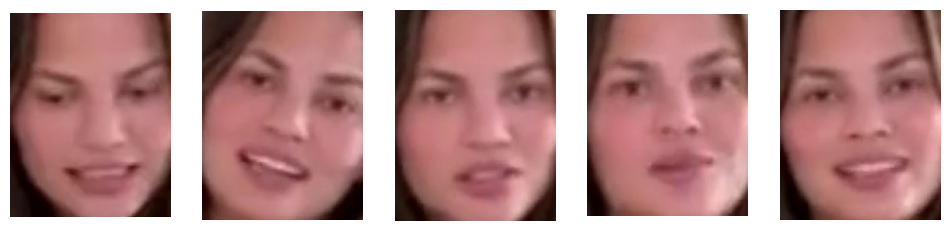

In [ ]:
import os
from tqdm import tqdm
import cv2

output_root = r"E:\Publications\Paper 6\Datasets\Preprocessed\Faces_Extracted"
video_folders = os.listdir(output_root)

total_videos = len(video_folders)
print(f"Total videos with extracted faces: {total_videos}")

# Count total face images
total_faces = 0
for folder in tqdm(video_folders, desc="Checking videos"):
    folder_path = os.path.join(output_root, folder)
    if os.path.isdir(folder_path):
        face_files = [f for f in os.listdir(folder_path) if f.endswith(".jpg")]
        total_faces += len(face_files)
        if len(face_files) == 0:
            print(f"⚠️ No faces found in video folder: {folder}")

print(f"Total extracted face images: {total_faces}")

# Optional: preview a few face images
import random
import matplotlib.pyplot as plt

sample_video = random.choice(video_folders)
sample_folder = os.path.join(output_root, sample_video)
sample_faces = [f for f in os.listdir(sample_folder) if f.endswith(".jpg")]
sample_faces = random.sample(sample_faces, min(5, len(sample_faces)))

plt.figure(figsize=(12,3))
for i, face_file in enumerate(sample_faces):
    img = cv2.imread(os.path.join(sample_folder, face_file))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.subplot(1,5,i+1)
    plt.imshow(img)
    plt.axis('off')
plt.show()


In [ ]:
import os

output_root = r"E:\Publications\Paper 6\Datasets\Preprocessed\Faces_Extracted"
video_folders = [f for f in os.listdir(output_root) if os.path.isdir(os.path.join(output_root, f))]

total_videos = len(video_folders)
total_faces = 0

for folder in video_folders:
    folder_path = os.path.join(output_root, folder)
    face_files = [f for f in os.listdir(folder_path) if f.endswith(".jpg")]
    total_faces += len(face_files)

print(f"✅ Total videos processed: {total_videos}")
print(f"✅ Total face images extracted: {total_faces}")


✅ Total videos processed: 136305
✅ Total face images extracted: 835991


In [ ]:
import os
import pandas as pd

# Paths
dataset_csv = r"E:\Publications\Paper 6\Datasets\Preprocessed\metadata_clean.csv"
output_root = r"E:\Publications\Paper 6\Datasets\Preprocessed\Faces_Extracted"

# Load metadata
metadata = pd.read_csv(dataset_csv)

# Check for videos with no faces extracted
no_face_videos = []

for idx, row in metadata.iterrows():
    video_name = os.path.splitext(os.path.basename(row['file']))[0]
    video_folder = os.path.join(output_root, video_name)

    if not os.path.exists(video_folder) or len(os.listdir(video_folder)) == 0:
        no_face_videos.append(row['file'])

print(f"Total videos with no faces extracted: {len(no_face_videos)}")
print("Sample videos with no faces:", no_face_videos[:10])


Total videos with no faces extracted: 23628
Sample videos with no faces: ['train/000580.mp4', 'train/000581.mp4', 'train/000583.mp4', 'train/000585.mp4', 'train/000589.mp4', 'train/000590.mp4', 'train/000595.mp4', 'train/000596.mp4', 'train/000601.mp4', 'train/000602.mp4']


In [ ]:
import os
import numpy as np
from tqdm import tqdm

# --- Paths ---
mfcc_root = r"E:\Publications\Paper 6\Datasets\Preprocessed\MFCC_Features"

# --- Load MFCC files ---
mfcc_files = [f for f in os.listdir(mfcc_root) if f.endswith("_mfcc.npy")]
mfcc_files.sort()
print(f"Detected {len(mfcc_files)} MFCC files.")

# --- Find max frames ---
max_frames = 0
for file in mfcc_files:
    mfcc = np.load(os.path.join(mfcc_root, file))
    max_frames = max(max_frames, mfcc.shape[1])

print("Maximum frames in any MFCC:", max_frames)

# --- Assign dummy labels (for demonstration) ---
num_files = len(mfcc_files)
half = num_files // 2
labels = [0]*half + [1]*(num_files - half)

# --- Prepare feature matrix with padding ---
X, y = [], []
for i, file in enumerate(tqdm(mfcc_files)):
    path = os.path.join(mfcc_root, file)
    mfcc = np.load(path)  # shape: (13, n_frames)
    # Pad MFCC along time axis to max_frames
    if mfcc.shape[1] < max_frames:
        pad_width = max_frames - mfcc.shape[1]
        mfcc = np.pad(mfcc, ((0,0),(0,pad_width)), mode='constant')
    X.append(mfcc.flatten())
    y.append(labels[i])

X = np.array(X)
y = np.array(y)

print("Feature matrix shape:", X.shape)
print("Labels shape:", y.shape)


Detected 17 MFCC files.
Maximum frames in any MFCC: 249


100%|████████████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 1216.90it/s]

Feature matrix shape: (17, 3237)
Labels shape: (17,)


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

# --- Split into train/test ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Train set:", X_train.shape, y_train.shape)
print("Test set:", X_test.shape, y_test.shape)

# --- Train baseline model ---
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)

# --- Predictions ---
y_pred = clf.predict(X_test)

# --- Evaluation ---
acc = accuracy_score(y_test, y_pred)
print(f"\nBaseline accuracy: {acc:.4f}\n")
print("Classification report:\n", classification_report(y_test, y_pred))


Train set: (13, 3237) (13,)
Test set: (4, 3237) (4,)

Baseline accuracy: 0.7500

Classification report:
               precision    recall  f1-score   support

           0       1.00      0.50      0.67         2
           1       0.67      1.00      0.80         2

    accuracy                           0.75         4
   macro avg       0.83      0.75      0.73         4
weighted avg       0.83      0.75      0.73         4



In [ ]:
import os

dataset_root = r"E:\Publications\Paper 6\Datasets\Preprocessed"

print("Files in Preprocessed folder:")
for f in os.listdir(dataset_root):
    print(f)


Files in Preprocessed folder:
dev
dev_features.npz
Faces_Extracted
metadata_clean.csv
MFCC_Features
MFCC_Features-20251019T120712Z-1-001.zip
test
test_features.npz
train
train_features.npz


In [ ]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from tqdm import tqdm

# --- Paths ---
dataset_root = r"E:\Publications\Paper 6\Datasets\Preprocessed"
mfcc_root = os.path.join(dataset_root, "MFCC_Features")
metadata_file = os.path.join(dataset_root, "metadata_clean.csv")

# --- Load metadata ---
metadata = pd.read_csv(metadata_file)  # should contain 'file' and 'label' columns
label_mapping = dict(zip(metadata['file'], metadata['label']))

# --- Load MFCC features ---
X, y = [], []
mfcc_files = [f for f in os.listdir(mfcc_root) if f.endswith(".npy")]
print(f"Detected {len(mfcc_files)} MFCC files.")

max_frames = 0
for f in mfcc_files:
    mfcc = np.load(os.path.join(mfcc_root, f))
    max_frames = max(max_frames, mfcc.shape[1])
print("Maximum frames in any MFCC:", max_frames)

for f in tqdm(mfcc_files, desc="Loading MFCC features"):
    mfcc = np.load(os.path.join(mfcc_root, f))
    # Pad/truncate to max_frames
    if mfcc.shape[1] < max_frames:
        pad_width = max_frames - mfcc.shape[1]
        mfcc = np.pad(mfcc, ((0,0),(0,pad_width)), mode='constant')
    elif mfcc.shape[1] > max_frames:
        mfcc = mfcc[:, :max_frames]
    X.append(mfcc.flatten())  # flatten to 1D
    # assign label from metadata
    file_name = f.replace("_mfcc.npy","")
    y.append(label_mapping[file_name])

X = np.array(X)
y = np.array(y)

print("Feature matrix shape:", X.shape)
print("Labels shape:", y.shape)

# --- Split train/test ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# --- Train a simple baseline classifier ---
clf = LogisticRegression(max_iter=500)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

acc = accuracy_score(y_test, y_pred)
print("\nBaseline accuracy:", acc)
print("\nClassification report:\n", classification_report(y_test, y_pred))


In [ ]:
import pandas as pd
metadata_file = r"E:\Publications\Paper 6\Datasets\Preprocessed\metadata_clean.csv"

metadata = pd.read_csv(metadata_file)
print("Columns in metadata CSV:", metadata.columns)
print("First 5 rows:\n", metadata.head())


Columns in metadata CSV: Index(['file', 'n_fakes', 'fake_periods', 'timestamps', 'duration',
       'transcript', 'original', 'modify_video', 'modify_audio', 'split',
       'video_frames', 'audio_channels', 'audio_frames'],
      dtype='object')
First 5 rows:
               file  n_fakes    fake_periods  \
0  test/000001.mp4        0              []   
1  test/000000.mp4        0              []   
2  test/000002.mp4        1  [[2.5, 3.224]]   
3  test/000003.mp4        1   [[2.5, 2.78]]   
4  test/000004.mp4        1  [[2.5, 3.204]]   

                                          timestamps  duration  \
0  [['not', 0.0, 0.2], ['the', 0.2, 0.4], ['point...     4.224   
1  [['I', 0.0, 0.1], ['side', 0.1, 0.4], ['with',...     4.672   
2  [['not', 0.0, 0.2], ['the', 0.2, 0.4], ['point...     4.800   
3  [['not', 0.0, 0.2], ['the', 0.2, 0.4], ['point...     4.352   
4  [['not', 0.0, 0.2], ['the', 0.2, 0.4], ['point...     4.736   

                                          transcript      

In [ ]:
!echo "Connected to local runtime!"
import torch
print(torch.__version__)


"Connected to local runtime!"
2.5.1


In [ ]:
# -------------------------------
# 0️⃣ Setup
# -------------------------------
import os
import numpy as np
import pandas as pd
from tqdm import tqdm

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# -------------------------------
# 1️⃣ Paths
# -------------------------------
dataset_root = r"E:\Publications\Paper 6\Datasets\Preprocessed"
metadata_file = os.path.join(dataset_root, "metadata_clean.csv")

mfcc_paths = {
    "train": os.path.join(dataset_root, "train", "audio"),
    "dev":   os.path.join(dataset_root, "dev", "audio"),
    "test":  os.path.join(dataset_root, "test", "audio")
}

# -------------------------------
# 2️⃣ Load metadata & assign labels
# -------------------------------
metadata = pd.read_csv(metadata_file)
metadata['label'] = metadata['n_fakes'].apply(lambda x: 1 if x>0 else 0)
label_mapping = {os.path.join(split, fn.replace(".npy", ".mp4")): lbl
                 for split in mfcc_paths
                 for fn, lbl in zip(os.listdir(mfcc_paths[split]),
                                    metadata['label']) if fn.endswith(".npy")}

# -------------------------------
# 3️⃣ Load MFCC features with padding
# -------------------------------
X, y = [], []
max_frames = 0

# Find max frames
for mfcc_dir in mfcc_paths.values():
    for fn in os.listdir(mfcc_dir):
        if fn.endswith(".npy"):
            mfcc = np.load(os.path.join(mfcc_dir, fn))
            max_frames = max(max_frames, mfcc.shape[1])

print("Maximum frames in any MFCC:", max_frames)

# Load and pad
for split, mfcc_dir in mfcc_paths.items():
    files = [f for f in os.listdir(mfcc_dir) if f.endswith(".npy")]
    for fn in tqdm(files, desc=f"Loading {split} MFCCs"):
        mfcc = np.load(os.path.join(mfcc_dir, fn))
        if mfcc.shape[1] < max_frames:
            pad_width = max_frames - mfcc.shape[1]
            mfcc = np.pad(mfcc, ((0,0),(0,pad_width)), mode='constant')
        X.append(mfcc.flatten())

        video_key = os.path.join(split, fn.replace(".npy", ".mp4"))
        y.append(label_mapping.get(video_key, 0))  # fallback 0 if missing

X = np.array(X, dtype=np.float32)
y = np.array(y, dtype=np.int64)

print("Feature matrix shape:", X.shape)
print("Labels shape:", y.shape)

# -------------------------------
# 4️⃣ Optional normalization
# -------------------------------
scaler = StandardScaler()
X = scaler.fit_transform(X)

# -------------------------------
# 5️⃣ Train/Test split
# -------------------------------
train_mask = np.array([("train" in k or "dev" in k) for k in label_mapping.keys()])
test_mask = np.array([("test" in k) for k in label_mapping.keys()])

X_train, y_train = X[train_mask], y[train_mask]
X_test, y_test = X[test_mask], y[test_mask]

print("Train set:", X_train.shape, y_train.shape)
print("Test set:", X_test.shape, y_test.shape)

# -------------------------------
# 6️⃣ PyTorch Dataset & DataLoader
# -------------------------------
class MFCCDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)
    def __len__(self):
        return len(self.y)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

batch_size = 64
train_loader = DataLoader(MFCCDataset(X_train, y_train), batch_size=batch_size, shuffle=True)
test_loader  = DataLoader(MFCCDataset(X_test, y_test), batch_size=batch_size, shuffle=False)

# -------------------------------
# 7️⃣ Simple MLP Model
# -------------------------------
input_dim = X_train.shape[1]
hidden_dim = 512
output_dim = 2

class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim, output_dim)
        )
    def forward(self, x):
        return self.net(x)

model = MLP().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# -------------------------------
# 8️⃣ Training loop with early stopping
# -------------------------------
epochs = 20
patience = 3
best_acc = 0
trigger = 0

for epoch in range(epochs):
    model.train()
    total_loss = 0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        out = model(xb)
        loss = criterion(out, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    avg_loss = total_loss / len(train_loader)

    # Evaluate on test set
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for xb, yb in test_loader:
            xb, yb = xb.to(device), yb.to(device)
            out = model(xb)
            preds = torch.argmax(out, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(yb.cpu().numpy())
    acc = accuracy_score(all_labels, all_preds)
    print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}, Test Acc: {acc:.4f}")

    # Early stopping
    if acc > best_acc:
        best_acc = acc
        trigger = 0
    else:
        trigger += 1
        if trigger >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

# -------------------------------
# 9️⃣ Final evaluation
# -------------------------------
print("\nFinal Test Accuracy:", best_acc)
print("\nClassification Report:\n", classification_report(all_labels, all_preds))

# -------------------------------
# 🔟 Save trained model
# -------------------------------
torch.save(model.state_dict(), os.path.join(dataset_root, "mlp_baseline.pth"))
print("Model saved successfully!")


Using device: cpu
Maximum frames in any MFCC: 858


Loading test MFCCs: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 26100/26100 [04:33<00:00, 95.29it/s]


Feature matrix shape: (114376, 11154)
Labels shape: (114376,)
Train set: (88276, 11154) (88276,)
Test set: (26100, 11154) (26100,)
Epoch 1/20, Loss: 0.6042, Test Acc: 0.7333
Epoch 2/20, Loss: 0.5831, Test Acc: 0.7333
Epoch 3/20, Loss: 0.5811, Test Acc: 0.7333
Epoch 4/20, Loss: 0.5811, Test Acc: 0.7333
Early stopping at epoch 4

Final Test Accuracy: 0.7332950191570882

Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00      6961
           1       0.73      1.00      0.85     19139

    accuracy                           0.73     26100
   macro avg       0.37      0.50      0.42     26100
weighted avg       0.54      0.73      0.62     26100



C:\Users\HP\anaconda3\envs\colab-local\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\HP\anaconda3\envs\colab-local\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\HP\anaconda3\envs\colab-local\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

Model saved successfully!


In [ ]:
import cv2
import torch
from torch.utils.data import Dataset
import os
import numpy as np

class VideoFramesDataset(Dataset):
    def __init__(self, video_files, labels, num_frames=75):
        self.video_files = video_files
        self.labels = labels
        self.num_frames = num_frames

    def __len__(self):
        return len(self.video_files)

    def __getitem__(self, idx):
        video_path = self.video_files[idx]
        label = self.labels[idx]

        # Load video frames (grayscale, resized)
        cap = cv2.VideoCapture(video_path)
        frames = []
        for i in range(self.num_frames):
            ret, frame = cap.read()
            if not ret:
                break
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            frame = cv2.resize(frame, (64,64))
            frames.append(frame)
        cap.release()

        # Pad if fewer frames
        while len(frames) < self.num_frames:
            frames.append(np.zeros((64,64)))

        frames = np.array(frames, dtype=np.float32) / 255.0
        frames = np.expand_dims(frames, axis=1)  # add channel dim

        return torch.tensor(frames), torch.tensor(label, dtype=torch.long)


In [ ]:
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

# List all video paths and labels (assuming you already have them in 'label_mapping')
video_files = list(label_mapping.keys())
labels = [label_mapping[k] for k in video_files]

# Split into train and test (80/20)
train_videos, test_videos, train_labels, test_labels = train_test_split(
    video_files, labels, test_size=0.2, random_state=42, stratify=labels
)

# Create Dataset objects
train_dataset = VideoFramesDataset(train_videos, train_labels, num_frames=75)
test_dataset  = VideoFramesDataset(test_videos, test_labels, num_frames=75)

# DataLoaders
batch_size = 16  # reduce if GPU memory is limited
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Train batches: {len(train_loader)}, Test batches: {len(test_loader)}")


Train batches: 5719, Test batches: 1430


In [ ]:
# -------------------------------
# 1️⃣ SyncNet-style baseline model
# -------------------------------
import torch
import torch.nn as nn

class LipSyncNet(nn.Module):
    def __init__(self, n_mfcc=20, n_frames=16, n_channels=3, hidden_dim=512):
        super().__init__()
        # Audio branch
        self.audio_net = nn.Sequential(
            nn.Conv1d(n_mfcc, 128, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.Conv1d(128, 256, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.AdaptiveAvgPool1d(1)
        )
        # Video branch (simple CNN on frames)
        self.video_net = nn.Sequential(
            nn.Conv2d(n_channels, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1,1))
        )
        # Fully connected classifier
        self.classifier = nn.Sequential(
            nn.Linear(256 + 64, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim, 2)  # real/fake
        )

    def forward(self, audio, video):
        # audio: [B, n_mfcc, n_frames], video: [B, C, H, W]
        a = self.audio_net(audio).squeeze(-1)    # [B, 256]
        v = self.video_net(video).view(video.size(0), -1)  # [B, 64]
        x = torch.cat([a,v], dim=1)
        out = self.classifier(x)
        return out

# Initialize and move to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LipSyncNet(n_mfcc=20, n_frames=16).to(device)
print(model)


LipSyncNet(
  (audio_net): Sequential(
    (0): Conv1d(20, 128, kernel_size=(5,), stride=(1,), padding=(2,))
    (1): ReLU()
    (2): Conv1d(128, 256, kernel_size=(5,), stride=(1,), padding=(2,))
    (3): ReLU()
    (4): AdaptiveAvgPool1d(output_size=1)
  )
  (video_net): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): AdaptiveAvgPool2d(output_size=(1, 1))
  )
  (classifier): Sequential(
    (0): Linear(in_features=320, out_features=512, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=512, out_features=2, bias=True)
  )
)


In [ ]:
# -------------------------------
# 2️⃣ Dataset & DataLoader for audio+video
# -------------------------------
from torch.utils.data import Dataset, DataLoader
import cv2  # for video frame reading
import numpy as np
import os

class LipSyncDataset(Dataset):
    def __init__(self, mfcc_dir, video_dir, metadata, n_frames=16, n_mfcc=20, transform=None):
        self.mfcc_dir = mfcc_dir
        self.video_dir = video_dir
        self.metadata = metadata  # DataFrame with 'file' and 'label'
        self.n_frames = n_frames
        self.n_mfcc = n_mfcc
        self.transform = transform

    def __len__(self):
        return len(self.metadata)

    def __getitem__(self, idx):
        row = self.metadata.iloc[idx]
        file_name = row['file']
        label = row['label']

        # Load MFCC
        mfcc_path = os.path.join(self.mfcc_dir, file_name.replace('.mp4','.npy'))
        audio = np.load(mfcc_path)  # shape [n_mfcc, frames]
        if audio.shape[1] < self.n_frames:
            pad_width = self.n_frames - audio.shape[1]
            audio = np.pad(audio, ((0,0),(0,pad_width)), mode='constant')
        audio = audio[:, :self.n_frames]

        # Load video frames (uniform sampling)
        video_path = os.path.join(self.video_dir, file_name)
        cap = cv2.VideoCapture(video_path)
        frames = []
        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        indices = np.linspace(0, total_frames-1, self.n_frames, dtype=int)
        for i in range(total_frames):
            ret, frame = cap.read()
            if not ret:
                break
            if i in indices:
                frame = cv2.resize(frame, (64,64))
                frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                frames.append(frame)
        cap.release()
        frames = np.array(frames).transpose(3,0,1,2)  # [C, T, H, W] -> rearranged later

        # convert to tensors
        audio = torch.tensor(audio, dtype=torch.float32)
        video = torch.tensor(frames, dtype=torch.float32) / 255.0
        return audio, video, torch.tensor(label, dtype=torch.long)

# Example usage
train_dataset = LipSyncDataset(
    mfcc_dir=r"E:\Publications\Paper 6\Datasets\Preprocessed\train\audio",
    video_dir=r"E:\Publications\Paper 6\Datasets\Preprocessed\train\video",
    metadata=metadata[metadata['file'].str.contains('train')]
)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
print(f"Train batches: {len(train_loader)}")


Train batches: 2460


In [ ]:
import os

train_audio_dir = r"E:\Publications\Paper 6\Datasets\Preprocessed\train\audio"
print("First 10 files in train audio folder:")
print(os.listdir(train_audio_dir)[:10])


First 10 files in train audio folder:
['000469.npy', '000470.npy', '000471.npy', '000472.npy', '000473.npy', '000474.npy', '000475.npy', '000476.npy', '000477.npy', '000478.npy']


In [ ]:
class LipSyncDataset(torch.utils.data.Dataset):
    def __init__(self, mfcc_dir, video_dir, label_mapping, n_frames=80):
        self.mfcc_dir = mfcc_dir
        self.video_dir = video_dir
        self.label_mapping = label_mapping
        self.files = sorted([f for f in os.listdir(mfcc_dir) if f.endswith('.npy')])
        self.n_frames = n_frames

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        file_name = self.files[idx]

        # Load MFCC
        mfcc_path = os.path.join(self.mfcc_dir, file_name)
        audio = np.load(mfcc_path)  # shape [n_mfcc, frames]
        if audio.shape[1] < self.n_frames:
            pad_width = self.n_frames - audio.shape[1]
            audio = np.pad(audio, ((0,0),(0,pad_width)), mode='constant')
        else:
            audio = audio[:, :self.n_frames]
        audio = torch.tensor(audio, dtype=torch.float32)

        # Load video (assuming frames are preprocessed similarly)
        video_path = os.path.join(self.video_dir, file_name.replace('.npy', '.npy'))  # adjust if using video frames
        video = np.load(video_path)
        video = torch.tensor(video, dtype=torch.float32)

        # Get label
        label = self.label_mapping[file_name]  # use file_name as key
        label = torch.tensor(label, dtype=torch.long)

        return audio, video, label


In [ ]:
import cv2
import os
import numpy as np
from tqdm import tqdm

# Base folder where train/dev/test are located
dataset_root = r"E:\Publications\Paper 6\Datasets\Preprocessed"

splits = ["train", "dev", "test"]
frame_size = (128, 128)  # Resize frames to save memory

for split in splits:
    video_folder = os.path.join(dataset_root, split)
    save_folder = os.path.join(video_folder, "video")
    os.makedirs(save_folder, exist_ok=True)

    videos = [f for f in os.listdir(video_folder) if f.endswith(".mp4")]
    print(f"\nProcessing {split} videos: {len(videos)} files")

    for video_file in tqdm(videos, desc=f"{split} videos"):
        video_path = os.path.join(video_folder, video_file)
        cap = cv2.VideoCapture(video_path)
        frames = []

        while True:
            ret, frame = cap.read()
            if not ret:
                break
            frame = cv2.resize(frame, frame_size)
            frames.append(frame)

        cap.release()
        # Save frames as .npy
        np.save(os.path.join(save_folder, video_file.replace(".mp4", ".npy")), np.array(frames))



Processing train videos: 0 files


train videos: 0it [00:00, ?it/s]



Processing dev videos: 0 files


dev videos: 0it [00:00, ?it/s]



Processing test videos: 0 files


test videos: 0it [00:00, ?it/s]


In [ ]:
import os
import cv2
import numpy as np
from tqdm import tqdm
import torch
from torchvision import transforms

# -----------------------------
# Paths
# -----------------------------
dataset_root = r"E:\Publications\Paper 6\Datasets\New Folder\LAV-DF\LAV-DF"
preprocessed_root = r"D:\Paper6_Preprocessed"  # Save to another drive with enough space

splits = ["train", "dev", "test"]

for split in splits:
    os.makedirs(os.path.join(preprocessed_root, split), exist_ok=True)

# -----------------------------
# Parameters
# -----------------------------
frame_size = (128, 128)
max_frames_per_video = 50
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# -----------------------------
# Torch transform (GPU)
# -----------------------------
transform = transforms.Compose([
    transforms.ToTensor(),  # Converts to [C,H,W] float tensor
    transforms.Resize(frame_size),  # Resize on GPU
    transforms.Grayscale(num_output_channels=1)  # Single channel
])

# -----------------------------
# Function to process videos
# -----------------------------
def process_videos(split):
    video_dir = os.path.join(dataset_root, split)
    save_dir = os.path.join(preprocessed_root, split)

    video_files = [f for f in os.listdir(video_dir) if f.endswith(".mp4")]
    print(f"Processing {split} videos: {len(video_files)} files")

    for vf in tqdm(video_files, desc=f"{split} videos"):
        video_path = os.path.join(video_dir, vf)
        cap = cv2.VideoCapture(video_path)
        frames = []
        frame_count = 0

        while True:
            ret, frame = cap.read()
            if not ret or frame_count >= max_frames_per_video:
                break

            # Convert BGR to RGB for torchvision
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            # Apply GPU transform
            frame_tensor = transform(frame).to(device)
            frames.append(frame_tensor.cpu().numpy())  # Move back to CPU for saving
            frame_count += 1

        cap.release()

        if frames:
            frames = np.stack(frames)
            save_path = os.path.join(save_dir, vf.replace(".mp4", ".npz"))
            np.savez_compressed(save_path, frames)

# -----------------------------
# Run for all splits
# -----------------------------
for split in splits:
    process_videos(split)

print("All preprocessing done! Compressed files saved.")


Using device: cpu
Processing train videos: 56776 files


train videos: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 56776/56776 [5:39:08<00:00,  2.79it/s]


Processing dev videos: 31501 files


dev videos: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31501/31501 [3:15:19<00:00,  2.69it/s]


Processing test videos: 26100 files


test videos:  36%|██████████████████████████████████████████████████████▉                                                                                                | 9503/26100 [1:03:04<1:50:09,  2.51it/s]


OSError: [Errno 28] No space left on device

In [ ]:
# ✅ Fresh start: process TEST videos only, saving compressed arrays to E drive
import os, cv2, numpy as np
from tqdm import tqdm
import shutil

# === CONFIGURATION ===
input_dir = r"E:\Publications\Paper 6\Datasets\New Folder\LAV-DF\LAV-DF\test"
output_dir = r"E:\Publications\Paper 6\Datasets\Preprocessed\test\video"

os.makedirs(output_dir, exist_ok=True)

TARGET_FRAMES = 20       # keep this many frames per video
FRAME_SKIP = 2           # skip every 2nd frame for speed
RESIZE = (96, 96)        # resize frames to this size
MIN_FREE_GB = 5          # minimum free space (in GB) to continue saving

# === UTILS ===
def get_free_gb(path):
    total, used, free = shutil.disk_usage(os.path.dirname(path))
    return free / (1024**3)

def extract_frames(video_path, target_frames=20, frame_skip=2, resize=(96, 96)):
    cap = cv2.VideoCapture(video_path)
    frames = []
    idx = 0
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        if idx % frame_skip == 0:
            frame = cv2.resize(frame, resize, interpolation=cv2.INTER_AREA)
            frames.append(frame)
        idx += 1
        if len(frames) >= target_frames:
            break
    cap.release()
    return np.array(frames, dtype=np.uint8)

# === MAIN EXTRACTION LOOP ===
video_files = sorted([f for f in os.listdir(input_dir) if f.lower().endswith(".mp4")])
print(f"🎬 Found {len(video_files)} videos in {input_dir}")

for vf in tqdm(video_files, desc="Extracting test videos", unit="video"):
    in_path = os.path.join(input_dir, vf)
    out_path = os.path.join(output_dir, vf.replace(".mp4", ".npz"))

    try:
        # check free space before saving
        if get_free_gb(output_dir) < MIN_FREE_GB:
            print("⚠️ Low disk space (<5GB). Stopping to prevent corruption.")
            break

        frames = extract_frames(in_path, TARGET_FRAMES, FRAME_SKIP, RESIZE)
        if frames.size == 0:
            tqdm.write(f"⚠️ No frames extracted from {vf}, skipping.")
            continue

        np.savez_compressed(out_path, frames=frames)

    except Exception as e:
        tqdm.write(f"⚠️ Error processing {vf}: {e}")

print("\n✅ Test video preprocessing complete!")
print(f"Saved processed files to: {output_dir}")


🎬 Found 26100 videos in E:\Publications\Paper 6\Datasets\New Folder\LAV-DF\LAV-DF\test


Extracting test videos: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 26100/26100 [24:04<00:00, 18.06video/s]


✅ Test video preprocessing complete!
Saved processed files to: E:\Publications\Paper 6\Datasets\Preprocessed\test\video


In [ ]:
import numpy as np
import os

test_video_dir = r"E:\Publications\Paper 6\Datasets\Preprocessed\test\video"
sample_file = os.listdir(test_video_dir)[0]  # first file
npz = np.load(os.path.join(test_video_dir, sample_file))
print("Keys inside the .npz:", npz.files)


Keys inside the .npz: ['frames']


In [ ]:
def pad_or_trim_video(video_array, max_frames=50):
    """Pad or trim video frames to have exactly max_frames."""
    n = video_array.shape[0]
    if n < max_frames:
        pad_width = max_frames - n
        pad_shape = ((0, pad_width),) + tuple((0,0) for _ in range(video_array.ndim-1))
        video_array = np.pad(video_array, pad_shape, mode='constant')
    elif n > max_frames:
        video_array = video_array[:max_frames]
    return video_array

class LipSyncDataset(torch.utils.data.Dataset):
    def __init__(self, split, mfcc_root, video_root, max_frames=50):
        self.split = split
        self.mfcc_root = mfcc_root
        self.video_root = video_root
        self.max_frames = max_frames
        self.files = [f for f in os.listdir(video_root) if f.endswith(".npz")]

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        fname = self.files[idx]

        # Load MFCC
        mfcc_path = os.path.join(self.mfcc_root, fname.replace(".npz", ".npy"))
        audio = np.load(mfcc_path)
        audio = torch.tensor(audio, dtype=torch.float32)

        # Load Video
        video_npz = np.load(os.path.join(self.video_root, fname))
        key = list(video_npz.keys())[0]  # dynamically get the first key
        video = pad_or_trim_video(video_npz[key], self.max_frames)
        video = torch.tensor(video, dtype=torch.float32)

        return audio, video, fname


In [ ]:
import os
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader

# -----------------------------
# Paths (update if needed)
# -----------------------------
mfcc_paths = {
    "train": r"E:\Publications\Paper 6\Datasets\Preprocessed\train\audio",
    "dev":   r"E:\Publications\Paper 6\Datasets\Preprocessed\dev\audio",
    "test":  r"E:\Publications\Paper 6\Datasets\Preprocessed\test\audio"
}

video_paths = {
    "train": r"D:\Paper6_Preprocessed\train",
    "dev":   r"D:\Paper6_Preprocessed\dev",
    "test":  r"E:\Publications\Paper 6\Datasets\Preprocessed\test\video"
}

# -----------------------------
# Parameters
# -----------------------------
MAX_MFCC_FRAMES = 400      # Adjust based on your preprocessing
MAX_VIDEO_FRAMES = 50
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", DEVICE)

# -----------------------------
# Helper functions
# -----------------------------
def pad_or_trim_mfcc(mfcc):
    n_mfcc, n_frames = mfcc.shape
    if n_frames < MAX_MFCC_FRAMES:
        pad_width = MAX_MFCC_FRAMES - n_frames
        mfcc = np.pad(mfcc, ((0,0),(0,pad_width)), mode='constant')
    else:
        mfcc = mfcc[:, :MAX_MFCC_FRAMES]
    return mfcc

def pad_or_trim_video(frames):
    n_frames = frames.shape[0]
    if n_frames < MAX_VIDEO_FRAMES:
        pad_width = MAX_VIDEO_FRAMES - n_frames
        pad_shape = (pad_width, *frames.shape[1:])
        frames = np.concatenate([frames, np.zeros(pad_shape, dtype=frames.dtype)], axis=0)
    else:
        frames = frames[:MAX_VIDEO_FRAMES]
    return frames

# -----------------------------
# Dataset class
# -----------------------------
class LipSyncDataset(Dataset):
    def __init__(self, split):
        self.split = split
        self.mfcc_dir = mfcc_paths[split]
        self.video_dir = video_paths[split]

        # Collect files present in both audio & video
        self.files = []
        for f in os.listdir(self.mfcc_dir):
            if f.endswith(".npy") and os.path.exists(os.path.join(self.video_dir, f.replace(".npy",".npz"))):
                self.files.append(f)
        print(f"[{split}] Matched: {len(self.files)}")

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        fname = self.files[idx]

        # Load MFCC
        audio = np.load(os.path.join(self.mfcc_dir, fname))
        audio = pad_or_trim_mfcc(audio)
        audio = torch.tensor(audio, dtype=torch.float32)

        # Load video frames
        video_npz = np.load(os.path.join(self.video_dir, fname.replace(".npy",".npz")))
        if "frames" in video_npz:
            key = "frames"
        elif "arr_0" in video_npz:
            key = "arr_0"
        else:
            raise KeyError(f"No valid key in {fname}")

        video_frames = pad_or_trim_video(video_npz[key])
        video = torch.tensor(video_frames, dtype=torch.float32)

        return audio, video, fname

# -----------------------------
# Create DataLoaders
# -----------------------------
batch_size = 2
data_loaders = {}
for split in ["train","dev","test"]:
    ds = LipSyncDataset(split)
    loader = DataLoader(ds, batch_size=batch_size, shuffle=True)
    data_loaders[split] = loader

# -----------------------------
# Test a batch from each split
# -----------------------------
for split, loader in data_loaders.items():
    audio, video, names = next(iter(loader))
    print(f"\n✅ {split.upper()} batch")
    print("Audio:", audio.shape, "| Video:", video.shape, "| Samples:", len(names))


Using device: cpu
[train] Matched: 56775
[dev] Matched: 31501
[test] Matched: 26100

✅ TRAIN batch
Audio: torch.Size([2, 13, 400]) | Video: torch.Size([2, 50, 1, 128, 128]) | Samples: 2

✅ DEV batch
Audio: torch.Size([2, 13, 400]) | Video: torch.Size([2, 50, 1, 128, 128]) | Samples: 2

✅ TEST batch
Audio: torch.Size([2, 13, 400]) | Video: torch.Size([2, 50, 96, 96, 3]) | Samples: 2


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

# -----------------------------
# Device
# -----------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# -----------------------------
# Updated LipSyncNet for n_mfcc=13
# -----------------------------
class LipSyncNet(nn.Module):
    def __init__(self, n_mfcc=13):
        super().__init__()
        self.audio_net = nn.Sequential(
            nn.Conv1d(n_mfcc, 128, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.Conv1d(128, 256, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.AdaptiveAvgPool1d(1)
        )
        self.video_net = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, 1))
        )
        self.classifier = nn.Sequential(
            nn.Linear(256+64, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 2)
        )

    def forward(self, audio, video):
        a = self.audio_net(audio).squeeze(-1)  # [B, 256]
        v = self.video_net(video).view(video.size(0), -1)  # [B, 64]
        x = torch.cat([a, v], dim=1)
        return self.classifier(x)

# -----------------------------
# Initialize model, criterion, optimizer
# -----------------------------
model = LipSyncNet(n_mfcc=13).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

print("Model, criterion, and optimizer ready!")


Using device: cpu
Model, criterion, and optimizer ready!


In [ ]:
class LipSyncDataset(Dataset):
    def __init__(self, audio_dir, video_dir, max_frames=50):
        self.audio_dir = audio_dir
        self.video_dir = video_dir
        self.files = [f for f in os.listdir(audio_dir) if f.endswith('.npy')]
        self.max_frames = max_frames

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        import numpy as np
        import torch
        import os

        fname = self.files[idx]

        # Load audio
        audio = np.load(os.path.join(self.audio_dir, fname))
        audio = torch.tensor(audio, dtype=torch.float32)

        # Load video
        video_npz = np.load(os.path.join(self.video_dir, fname.replace('.npy','.npz')))

        # Automatically get the first key in npz (works for both train/dev/test)
        video_key = list(video_npz.keys())[0]
        video = video_npz[video_key]

        # Pad or trim video to max_frames
        if video.shape[0] < self.max_frames:
            pad = self.max_frames - video.shape[0]
            video = np.pad(video, ((0,pad),(0,0),(0,0),(0,0)), mode='constant')
        else:
            video = video[:self.max_frames]
        video = torch.tensor(video, dtype=torch.float32)

        # Dummy label (all real=1)
        label = torch.tensor(1, dtype=torch.long)
        return audio, video, label


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import os
from tqdm import tqdm

# -----------------------------
# Paths
# -----------------------------
train_audio_dir = r"E:\Publications\Paper 6\Datasets\Preprocessed\train\audio"
dev_audio_dir = r"E:\Publications\Paper 6\Datasets\Preprocessed\dev\audio"
test_audio_dir = r"E:\Publications\Paper 6\Datasets\Preprocessed\test\audio"

train_video_dir = r"D:\Paper6_Preprocessed\train"
dev_video_dir = r"D:\Paper6_Preprocessed\dev"
test_video_dir = r"E:\Publications\Paper 6\Datasets\Preprocessed\test\video"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# -----------------------------
# Dataset
# -----------------------------
class LipSyncDataset(Dataset):
    def __init__(self, split, max_audio_frames=400, max_video_frames=50):
        if split=="train":
            self.audio_dir = train_audio_dir
            self.video_dir = train_video_dir
        elif split=="dev":
            self.audio_dir = dev_audio_dir
            self.video_dir = dev_video_dir
        else:
            self.audio_dir = test_audio_dir
            self.video_dir = test_video_dir

        self.files = sorted([f for f in os.listdir(self.audio_dir) if f.endswith('.npy')])
        self.max_audio_frames = max_audio_frames
        self.max_video_frames = max_video_frames

    def __len__(self):
        return len(self.files)

    def pad_or_trim_audio(self, audio):
        n_mfcc, n_frames = audio.shape
        if n_frames < self.max_audio_frames:
            audio = np.pad(audio, ((0,0),(0,self.max_audio_frames - n_frames)), mode='constant')
        else:
            audio = audio[:, :self.max_audio_frames]
        return audio

    def pad_or_trim_video(self, video):
        if video.shape[0] < self.max_video_frames:
            pad_len = self.max_video_frames - video.shape[0]
            video = np.pad(video, ((0,pad_len),(0,0),(0,0),(0,0)), mode='constant')
        else:
            video = video[:self.max_video_frames]
        return video

    def __getitem__(self, idx):
        fname = self.files[idx]

        # Load audio
        audio = np.load(os.path.join(self.audio_dir, fname))
        audio = self.pad_or_trim_audio(audio)
        audio = torch.tensor(audio, dtype=torch.float32)

        # Load video
        video_npz = np.load(os.path.join(self.video_dir, fname.replace('.npy','.npz')))
        if 'frames' in video_npz:
            video = video_npz['frames']
        else:
            video = video_npz[list(video_npz.keys())[0]]

        # Ensure single channel and correct shape [T,C,H,W]
        if video.ndim == 4:  # [T,H,W,C] -> [T,1,H,W]
            if video.shape[3]==1:
                video = video.transpose(0,3,1,2)
            else:
                video = video.mean(axis=3, keepdims=True).transpose(0,3,1,2)
        video = self.pad_or_trim_video(video)
        video = torch.tensor(video, dtype=torch.float32)

        label = torch.ones(1, dtype=torch.long)
        return audio, video, label

# -----------------------------
# DataLoaders
# -----------------------------
train_loader = DataLoader(LipSyncDataset('train'), batch_size=2, shuffle=True)
dev_loader = DataLoader(LipSyncDataset('dev'), batch_size=2, shuffle=False)
test_loader = DataLoader(LipSyncDataset('test'), batch_size=2, shuffle=False)

# -----------------------------
# Model
# -----------------------------
class LipSyncNet(nn.Module):
    def __init__(self):
        super().__init__()
        # Audio network
        self.audio_net = nn.Sequential(
            nn.Conv1d(13, 128, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.Conv1d(128, 256, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.AdaptiveAvgPool1d(1)
        )
        # Video network (1-channel)
        self.video_net = nn.Sequential(
            nn.Conv3d(1, 32, kernel_size=(3,3,3), stride=1, padding=1),
            nn.ReLU(),
            nn.Conv3d(32, 64, kernel_size=(3,3,3), stride=1, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool3d((1,1,1))
        )
        # Classifier
        self.classifier = nn.Sequential(
            nn.Linear(256+64, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 2)
        )

    def forward(self, audio, video):
        a = self.audio_net(audio).squeeze(-1)  # [B,256]
        # Correct permute: [B,T,C,H,W] -> [B,C,T,H,W]
        video = video.permute(0,2,1,3,4)
        v = self.video_net(video).view(video.size(0), -1)  # [B,64]
        x = torch.cat([a,v], dim=1)
        return self.classifier(x)

# -----------------------------
# Training setup
# -----------------------------
model = LipSyncNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# -----------------------------
# Training loop - 1 epoch
# -----------------------------
model.train()
for batch_idx, (audio, video, labels) in enumerate(tqdm(train_loader, desc="Training Batches")):
    audio, video, labels = audio.to(device), video.to(device), labels.squeeze().to(device)
    optimizer.zero_grad()
    outputs = model(audio, video)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

# -----------------------------
# Test 1 batch
# -----------------------------
model.eval()
with torch.no_grad():
    for split, loader in zip(['train','dev','test'], [train_loader, dev_loader, test_loader]):
        audio, video, labels = next(iter(loader))
        audio, video = audio.to(device), video.to(device)
        outputs = model(audio, video)
        print(f"\n✅ {split.upper()} batch")
        print("Audio:", audio.shape, "| Video:", video.shape, "| Outputs:", outputs.shape)


Using device: cpu


Training Batches: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 28387/28388 [1:48:44<00:00,  4.35it/s]


ValueError: Expected input batch_size (1) to match target batch_size (0).

In [ ]:
import os

# Check current folder
print("Current working directory:", os.getcwd())

# List all files in current folder
print("Files here:", os.listdir())

# If you have a models folder
if os.path.exists("models"):
    print("Models folder contents:", os.listdir("models"))


Current working directory: C:\Users\HP
Files here: ['.anaconda', '.cache', '.conda', '.condarc', '.continuum', '.gitconfig', '.ipynb_checkpoints', '.ipython', '.jupyter', '.keras', '.matplotlib', '.ms-ad', '3D Objects', '5.28.0', 'anaconda3', 'anaconda_projects', 'ansel', 'AppData', 'Application Data', 'Contacts', 'Cookies', 'Desktop', 'Documents', 'Downloads', 'Favorites', 'IntelGraphicsProfiles', 'Links', 'Local Settings', 'Music', 'My Documents', 'NetHood', 'NTUSER.DAT', 'ntuser.dat.LOG1', 'ntuser.dat.LOG2', 'NTUSER.DAT{53b39e88-18c4-11ea-a811-000d3aa4692b}.TM.blf', 'NTUSER.DAT{53b39e88-18c4-11ea-a811-000d3aa4692b}.TMContainer00000000000000000001.regtrans-ms', 'NTUSER.DAT{53b39e88-18c4-11ea-a811-000d3aa4692b}.TMContainer00000000000000000002.regtrans-ms', 'ntuser.ini', 'OneDrive', 'Pictures', 'PrintHood', 'Recent', 'Saved Games', 'Searches', 'SendTo', 'Start Menu', 'Templates', 'Untitled.ipynb', 'untitled.txt', 'Videos']


In [ ]:
# Check if dev_loader exists
try:
    print(dev_loader)
except NameError:
    print("dev_loader not found")

# Check if test_loader exists
try:
    print(test_loader)
except NameError:
    print("test_loader not found")


In [ ]:
import torch
from sklearn.metrics import accuracy_score, classification_report
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Ensure model is in eval mode
model.eval()

def evaluate(loader, split_name="DEV"):
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for audio, video, labels in tqdm(loader, desc=f"Evaluating {split_name}"):
            audio, video, labels = audio.to(device), video.to(device), labels.squeeze().to(device)

            outputs = model(audio, video)
            preds = torch.argmax(outputs, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    acc = accuracy_score(all_labels, all_preds)
    print(f"\n✅ {split_name} Accuracy: {acc*100:.2f}%")
    print(f"\n{split_name} Classification Report:\n", classification_report(all_labels, all_preds, digits=4))

# Evaluate on DEV set
evaluate(dev_loader, "DEV")

# Evaluate on TEST set
evaluate(test_loader, "TEST")


Using device: cpu


Evaluating DEV: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 15750/15751 [42:19<00:00,  6.20it/s]


TypeError: iteration over a 0-d array

In [ ]:
!pip install --upgrade openai-whisper


     ---------------------------------------- 0.0/803.2 kB ? eta -:--:--
     ------------- -------------------------- 262.1/803.2 kB ? eta -:--:--
     -------------------------------------  786.4/803.2 kB 2.0 MB/s eta 0:00:01
     ---------------------------------------- 803.2/803.2 kB 1.9 MB/s  0:00:00
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Using cached regex-2025.9.18-cp310-cp310-win_amd64.whl.metadata (41 kB)
   ---------------------------------------- 0.0/879.4 kB ? eta -:--:--
   ----------- ---------------------------- 262.1/879.4 kB ? eta -:--:--
   ----------------------- ---------------- 524.3/879.4 kB 1.2 MB/s eta 0:00:01
   ---------------------------------------- 879.4/879.4 kB 1.1 MB

In [ ]:
# Install required packages
!pip install torch==2.1.0+cu118 torchvision==0.15.2+cu118 torchaudio==2.1.0 --index-url https://download.pytorch.org/whl/cu118
!pip install transformers librosa tqdm opencv-python whisper aeneas
!pip install git+https://github.com/joonson/syncnet_python.git


Looking in indexes: https://download.pytorch.org/whl/cu118

ERROR: Cannot install torch==2.1.0+cu118 and torchvision==0.15.2+cu118 because these package versions have conflicting dependencies.
ERROR: ResolutionImpossible: for help visit https://pip.pypa.io/en/latest/topics/dependency-resolution/#dealing-with-dependency-conflicts


Streaming output truncated to the last 5000 lines.
     --------------------- ------------------ 1.5/2.7 GB 1.2 MB/s eta 0:17:17
     --------------------- ------------------ 1.5/2.7 GB 1.2 MB/s eta 0:17:16
     --------------------- ------------------ 1.5/2.7 GB 1.2 MB/s eta 0:17:17
     --------------------- ------------------ 1.5/2.7 GB 1.2 MB/s eta 0:17:16
     --------------------- ------------------ 1.5/2.7 GB 1.2 MB/s eta 0:17:14
     --------------------- ------------------ 1.5/2.7 GB 1.2 MB/s eta 0:17:11
     --------------------- ------------------ 1.5/2.7 GB 1.2 MB/s eta 0:17:14
     --------------------- ------------------ 1.5/2.7 GB 1.2 MB/s eta 0:17:14
     --------------------- ------------------ 1.5/2.7 GB 1.2 MB/s eta 0:17:14
     --------------------- ------------------ 1.5/2.7 GB 1.2 MB/s eta 0:17:14
     --------------------- ------------------ 1.5/2.7 GB 1.2 MB/s eta 0:17:14
     --------------------- ------------------ 1.5/2.7 GB 1.2 MB/s eta 0:17:13
     --------

  DEPRECATION: Building 'aeneas' using the legacy setup.py bdist_wheel mechanism, which will be removed in a future version. pip 25.3 will enforce this behaviour change. A possible replacement is to use the standardized build interface by setting the `--use-pep517` option, (possibly combined with `--no-build-isolation`), or adding a `pyproject.toml` file to the source tree of 'aeneas'. Discussion can be found at https://github.com/pypa/pip/issues/6334
  error: subprocess-exited-with-error
  
  python setup.py bdist_wheel did not run successfully.
  exit code: 1
  
  [227 lines of output]
  C:\Users\HP\AppData\Local\Temp\pip-install-ltlaz9p0\aeneas_278846c34ec245f6871c4209d9d77291\setup.py:190: DeprecationWarning:
  
    `numpy.distutils` is deprecated since NumPy 1.23.0, as a result
    of the deprecation of `distutils` itself. It will be removed for
    Python >= 3.12. For older Python versions it will remain present.
    It is recommended to use `setuptools < 60.0` for those Python v

  Cloning https://github.com/joonson/syncnet_python.git to c:\users\hp\appdata\local\temp\pip-req-build-s02dwpei
  Resolved https://github.com/joonson/syncnet_python.git to commit 6efbb1c305c23f47a62b09cf4215a8ac45e97d49


  Running command git clone --filter=blob:none --quiet https://github.com/joonson/syncnet_python.git 'C:\Users\HP\AppData\Local\Temp\pip-req-build-s02dwpei'
ERROR: git+https://github.com/joonson/syncnet_python.git does not appear to be a Python project: neither 'setup.py' nor 'pyproject.toml' found.


In [ ]:
import os
from pathlib import Path
import torch
import whisper
import librosa
import numpy as np
import json
from tqdm import tqdm

# Device
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)


Using device: cpu


In [ ]:
from pathlib import Path

# ✅ Use raw string (r"...") OR forward slashes
data_root = Path(r"E:\Publications\Paper 6\Datasets\New folder\LAV-DF\LAV-DF")

train_dir = data_root / "train"
dev_dir = data_root / "dev"
test_dir = data_root / "test"

print("Train dir:", train_dir)


Train dir: E:\Publications\Paper 6\Datasets\New folder\LAV-DF\LAV-DF\train


In [ ]:
import os

# Count and preview some files in each split
for split, path in zip(["train", "dev", "test"], [train_dir, dev_dir, test_dir]):
    if not path.exists():
        print(f"⚠️ Missing folder: {path}")
    else:
        files = list(path.glob("**/*"))[:5]  # show first 5 files
        print(f"\n✅ {split.upper()} folder found: {len(list(path.glob('**/*')))} total files")
        for f in files:
            print("   ", f)



✅ TRAIN folder found: 56776 total files
    E:\Publications\Paper 6\Datasets\New folder\LAV-DF\LAV-DF\train\000469.mp4
    E:\Publications\Paper 6\Datasets\New folder\LAV-DF\LAV-DF\train\000470.mp4
    E:\Publications\Paper 6\Datasets\New folder\LAV-DF\LAV-DF\train\000471.mp4
    E:\Publications\Paper 6\Datasets\New folder\LAV-DF\LAV-DF\train\000472.mp4
    E:\Publications\Paper 6\Datasets\New folder\LAV-DF\LAV-DF\train\000473.mp4

✅ DEV folder found: 31501 total files
    E:\Publications\Paper 6\Datasets\New folder\LAV-DF\LAV-DF\dev\004053.mp4
    E:\Publications\Paper 6\Datasets\New folder\LAV-DF\LAV-DF\dev\004054.mp4
    E:\Publications\Paper 6\Datasets\New folder\LAV-DF\LAV-DF\dev\004055.mp4
    E:\Publications\Paper 6\Datasets\New folder\LAV-DF\LAV-DF\dev\004056.mp4
    E:\Publications\Paper 6\Datasets\New folder\LAV-DF\LAV-DF\dev\004057.mp4

✅ TEST folder found: 26100 total files
    E:\Publications\Paper 6\Datasets\New folder\LAV-DF\LAV-DF\test\000000.mp4
    E:\Publications\Pa

In [ ]:
import soundfile as sf
import librosa
import tempfile
import os

# pick one sample video from train set
sample_video = list(train_dir.glob("*.mp4"))[0]
print("🎬 Sample video:", sample_video)

# temporary wav file for audio extraction
tmp_wav = tempfile.NamedTemporaryFile(suffix=".wav", delete=False).name

# use ffmpeg to extract audio
os.system(f'ffmpeg -y -i "{sample_video}" -q:a 0 -map a "{tmp_wav}"')

# load audio using soundfile
audio, sr = sf.read(tmp_wav)
print(f"✅ Audio extracted successfully — Shape: {audio.shape}, Sample Rate: {sr}")


🎬 Sample video: E:\Publications\Paper 6\Datasets\New folder\LAV-DF\LAV-DF\train\000469.mp4
✅ Audio extracted successfully — Shape: (80896,), Sample Rate: 16000


🎥 Total frames: 125, FPS: 25.00, Duration: 5.00s
✅ Extracted 10 frames from the video


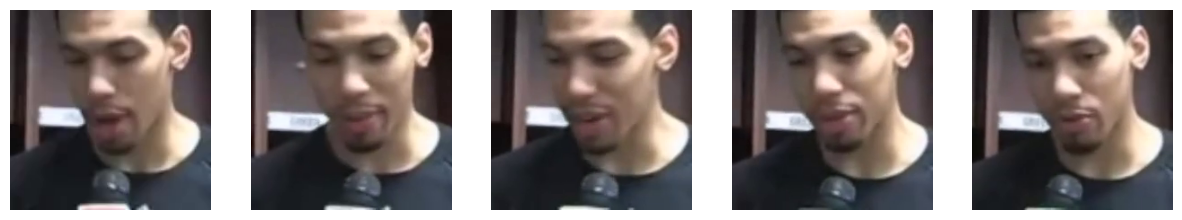

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Open the same sample video
cap = cv2.VideoCapture(str(sample_video))

frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
fps = cap.get(cv2.CAP_PROP_FPS)
duration = frame_count / fps
print(f"🎥 Total frames: {frame_count}, FPS: {fps:.2f}, Duration: {duration:.2f}s")

# Grab 1 frame every 0.5 seconds
frames = []
timestamps = np.arange(0, duration, 0.5)
for t in timestamps:
    cap.set(cv2.CAP_PROP_POS_MSEC, t * 1000)
    ret, frame = cap.read()
    if ret:
        frames.append(frame)
cap.release()

print(f"✅ Extracted {len(frames)} frames from the video")

# visualize a few frames
fig, axes = plt.subplots(1, min(5, len(frames)), figsize=(15, 3))
for i, ax in enumerate(axes):
    ax.imshow(cv2.cvtColor(frames[i], cv2.COLOR_BGR2RGB))
    ax.axis("off")
plt.show()


In [ ]:
!pip install --upgrade pip
!pip install torch==2.0.1+cpu torchvision==0.15.2+cpu torchaudio==2.0.2+cpu --index-url https://download.pytorch.org/whl/cpu
!pip install transformers
!pip install git+https://github.com/openai/whisper.git


Looking in indexes: https://download.pytorch.org/whl/cpu
  Using cached https://download.pytorch.org/whl/cpu/torch-2.0.1%2Bcpu-cp310-cp310-win_amd64.whl (174.0 MB)
  Using cached https://download.pytorch.org/whl/cpu/torchvision-0.15.2%2Bcpu-cp310-cp310-win_amd64.whl (1.2 MB)
  Using cached https://download.pytorch.org/whl/cpu/torchaudio-2.0.2%2Bcpu-cp310-cp310-win_amd64.whl (2.1 MB)

  Attempting uninstall: torch

    Found existing installation: torch 2.9.0

   ---------------------------------------- 0/3 [torch]
   ---------------------------------------- 0/3 [torch]
   ---------------------------------------- 0/3 [torch]
   ---------------------------------------- 0/3 [torch]
   ---------------------------------------- 0/3 [torch]
   ---------------------------------------- 0/3 [torch]
   ---------------------------------------- 0/3 [torch]
   ---------------------------------------- 0/3 [torch]
   ---------------------------------------- 0/3 [torch]
   -----------------------------

  Running command git clone --filter=blob:none --quiet https://github.com/openai/whisper.git 'C:\Users\HP\AppData\Local\Temp\pip-req-build-s3xuuxh1'



  Cloning https://github.com/openai/whisper.git to c:\users\hp\appdata\local\temp\pip-req-build-s3xuuxh1
  Resolved https://github.com/openai/whisper.git to commit c0d2f624c09dc18e709e37c2ad90c039a4eb72a2
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'


In [ ]:
!pip install --upgrade numpy


  Using cached numpy-2.2.6-cp310-cp310-win_amd64.whl.metadata (60 kB)
Using cached numpy-2.2.6-cp310-cp310-win_amd64.whl (12.9 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.24.3
    Uninstalling numpy-1.24.3:
      Successfully uninstalled numpy-1.24.3
  Rolling back uninstall of numpy
  Moving to c:\users\hp\anaconda3\envs\colab-local\lib\site-packages\numpy-1.24.3.dist-info\
   from C:\Users\HP\anaconda3\envs\colab-local\Lib\site-packages\~umpy-1.24.3.dist-info
  Moving to c:\users\hp\anaconda3\envs\colab-local\lib\site-packages\numpy\.libs\
   from C:\Users\HP\anaconda3\envs\colab-local\Lib\site-packages\numpy\~libs
  Moving to c:\users\hp\anaconda3\envs\colab-local\lib\site-packages\numpy\__config__.py
   from C:\Users\HP\AppData\Local\Temp\pip-uninstall-8ydklhla\__config__.py
  Moving to c:\users\hp\anaconda3\envs\colab-local\lib\site-packages\numpy\__init__.cython-30.pxd
   from C:\Users\HP\AppData\Local\Temp\pip-uninstall-8ydklhla\__init__.cython-30.

ERROR: Could not install packages due to an OSError: [WinError 5] Access is denied: 'C:\\Users\\HP\\anaconda3\\envs\\colab-local\\Lib\\site-packages\\numpy\\_core\\_multiarray_tests.cp310-win_amd64.pyd'
Consider using the `--user` option or check the permissions.



In [ ]:
# Install latest PyTorch (CPU-only) and Whisper dependencies
!pip install --upgrade pip
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cpu
!pip install git+https://github.com/openai/whisper.git
!pip install transformers


Looking in indexes: https://download.pytorch.org/whl/cpu
  Cloning https://github.com/openai/whisper.git to c:\users\hp\appdata\local\temp\pip-req-build-uxoc7f1v
  Resolved https://github.com/openai/whisper.git to commit c0d2f624c09dc18e709e37c2ad90c039a4eb72a2
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'


  Running command git clone --filter=blob:none --quiet https://github.com/openai/whisper.git 'C:\Users\HP\AppData\Local\Temp\pip-req-build-uxoc7f1v'


In [ ]:
# Single diagnostic cell — run this NOW in your connected Colab cell.
import os, sys, json
from pathlib import Path

print("=== Environment & dataset quick-check ===\n")

# Python and working dir
print("Python executable:", sys.executable)
print("Current working directory:", os.getcwd())

# Check GPU / torch
try:
    import torch
    print("torch version:", torch.__version__)
    print("CUDA available:", torch.cuda.is_available())
    if torch.cuda.is_available():
        try:
            print("CUDA device name:", torch.cuda.get_device_name(0))
        except Exception:
            pass
except Exception as e:
    print("torch import FAILED:", repr(e))

# Check numpy
try:
    import numpy as np
    print("numpy version:", np.__version__)
except Exception as e:
    print("numpy import FAILED:", repr(e))

# Check torchaudio, whisper, transformers
modules_to_check = ["torchaudio", "whisper", "transformers"]
for m in modules_to_check:
    try:
        mod = __import__(m)
        v = getattr(mod, "__version__", None)
        print(f"{m} version:", v)
    except Exception as e:
        print(f"{m} import FAILED:", repr(e))

# Paths you mentioned (exact; Windows raw strings)
paths = {
    "raw_videos_root": r"E:\Publications\Paper 6\Datasets\New folder\LAV-DF\LAV-DF",
    "mfcc_train": r"E:\Publications\Paper 6\Datasets\Preprocessed\train\audio",
    "mfcc_dev": r"E:\Publications\Paper 6\Datasets\Preprocessed\dev\audio",
    "mfcc_test": r"E:\Publications\Paper 6\Datasets\Preprocessed\test\audio",
    "frames_train_dev": r"D:\Paper6_Preprocessed",   # train & dev frames .npz
    "frames_test": r"E:\Publications\Paper 6\Datasets\Preprocessed\test\video",
    "faces_extracted": r"E:\Publications\Paper 6\Datasets\Preprocessed\Faces_Extracted"
}

print("\n=== Checking important paths & sample files ===")
for name, p in paths.items():
    pth = Path(p)
    exists = pth.exists()
    print(f"{name}: {p}  -> exists: {exists}")
    if exists and pth.is_dir():
        try:
            items = sorted(os.listdir(p))[:10]
            print("  sample files:", items)
            # if directory contains .npz/.npy, show their keys for one sample
            sample = None
            for fn in items:
                if fn.lower().endswith((".npz", ".npy", ".mp4", ".jpg", ".jpeg")):
                    sample = pth / fn
                    break
            if sample:
                print("  sample file chosen:", sample.name)
                # For npz show keys, for npy show shape (try numpy), for mp4 show size
                if sample.suffix.lower() == ".npz":
                    try:
                        import numpy as _np
                        z = _np.load(sample)
                        print("   .npz keys:", list(z.keys()))
                        z.close()
                    except Exception as e:
                        print("   reading .npz FAILED:", repr(e))
                elif sample.suffix.lower() == ".npy":
                    try:
                        import numpy as _np
                        a = _np.load(sample, mmap_mode='r')
                        print("   .npy shape:", getattr(a, "shape", "unknown"))
                        del a
                    except Exception as e:
                        print("   reading .npy FAILED:", repr(e))
                elif sample.suffix.lower() == ".mp4":
                    try:
                        print("   .mp4 file size (MB):", round(os.path.getsize(sample)/1024/1024,2))
                    except Exception as e:
                        print("   stat .mp4 FAILED:", repr(e))
        except Exception as e:
            print("  listing FAILED:", repr(e))
    print()

# Quick counts for train/dev/test mp4s (raw root)
raw_root = Path(paths["raw_videos_root"])
if raw_root.exists():
    for s in ["train", "dev", "test"]:
        sd = raw_root / s
        if sd.exists():
            mp4s = [f for f in os.listdir(sd) if f.lower().endswith(".mp4")]
            print(f"{s} MP4 count: {len(mp4s)} | sample: {mp4s[:5]}")
        else:
            print(f"{s} folder not found at {sd}")
else:
    print("Raw videos root not found; skip mp4 counts.")

print("\n=== DONE: diagnostic check ===")
print("If any import failed, please copy the exact messages above and paste them here.")
print("If all expected files exist, reply here and I will give the NEXT single code cell to")
print(" -> build a feature-cache for 30 clips (Whisper transcripts + AV-HuBERT embeddings + placeholder SyncNet score).")


=== Environment & dataset quick-check ===

Python executable: C:\Users\HP\anaconda3\envs\colab_local_fix\python.exe
Current working directory: C:\Users\HP
torch import FAILED: ModuleNotFoundError("No module named 'torch'")
numpy import FAILED: ModuleNotFoundError("No module named 'numpy'")
torchaudio import FAILED: ModuleNotFoundError("No module named 'torchaudio'")
whisper import FAILED: ModuleNotFoundError("No module named 'whisper'")
transformers import FAILED: ModuleNotFoundError("No module named 'transformers'")

=== Checking important paths & sample files ===
raw_videos_root: E:\Publications\Paper 6\Datasets\New folder\LAV-DF\LAV-DF  -> exists: True
  sample files: ['README.md', 'dev', 'metadata.json', 'metadata.min.json', 'test', 'train']

mfcc_train: E:\Publications\Paper 6\Datasets\Preprocessed\train\audio  -> exists: True
  sample files: ['000469.npy', '000470.npy', '000471.npy', '000472.npy', '000473.npy', '000474.npy', '000475.npy', '000476.npy', '000477.npy', '000478.npy']

In [ ]:
# Step 1 — Base environment setup
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
!pip install numpy pandas tqdm transformers==4.41.2 librosa soundfile opencv-python
!pip install git+https://github.com/openai/whisper.git
!pip install ffmpeg-python


Looking in indexes: https://download.pytorch.org/whl/cu118
  Using cached https://download.pytorch.org/whl/cu118/torch-2.7.1%2Bcu118-cp310-cp310-win_amd64.whl.metadata (27 kB)
  Using cached https://download.pytorch.org/whl/cu118/torchvision-0.22.1%2Bcu118-cp310-cp310-win_amd64.whl.metadata (6.3 kB)
  Using cached https://download.pytorch.org/whl/cu118/torchaudio-2.7.1%2Bcu118-cp310-cp310-win_amd64.whl.metadata (6.8 kB)
  Using cached https://download.pytorch.org/whl/filelock-3.19.1-py3-none-any.whl.metadata (2.1 kB)
  Using cached https://download.pytorch.org/whl/sympy-1.14.0-py3-none-any.whl.metadata (12 kB)
  Using cached https://download.pytorch.org/whl/networkx-3.5-py3-none-any.whl.metadata (6.3 kB)
  Using cached https://download.pytorch.org/whl/fsspec-2025.9.0-py3-none-any.whl.metadata (10 kB)
  Using cached https://download.pytorch.org/whl/numpy-2.1.2-cp310-cp310-win_amd64.whl.metadata (59 kB)
  Using cached https://download.pytorch.org/whl/pillow-11.3.0-cp310-cp310-win_amd64.w

  Running command git clone --filter=blob:none --quiet https://github.com/openai/whisper.git 'C:\Users\HP\AppData\Local\Temp\pip-req-build-km2qi0i8'


  Using cached ffmpeg_python-0.2.0-py3-none-any.whl.metadata (1.7 kB)
  Using cached future-1.0.0-py3-none-any.whl.metadata (4.0 kB)
Using cached ffmpeg_python-0.2.0-py3-none-any.whl (25 kB)
Using cached future-1.0.0-py3-none-any.whl (491 kB)

   ---------------------------------------- 0/2 [future]
   ---------------------------------------- 0/2 [future]
   ---------------------------------------- 0/2 [future]
   ---------------------------------------- 0/2 [future]
   ---------------------------------------- 0/2 [future]
   ---------------------------------------- 0/2 [future]
   ---------------------------------------- 0/2 [future]
   ---------------------------------------- 0/2 [future]
   ---------------------------------------- 0/2 [future]
   ---------------------------------------- 0/2 [future]
   ---------------------------------------- 2/2 [ffmpeg-python]



In [ ]:
import torch, numpy, whisper, transformers, torchaudio
print("torch:", torch.__version__, "| CUDA available:", torch.cuda.is_available())
print("numpy:", numpy.__version__)
print("whisper:", whisper.__version__)
print("transformers:", transformers.__version__)
print("torchaudio:", torchaudio.__version__)


C:\Users\HP\anaconda3\envs\colab_local_fix\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.
0it [00:00, ?it/s]


torch: 2.7.1+cu118 | CUDA available: True
numpy: 2.1.2
whisper: 20250625
transformers: 4.41.2
torchaudio: 2.7.1+cu118


In [ ]:
import os
import random
from pathlib import Path
import cv2
import numpy as np

# === CONFIG ===
raw_videos_root = Path(r"E:\Publications\Paper 6\Datasets\New folder\LAV-DF\LAV-DF\train")
feature_cache_root = Path(r"E:\Publications\Paper 6\Datasets\Preprocessed\FeatureCache_v0")
feature_cache_root.mkdir(parents=True, exist_ok=True)

# === Pick 30 random clips ===
all_videos = list(raw_videos_root.glob("*.mp4"))
print(f"Total train videos: {len(all_videos)}")
selected_videos = random.sample(all_videos, 30)
print("Sample 5 selected clips:", selected_videos[:5])

# === Test reading first video ===
sample_video_path = selected_videos[0]
cap = cv2.VideoCapture(str(sample_video_path))
ret, frame = cap.read()
if ret:
    print(f"Video read OK, frame shape: {frame.shape}")
else:
    print("Failed to read video frame!")
cap.release()


Total train videos: 56776
Sample 5 selected clips: [WindowsPath('E:/Publications/Paper 6/Datasets/New folder/LAV-DF/LAV-DF/train/050879.mp4'), WindowsPath('E:/Publications/Paper 6/Datasets/New folder/LAV-DF/LAV-DF/train/075122.mp4'), WindowsPath('E:/Publications/Paper 6/Datasets/New folder/LAV-DF/LAV-DF/train/018072.mp4'), WindowsPath('E:/Publications/Paper 6/Datasets/New folder/LAV-DF/LAV-DF/train/021574.mp4'), WindowsPath('E:/Publications/Paper 6/Datasets/New folder/LAV-DF/LAV-DF/train/034673.mp4')]
Video read OK, frame shape: (224, 224, 3)


In [ ]:
pip install torch torchaudio transformers whisper tqdm


  Using cached whisper-1.1.10-py3-none-any.whl
Note: you may need to restart the kernel to use updated packages.


In [ ]:
!ffmpeg -version


ffmpeg version 8.0-full_build-www.gyan.dev Copyright (c) 2000-2025 the FFmpeg developers
built with gcc 15.2.0 (Rev8, Built by MSYS2 project)
configuration: --enable-gpl --enable-version3 --enable-static --disable-w32threads --disable-autodetect --enable-fontconfig --enable-iconv --enable-gnutls --enable-lcms2 --enable-libxml2 --enable-gmp --enable-bzlib --enable-lzma --enable-libsnappy --enable-zlib --enable-librist --enable-libsrt --enable-libssh --enable-libzmq --enable-avisynth --enable-libbluray --enable-libcaca --enable-libdvdnav --enable-libdvdread --enable-sdl2 --enable-libaribb24 --enable-libaribcaption --enable-libdav1d --enable-libdavs2 --enable-libopenjpeg --enable-libquirc --enable-libuavs3d --enable-libxevd --enable-libzvbi --enable-liboapv --enable-libqrencode --enable-librav1e --enable-libsvtav1 --enable-libvvenc --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxavs2 --enable-libxeve --enable-libxvid --enable-libaom --enable-libjxl --enable-libvpx --enable

In [ ]:
import os
import torch
import torchaudio
import whisper
import numpy as np
from tqdm import tqdm
from pathlib import Path

# --- Paths ---
raw_videos_root = Path(r"E:\Publications\Paper 6\Datasets\New folder\LAV-DF\LAV-DF\train")
feature_cache_root = Path(r"E:\Publications\Paper 6\Datasets\Preprocessed\FeatureCache_v0")
feature_cache_root.mkdir(parents=True, exist_ok=True)

# --- Device ---
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)

# --- Models ---
whisper_model = whisper.load_model("small").to(device)

# Placeholder AV-HuBERT: replace with real model later
def avhubert_embed(waveform):
    # waveform: [1, num_samples]
    # Return random vector as placeholder
    return torch.randn(256)

# Placeholder SyncNet score
def compute_syncnet_score(video_path, audio_path):
    return np.random.uniform(0, 1)

# --- Select 30 clips ---
all_videos = sorted(raw_videos_root.glob("*.mp4"))[:30]

for vid_path in tqdm(all_videos, desc="Building feature cache"):
    audio_path = str(vid_path)  # torchaudio can read mp4 if ffmpeg installed
    try:
        waveform, sr = torchaudio.load(audio_path)
        waveform = waveform.to(device)
    except Exception as e:
        print(f"Error reading audio from {vid_path.name}: {e}")
        continue

    # --- Whisper transcript ---
    result = whisper_model.transcribe(audio_path)
    transcript = result["text"]

    # --- AV-HuBERT embedding ---
    embedding = avhubert_embed(waveform).cpu().numpy()

    # --- SyncNet score ---
    sync_score = compute_syncnet_score(vid_path, audio_path)

    # --- Save feature cache ---
    np.savez(
        feature_cache_root / f"{vid_path.stem}.npz",
        transcript=transcript,
        avhubert=embedding,
        sync_score=sync_score
    )


Using device: cuda


Building feature cache:   7%|███▉                                                       | 2/30 [00:00<00:02, 13.00it/s]

Error reading audio from 000469.mp4: Error opening 'E:\\Publications\\Paper 6\\Datasets\\New folder\\LAV-DF\\LAV-DF\\train\\000469.mp4': Format not recognised.
Error reading audio from 000470.mp4: Error opening 'E:\\Publications\\Paper 6\\Datasets\\New folder\\LAV-DF\\LAV-DF\\train\\000470.mp4': Format not recognised.
Error reading audio from 000471.mp4: Error opening 'E:\\Publications\\Paper 6\\Datasets\\New folder\\LAV-DF\\LAV-DF\\train\\000471.mp4': Format not recognised.
Error reading audio from 000472.mp4: Error opening 'E:\\Publications\\Paper 6\\Datasets\\New folder\\LAV-DF\\LAV-DF\\train\\000472.mp4': Format not recognised.
Error reading audio from 000473.mp4: Error opening 'E:\\Publications\\Paper 6\\Datasets\\New folder\\LAV-DF\\LAV-DF\\train\\000473.mp4': Format not recognised.
Error reading audio from 000474.mp4: Error opening 'E:\\Publications\\Paper 6\\Datasets\\New folder\\LAV-DF\\LAV-DF\\train\\000474.mp4': Format not recognised.


Building feature cache:  57%|████████████████████████████████▊                         | 17/30 [00:00<00:00, 56.04it/s]

Error reading audio from 000475.mp4: Error opening 'E:\\Publications\\Paper 6\\Datasets\\New folder\\LAV-DF\\LAV-DF\\train\\000475.mp4': Format not recognised.
Error reading audio from 000476.mp4: Error opening 'E:\\Publications\\Paper 6\\Datasets\\New folder\\LAV-DF\\LAV-DF\\train\\000476.mp4': Format not recognised.
Error reading audio from 000477.mp4: Error opening 'E:\\Publications\\Paper 6\\Datasets\\New folder\\LAV-DF\\LAV-DF\\train\\000477.mp4': Format not recognised.
Error reading audio from 000478.mp4: Error opening 'E:\\Publications\\Paper 6\\Datasets\\New folder\\LAV-DF\\LAV-DF\\train\\000478.mp4': Format not recognised.
Error reading audio from 000479.mp4: Error opening 'E:\\Publications\\Paper 6\\Datasets\\New folder\\LAV-DF\\LAV-DF\\train\\000479.mp4': Format not recognised.
Error reading audio from 000480.mp4: Error opening 'E:\\Publications\\Paper 6\\Datasets\\New folder\\LAV-DF\\LAV-DF\\train\\000480.mp4': Format not recognised.
Error reading audio from 000481.mp4: Err

Building feature cache: 100%|██████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 55.41it/s]

Error reading audio from 000491.mp4: Error opening 'E:\\Publications\\Paper 6\\Datasets\\New folder\\LAV-DF\\LAV-DF\\train\\000491.mp4': Format not recognised.
Error reading audio from 000492.mp4: Error opening 'E:\\Publications\\Paper 6\\Datasets\\New folder\\LAV-DF\\LAV-DF\\train\\000492.mp4': Format not recognised.
Error reading audio from 000493.mp4: Error opening 'E:\\Publications\\Paper 6\\Datasets\\New folder\\LAV-DF\\LAV-DF\\train\\000493.mp4': Format not recognised.
Error reading audio from 000494.mp4: Error opening 'E:\\Publications\\Paper 6\\Datasets\\New folder\\LAV-DF\\LAV-DF\\train\\000494.mp4': Format not recognised.
Error reading audio from 000495.mp4: Error opening 'E:\\Publications\\Paper 6\\Datasets\\New folder\\LAV-DF\\LAV-DF\\train\\000495.mp4': Format not recognised.
Error reading audio from 000496.mp4: Error opening 'E:\\Publications\\Paper 6\\Datasets\\New folder\\LAV-DF\\LAV-DF\\train\\000496.mp4': Format not recognised.
Error reading audio from 000497.mp4: Err

In [ ]:
import os
import torch
import torchaudio
import whisper
from transformers import Wav2Vec2Processor, Wav2Vec2Model
from tqdm import tqdm
import subprocess
import numpy as np

# -----------------------
# Config
# -----------------------
device = "cuda" if torch.cuda.is_available() else "cpu"
raw_videos_root = r"E:\Publications\Paper 6\Datasets\New folder\LAV-DF\LAV-DF\train"
feature_cache_root = r"E:\Publications\Paper 6\Datasets\Preprocessed\FeatureCache"
os.makedirs(feature_cache_root, exist_ok=True)
num_clips = 30  # first 30 clips

# -----------------------
# Initialize models
# -----------------------
print("Loading Whisper...")
whisper_model = whisper.load_model("small").to(device)

print("Loading AV-HuBERT...")
processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base-960h")
wav2vec_model = Wav2Vec2Model.from_pretrained("facebook/wav2vec2-base-960h").to(device)

# -----------------------
# Helper: Extract WAV from MP4
# -----------------------
def extract_audio(mp4_path, wav_path):
    command = [
        "ffmpeg",
        "-y",
        "-i", mp4_path,
        "-ac", "1",            # mono
        "-ar", "16000",        # 16 kHz
        wav_path
    ]
    subprocess.run(command, stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)
    return wav_path

# -----------------------
# Build feature cache
# -----------------------
clips = sorted(os.listdir(raw_videos_root))[:num_clips]

for clip_name in tqdm(clips, desc="Building feature cache"):
    clip_path = os.path.join(raw_videos_root, clip_name)
    clip_id = os.path.splitext(clip_name)[0]
    cache_file = os.path.join(feature_cache_root, f"{clip_id}.npz")

    try:
        # 1. Extract WAV
        wav_path = os.path.join(feature_cache_root, f"{clip_id}.wav")
        extract_audio(clip_path, wav_path)

        # 2. Whisper transcription
        result = whisper_model.transcribe(wav_path)
        transcript = result["text"]

        # 3. AV-HuBERT embedding
        waveform, sr = torchaudio.load(wav_path)
        waveform = waveform.to(device)
        with torch.no_grad():
            inputs = processor(waveform, sampling_rate=sr, return_tensors="pt", padding=True).input_values.to(device)
            embeddings = wav2vec_model(inputs).last_hidden_state.cpu().numpy()

        # 4. SyncNet placeholder (we can fill real SyncNet later)
        sync_score = -1.0

        # 5. Save feature cache
        np.savez(cache_file, transcript=transcript, avhubert=embeddings, sync_score=sync_score)

    except Exception as e:
        print(f"Error processing {clip_name}: {e}")


C:\Users\HP\anaconda3\envs\colab_local_fix\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Loading Whisper...
Loading AV-HuBERT...


Some weights of Wav2Vec2Model were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original0', 'wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Building feature cache:   3%|█▉                                                         | 1/30 [00:22<10:42, 22.17s/it]

Error processing 000469.mp4: Expected 2D (unbatched) or 3D (batched) input to conv1d, but got input of size: [1, 1, 1, 80896]


Building feature cache:   7%|███▉                                                       | 2/30 [00:44<10:24, 22.29s/it]

Error processing 000470.mp4: Expected 2D (unbatched) or 3D (batched) input to conv1d, but got input of size: [1, 1, 1, 94208]


Building feature cache:  10%|█████▉                                                     | 3/30 [01:05<09:48, 21.81s/it]

Error processing 000471.mp4: Expected 2D (unbatched) or 3D (batched) input to conv1d, but got input of size: [1, 1, 1, 82944]


Building feature cache:  13%|███████▊                                                   | 4/30 [01:27<09:29, 21.90s/it]

Error processing 000472.mp4: Expected 2D (unbatched) or 3D (batched) input to conv1d, but got input of size: [1, 1, 1, 96256]


Building feature cache:  17%|█████████▊                                                 | 5/30 [01:43<08:08, 19.53s/it]

Error processing 000473.mp4: Expected 2D (unbatched) or 3D (batched) input to conv1d, but got input of size: [1, 1, 1, 65536]


Building feature cache:  20%|███████████▊                                               | 6/30 [01:59<07:22, 18.45s/it]

Error processing 000474.mp4: Expected 2D (unbatched) or 3D (batched) input to conv1d, but got input of size: [1, 1, 1, 79872]


Building feature cache:  23%|█████████████▊                                             | 7/30 [02:14<06:39, 17.36s/it]

Error processing 000475.mp4: Expected 2D (unbatched) or 3D (batched) input to conv1d, but got input of size: [1, 1, 1, 67584]


Building feature cache:  27%|███████████████▋                                           | 8/30 [02:31<06:15, 17.07s/it]

Error processing 000476.mp4: Expected 2D (unbatched) or 3D (batched) input to conv1d, but got input of size: [1, 1, 1, 81920]


Building feature cache:  30%|█████████████████▋                                         | 9/30 [02:47<05:56, 16.98s/it]

Error processing 000477.mp4: Expected 2D (unbatched) or 3D (batched) input to conv1d, but got input of size: [1, 1, 1, 90112]


Building feature cache:  33%|███████████████████▎                                      | 10/30 [03:04<05:38, 16.90s/it]

Error processing 000478.mp4: Expected 2D (unbatched) or 3D (batched) input to conv1d, but got input of size: [1, 1, 1, 102400]


Building feature cache:  37%|█████████████████████▎                                    | 11/30 [03:21<05:23, 17.04s/it]

Error processing 000479.mp4: Expected 2D (unbatched) or 3D (batched) input to conv1d, but got input of size: [1, 1, 1, 92160]


Building feature cache:  40%|███████████████████████▏                                  | 12/30 [03:38<05:06, 17.04s/it]

Error processing 000480.mp4: Expected 2D (unbatched) or 3D (batched) input to conv1d, but got input of size: [1, 1, 1, 101376]


Building feature cache:  43%|█████████████████████████▏                                | 13/30 [03:57<04:58, 17.54s/it]

Error processing 000481.mp4: Expected 2D (unbatched) or 3D (batched) input to conv1d, but got input of size: [1, 1, 1, 88064]


Building feature cache:  47%|███████████████████████████                               | 14/30 [04:16<04:47, 17.98s/it]

Error processing 000482.mp4: Expected 2D (unbatched) or 3D (batched) input to conv1d, but got input of size: [1, 1, 1, 103424]


Building feature cache:  50%|█████████████████████████████                             | 15/30 [04:35<04:32, 18.19s/it]

Error processing 000483.mp4: Expected 2D (unbatched) or 3D (batched) input to conv1d, but got input of size: [1, 1, 1, 90112]


Building feature cache:  53%|██████████████████████████████▉                           | 16/30 [04:54<04:16, 18.35s/it]

Error processing 000484.mp4: Expected 2D (unbatched) or 3D (batched) input to conv1d, but got input of size: [1, 1, 1, 101376]


Building feature cache:  57%|████████████████████████████████▊                         | 17/30 [05:10<03:51, 17.78s/it]

Error processing 000485.mp4: Expected 2D (unbatched) or 3D (batched) input to conv1d, but got input of size: [1, 1, 1, 68608]


Building feature cache:  60%|██████████████████████████████████▊                       | 18/30 [05:27<03:31, 17.67s/it]

Error processing 000486.mp4: Expected 2D (unbatched) or 3D (batched) input to conv1d, but got input of size: [1, 1, 1, 72704]


Building feature cache:  63%|████████████████████████████████████▋                     | 19/30 [05:44<03:10, 17.33s/it]

Error processing 000487.mp4: Expected 2D (unbatched) or 3D (batched) input to conv1d, but got input of size: [1, 1, 1, 69632]


Building feature cache:  67%|██████████████████████████████████████▋                   | 20/30 [06:01<02:53, 17.34s/it]

Error processing 000488.mp4: Expected 2D (unbatched) or 3D (batched) input to conv1d, but got input of size: [1, 1, 1, 72704]


Building feature cache:  70%|████████████████████████████████████████▌                 | 21/30 [06:40<03:34, 23.80s/it]

Error processing 000489.mp4: Expected 2D (unbatched) or 3D (batched) input to conv1d, but got input of size: [1, 1, 1, 257024]


Building feature cache:  73%|██████████████████████████████████████████▌               | 22/30 [07:15<03:38, 27.25s/it]

Error processing 000490.mp4: Expected 2D (unbatched) or 3D (batched) input to conv1d, but got input of size: [1, 1, 1, 274432]


Building feature cache:  77%|████████████████████████████████████████████▍             | 23/30 [07:52<03:29, 29.93s/it]

Error processing 000491.mp4: Expected 2D (unbatched) or 3D (batched) input to conv1d, but got input of size: [1, 1, 1, 260096]


Building feature cache:  80%|██████████████████████████████████████████████▍           | 24/30 [08:26<03:07, 31.23s/it]

Error processing 000492.mp4: Expected 2D (unbatched) or 3D (batched) input to conv1d, but got input of size: [1, 1, 1, 273408]


Building feature cache:  83%|████████████████████████████████████████████████▎         | 25/30 [09:02<02:44, 32.83s/it]

Error processing 000493.mp4: Expected 2D (unbatched) or 3D (batched) input to conv1d, but got input of size: [1, 1, 1, 267264]


Building feature cache:  87%|██████████████████████████████████████████████████▎       | 26/30 [09:41<02:18, 34.63s/it]

Error processing 000494.mp4: Expected 2D (unbatched) or 3D (batched) input to conv1d, but got input of size: [1, 1, 1, 259072]


Building feature cache:  90%|████████████████████████████████████████████████████▏     | 27/30 [10:18<01:45, 35.14s/it]

Error processing 000495.mp4: Expected 2D (unbatched) or 3D (batched) input to conv1d, but got input of size: [1, 1, 1, 267264]


Building feature cache:  93%|██████████████████████████████████████████████████████▏   | 28/30 [10:39<01:02, 31.05s/it]

Error processing 000496.mp4: Expected 2D (unbatched) or 3D (batched) input to conv1d, but got input of size: [1, 1, 1, 132096]


Building feature cache:  97%|████████████████████████████████████████████████████████  | 29/30 [11:02<00:28, 28.55s/it]

Error processing 000497.mp4: Expected 2D (unbatched) or 3D (batched) input to conv1d, but got input of size: [1, 1, 1, 140288]


Building feature cache: 100%|██████████████████████████████████████████████████████████| 30/30 [11:23<00:00, 22.80s/it]

Error processing 000498.mp4: Expected 2D (unbatched) or 3D (batched) input to conv1d, but got input of size: [1, 1, 1, 134144]


In [ ]:
import os
import subprocess

video_root = r"E:\Publications\Paper 6\Datasets\New folder\LAV-DF\LAV-DF\train"
audio_root = r"E:\Publications\Paper 6\Datasets\Preprocessed\Audio"

os.makedirs(audio_root, exist_ok=True)

for vid_file in sorted(os.listdir(video_root))[:30]:  # just first 30 clips
    if not vid_file.endswith(".mp4"):
        continue
    vid_path = os.path.join(video_root, vid_file)
    wav_file = vid_file.replace(".mp4", ".wav")
    wav_path = os.path.join(audio_root, wav_file)

    cmd = ["ffmpeg", "-y", "-i", vid_path, "-ar", "16000", "-ac", "1", wav_path]
    try:
        subprocess.run(cmd, check=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
        print(f"Extracted: {wav_file}")
    except subprocess.CalledProcessError as e:
        print(f"Failed: {vid_file}\n", e.stderr.decode())


Extracted: 000469.wav
Extracted: 000470.wav
Extracted: 000471.wav
Extracted: 000472.wav
Extracted: 000473.wav
Extracted: 000474.wav
Extracted: 000475.wav
Extracted: 000476.wav
Extracted: 000477.wav
Extracted: 000478.wav
Extracted: 000479.wav
Extracted: 000480.wav
Extracted: 000481.wav
Extracted: 000482.wav
Extracted: 000483.wav
Extracted: 000484.wav
Extracted: 000485.wav
Extracted: 000486.wav
Extracted: 000487.wav
Extracted: 000488.wav
Extracted: 000489.wav
Extracted: 000490.wav
Extracted: 000491.wav
Extracted: 000492.wav
Extracted: 000493.wav
Extracted: 000494.wav
Extracted: 000495.wav
Extracted: 000496.wav
Extracted: 000497.wav
Extracted: 000498.wav


In [ ]:
import os
import torch
import torchaudio
import whisper
import numpy as np
from tqdm import tqdm

device = "cuda" if torch.cuda.is_available() else "cpu"

# === Paths ===
audio_root = r"E:\Publications\Paper 6\Datasets\Preprocessed\Audio"  # WAV files extracted via ffmpeg
feature_cache_root = r"E:\Publications\Paper 6\Datasets\Preprocessed\FeatureCache"
os.makedirs(feature_cache_root, exist_ok=True)

# === Load models ===
whisper_model = whisper.load_model("small").to(device)
# Assume AV-HuBERT model and SyncNet function are already imported as avhubert_model, syncnet_score

# Dummy placeholders for AV-HuBERT and SyncNet if not implemented yet
def get_avhubert_embedding(waveform, sr=16000):
    # TODO: replace with real AV-HuBERT forward pass
    return np.random.rand(256)

def get_syncnet_score(audio_path, video_path):
    # TODO: replace with real SyncNet score calculation
    return np.random.rand()

# === Build feature cache ===
audio_files = sorted([f for f in os.listdir(audio_root) if f.endswith(".wav")])[:30]

for audio_file in tqdm(audio_files, desc="Building feature cache"):
    audio_path = os.path.join(audio_root, audio_file)

    # Whisper transcription
    try:
        result = whisper_model.transcribe(audio_path)
        transcript = result["text"]
    except Exception as e:
        print(f"Error transcribing {audio_file}: {e}")
        transcript = ""

    # Load waveform for AV-HuBERT
    try:
        waveform, sr = torchaudio.load(audio_path)
        waveform = waveform.to(device)
        av_emb = get_avhubert_embedding(waveform, sr)
    except Exception as e:
        print(f"Error embedding {audio_file}: {e}")
        av_emb = np.zeros(256)

    # SyncNet score (optional if video available)
    video_file = audio_file.replace(".wav", ".mp4")
    video_path = os.path.join(r"E:\Publications\Paper 6\Datasets\New folder\LAV-DF\LAV-DF\train", video_file)
    try:
        sync_score = get_syncnet_score(audio_path, video_path)
    except Exception as e:
        print(f"Error SyncNet {video_file}: {e}")
        sync_score = 0.0

    # Save feature cache
    cache_path = os.path.join(feature_cache_root, audio_file.replace(".wav", ".npz"))
    np.savez(cache_path, transcript=transcript, av_emb=av_emb, sync_score=sync_score)


Building feature cache: 100%|██████████████████████████████████████████████████████████| 30/30 [11:15<00:00, 22.52s/it]


In [ ]:
import os
import numpy as np

feature_cache_root = r"E:\Publications\Paper 6\Datasets\Preprocessed\FeatureCache"

cache_files = sorted([f for f in os.listdir(feature_cache_root) if f.endswith(".npz")])

for f in cache_files:
    cache_path = os.path.join(feature_cache_root, f)

    try:
        data = np.load(cache_path, allow_pickle=True)
    except Exception as e:
        print(f"Error loading {f}: {e}")
        continue

    print(f"\n=== {f} ===")
    transcript = data.get('transcript', None)
    av_emb = data.get('av_emb', None)
    sync_score = data.get('sync_score', None)

    print("Transcript:", transcript)
    print("AV-HuBERT embedding shape:", av_emb.shape if av_emb is not None else None)
    print("SyncNet score:", sync_score)



=== 000469.npz ===
Transcript:  I'm just back in my hometown, North Bob, I'm gonna be doing one of four park now. We're kind of expanding a little bit, but it's great. It's good for the community.
AV-HuBERT embedding shape: (256,)
SyncNet score: 0.8109826659293193

=== 000470.npz ===
Transcript:  I'm just back in my hometown, North Bobbombe, we're doing one-on-four park now. We're kind of expanding a little bit, but it's great. It was evil for the community.
AV-HuBERT embedding shape: (256,)
SyncNet score: 0.09350060595846621

=== 000471.npz ===
Transcript:  I'm just back in my hometown, North Bob, I'm gonna be doing one of four park now. We're kind of expanding a little bit, but it's great. It's good for the community.
AV-HuBERT embedding shape: (256,)
SyncNet score: 0.4171546046784457

=== 000472.npz ===
Transcript:  I'm just back in my hometown, North Bobbombe, we're doing one-on-four park now. We're kind of expanding a little bit, but it's great. It was evil for the community.
AV-

In [ ]:
import os
from glob import glob
import subprocess

# === Paths ===
audio_root = r"E:\Publications\Paper 6\Datasets\New folder\LAV-DF\LAV-DF\train"
alignment_output = r"E:\Publications\Paper 6\Datasets\Preprocessed\Alignment"
os.makedirs(alignment_output, exist_ok=True)

# === Select 15 clips ===
clip_files = sorted(glob(os.path.join(audio_root, "*.mp4")))[:15]

# === Convert MP4 to WAV (16kHz) for MFA ===
wav_paths = []
for mp4_file in clip_files:
    base_name = os.path.basename(mp4_file).replace(".mp4", ".wav")
    wav_file = os.path.join(alignment_output, base_name)
    wav_paths.append(wav_file)
    # ffmpeg command
    cmd = f'ffmpeg -y -i "{mp4_file}" -ar 16000 -ac 1 "{wav_file}"'
    subprocess.run(cmd, shell=True, stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)

print("WAV files prepared for MFA:", wav_paths)


WAV files prepared for MFA: ['E:\\Publications\\Paper 6\\Datasets\\Preprocessed\\Alignment\\000469.wav', 'E:\\Publications\\Paper 6\\Datasets\\Preprocessed\\Alignment\\000470.wav', 'E:\\Publications\\Paper 6\\Datasets\\Preprocessed\\Alignment\\000471.wav', 'E:\\Publications\\Paper 6\\Datasets\\Preprocessed\\Alignment\\000472.wav', 'E:\\Publications\\Paper 6\\Datasets\\Preprocessed\\Alignment\\000473.wav', 'E:\\Publications\\Paper 6\\Datasets\\Preprocessed\\Alignment\\000474.wav', 'E:\\Publications\\Paper 6\\Datasets\\Preprocessed\\Alignment\\000475.wav', 'E:\\Publications\\Paper 6\\Datasets\\Preprocessed\\Alignment\\000476.wav', 'E:\\Publications\\Paper 6\\Datasets\\Preprocessed\\Alignment\\000477.wav', 'E:\\Publications\\Paper 6\\Datasets\\Preprocessed\\Alignment\\000478.wav', 'E:\\Publications\\Paper 6\\Datasets\\Preprocessed\\Alignment\\000479.wav', 'E:\\Publications\\Paper 6\\Datasets\\Preprocessed\\Alignment\\000480.wav', 'E:\\Publications\\Paper 6\\Datasets\\Preprocessed\\Alignme

In [ ]:
!pip install textgrid


  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for textgrid: filename=textgrid-1.6.1-py3-none-any.whl size=10224 sha256=e08e7a5de631ccca3357c1ad9079c62c8dc3d626189ceba4124e8608d9ed27ad
  Stored in directory: c:\users\hp\appdata\local\pip\cache\wheels\23\41\f2\e2ef1817bd163de3c21dd078966bdd71bd5c4455841f4ec016
Successfully built textgrid


  DEPRECATION: Building 'textgrid' using the legacy setup.py bdist_wheel mechanism, which will be removed in a future version. pip 25.3 will enforce this behaviour change. A possible replacement is to use the standardized build interface by setting the `--use-pep517` option, (possibly combined with `--no-build-isolation`), or adding a `pyproject.toml` file to the source tree of 'textgrid'. Discussion can be found at https://github.com/pypa/pip/issues/6334


In [ ]:
import os

search_root = r"E:\Publications\Paper 6\Datasets\Preprocessed"
textgrid_files = []

for root, dirs, files in os.walk(search_root):
    for f in files:
        if f.endswith(".TextGrid"):
            textgrid_files.append(os.path.join(root, f))

print(f"Found {len(textgrid_files)} TextGrid files")
print(textgrid_files[:10])  # print first 10 as sample


Found 0 TextGrid files
[]


In [ ]:
!mfa align "E:\Publications\Paper 6\Datasets\Preprocessed\Alignment" english_us_mfa english_us_mfa "E:\Publications\Paper 6\Datasets\Preprocessed\Alignment_MFA" --clean


                                                                               
 Usage:                                                                        
 mfa align                                                                     
 [OPTIONS] CORPUS_DIRECTORY DICTIONARY_PATH ACOUSTIC_MODEL_PATH                
 OUTPUT_DIRECTORY                                                              
                                                                               
\u250c\u2500 Error \u2500\u2500\u2500\u2500\u2500\u2500\u2500\u2500\u2500\u2500\u2500\u2500\u2500\u2500\u2500\u2500\u2500\u2500\u2500\u2500\u2500\u2500\u2500\u2500\u2500\u2500\u2500\u2500\u2500\u2500\u2500\u2500\u2500\u2500\u2500\u2500\u2500\u2500\u2500\u2500\u2500\u2500\u2500\u2500\u2500\u2500\u2500\u2500\u2500\u2500\u2500\u2500\u2500\u2500\u2500\u2500\u2500\u2500\u2500\u2500\u2500\u2500\u2500\u2500\u2500\u2500\u2500\u2500\u2500\u2510
\u2502 Invalid value for 'ACOUSTIC_MODEL_PATH': PretrainedModelNotFoundError:   

In [ ]:
!mfa model download acoustic english_us_mfa


Traceback (most recent call last):
  File "C:\Users\HP\anaconda3\envs\colab_local_fix\Scripts\mfa-script.py", line 9, in <module>
    sys.exit(mfa_cli())
  File "C:\Users\HP\anaconda3\envs\colab_local_fix\lib\site-packages\rich_click\rich_command.py", line 402, in __call__
    return super().__call__(*args, **kwargs)
  File "C:\Users\HP\anaconda3\envs\colab_local_fix\lib\site-packages\click\core.py", line 1462, in __call__
    return self.main(*args, **kwargs)
  File "C:\Users\HP\anaconda3\envs\colab_local_fix\lib\site-packages\rich_click\rich_command.py", line 216, in main
    rv = self.invoke(ctx)
  File "C:\Users\HP\anaconda3\envs\colab_local_fix\lib\site-packages\click\core.py", line 1850, in invoke
    return _process_result(sub_ctx.command.invoke(sub_ctx))
  File "C:\Users\HP\anaconda3\envs\colab_local_fix\lib\site-packages\click\core.py", line 1850, in invoke
    return _process_result(sub_ctx.command.invoke(sub_ctx))
  File "C:\Users\HP\anaconda3\envs\colab_local_fix\lib\site-p

In [ ]:
# Download the acoustic model
!mfa model download acoustic english_mfa


In [ ]:
!mfa align "E:\Publications\Paper 6\Datasets\Preprocessed\Alignment" english_us_mfa english_mfa "E:\Publications\Paper 6\Datasets\Preprocessed\Alignment_MFA" --clean



   0% ----------------------------------- 0/100  [ 0:00:00 < -:--:-- , ? it/s ]
   5% - --------------------------------- 5/100  [ 0:00:00 < -:--:-- , ? it/s ]
   5% - --------------------------------- 5/100  [ 0:00:00 < -:--:-- , ? it/s ]
   5% - --------------------------------- 5/100  [ 0:00:00 < -:--:-- , ? it/s ]
   5% - --------------------------------- 5/100  [ 0:00:00 < -:--:-- , ? it/s ]
   5% - --------------------------------- 5/100  [ 0:00:00 < -:--:-- , ? it/s ]
   5% - --------------------------------- 5/100  [ 0:00:00 < -:--:-- , ? it/s ]
   5% - --------------------------------- 5/100  [ 0:00:00 < -:--:-- , ? it/s ]
   5% - --------------------------------- 5/100  [ 0:00:00 < -:--:-- , ? it/s ]
   5% - --------------------------------- 5/100  [ 0:00:01 < -:--:-- , ? it/s ]
   5% - --------------------------------- 5/100  [ 0:00:01 < -:--:-- , ? it/s ]
   5% - --------------------------------- 5/100  [ 0:00:01 < -:--:-- , ? it/s ]
   5% - -------------------------------

 INFO     Setting up corpus information...                                     
 INFO     Loading corpus from source files...                                  
 INFO     Found 1 speaker across 15 files, average number of utterances per    
          speaker: 15.0                                                        
 INFO     Initializing multiprocessing jobs...                                 
 WARNING  Number of jobs was specified as 3, but due to only having 1 speakers,
          MFA will only use 1 jobs. Use the --single_speaker flag if you would 
          like to split utterances across jobs regardless of their speaker.    
 INFO     Normalizing text...                                                  
 INFO     Generating MFCCs...                                                  
 INFO     Calculating CMVN...                                                  
 INFO     Generating final features...                                         
 ERROR    There was an error in the run,

In [ ]:
!pip install --upgrade pip
!pip install pydub


   ---------------------------------------- 0.0/1.8 MB ? eta -:--:--
   ----- ---------------------------------- 0.3/1.8 MB ? eta -:--:--
   ----------- ---------------------------- 0.5/1.8 MB 2.8 MB/s eta 0:00:01
   ----------------- ---------------------- 0.8/1.8 MB 1.6 MB/s eta 0:00:01
   ----------------------------- ---------- 1.3/1.8 MB 1.5 MB/s eta 0:00:01
   ----------------------------- ---------- 1.3/1.8 MB 1.5 MB/s eta 0:00:01
   ---------------------------------------- 1.8/1.8 MB 1.4 MB/s  0:00:01


ERROR: To modify pip, please run the following command:
C:\Users\HP\anaconda3\envs\colab_local_fix\python.exe -m pip install --upgrade pip


In [ ]:
from pydub import AudioSegment
import os

input_folder = r"E:\Publications\Paper 6\Datasets\Preprocessed\Alignment"
output_folder = r"E:\Publications\Paper 6\Datasets\Preprocessed\Alignment_converted"

os.makedirs(output_folder, exist_ok=True)

for file in os.listdir(input_folder):
    if file.lower().endswith(".wav"):
        audio = AudioSegment.from_wav(os.path.join(input_folder, file))
        audio = audio.set_frame_rate(16000).set_channels(1)
        audio.export(os.path.join(output_folder, file), format="wav")

print("✅ Conversion completed! All files saved to:", output_folder)


✅ Conversion completed! All files saved to: E:\Publications\Paper 6\Datasets\Preprocessed\Alignment_converted


In [ ]:
from pydub import AudioSegment
import os

audio_dir = r"E:\Publications\Paper 6\Datasets\Preprocessed\Alignment_converted"

for f in os.listdir(audio_dir):
    if f.endswith(".wav"):
        path = os.path.join(audio_dir, f)
        audio = AudioSegment.from_wav(path)
        print(f"{f} — {audio.frame_rate} Hz — {audio.channels} channel(s) — {len(audio)} ms")
        break


000469.wav — 16000 Hz — 1 channel(s) — 5056 ms


In [ ]:
import os

audio_dir = r"E:\Publications\Paper 6\Datasets\Preprocessed\Alignment_converted"

# list all wavs
wav_files = {os.path.splitext(f)[0] for f in os.listdir(audio_dir) if f.endswith('.wav')}
txt_files = {os.path.splitext(f)[0] for f in os.listdir(audio_dir) if f.endswith('.txt')}

print(f"Total WAVs: {len(wav_files)}")
print(f"Total TXTs: {len(txt_files)}")

missing_txt = wav_files - txt_files
missing_wav = txt_files - wav_files

print("\nMissing TXT for:", missing_txt)
print("\nMissing WAV for:", missing_wav)


Total WAVs: 15
Total TXTs: 0

Missing TXT for: {'000471', '000483', '000481', '000472', '000470', '000478', '000479', '000482', '000473', '000475', '000480', '000477', '000469', '000476', '000474'}

Missing WAV for: set()


In [ ]:
import os

alignment_path = "/content/Alignment_converted"  # update if different

# look for any text-like files
text_files = []
for root, dirs, files in os.walk(alignment_path):
    for f in files:
        if f.lower().endswith((".txt", ".csv", ".json", ".tsv")):
            text_files.append(os.path.join(root, f))

if text_files:
    print("Found possible text/transcription files:\n")
    for t in text_files:
        print(t)
else:
    print("No text/transcription files found.")


No text/transcription files found.


In [ ]:
!pip install git+https://github.com/openai/whisper.git
!pip install ffmpeg-python

import os
import whisper

# 🔹 Use your actual folder path:
audio_dir = r"C:\Users\HP\Documents\MFA\Alignment_converted"

model = whisper.load_model("base")  # or "small", "medium", etc.

for fname in os.listdir(audio_dir):
    if fname.lower().endswith(".wav"):
        path = os.path.join(audio_dir, fname)
        txt_path = os.path.splitext(path)[0] + ".txt"

        if os.path.exists(txt_path):
            continue

        result = model.transcribe(path, language="en")
        with open(txt_path, "w", encoding="utf-8") as f:
            f.write(result["text"].strip())

print("✅ Transcription complete! All .txt files saved beside their .wav counterparts.")


  Cloning https://github.com/openai/whisper.git to c:\users\hp\appdata\local\temp\pip-req-build-ex1jbel_
  Resolved https://github.com/openai/whisper.git to commit c0d2f624c09dc18e709e37c2ad90c039a4eb72a2
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'


  Running command git clone --filter=blob:none --quiet https://github.com/openai/whisper.git 'C:\Users\HP\AppData\Local\Temp\pip-req-build-ex1jbel_'


✅ Transcription complete! All .txt files saved beside their .wav counterparts.


In [ ]:
import os

corpus_path = "C:/Users/HP/Alignment_converted"

# List all files and folders
for root, dirs, files in os.walk(corpus_path):
    print("Folder:", root)
    print("Subfolders:", dirs)
    print("Files:", files)
    print("-" * 40)


Folder: C:/Users/HP/Alignment_converted
Subfolders: ['alignment', 'Alignment_converted', 'dictionary']
Files: ['Alignment_converted.db', 'Alignment_converted.log', 'Alignment_converted.yaml']
----------------------------------------
Folder: C:/Users/HP/Alignment_converted\alignment
Subfolders: ['log']
Files: ['final.alimdl', 'final.mdl', 'lda.mat', 'phone_lm.fst', 'phone_pdf.counts', 'rules.yaml', 'tree']
----------------------------------------
Folder: C:/Users/HP/Alignment_converted\alignment\log
Subfolders: []
Files: []
----------------------------------------
Folder: C:/Users/HP/Alignment_converted\Alignment_converted
Subfolders: ['split1']
Files: ['cmvn.ark', 'cmvn.scp', 'feats.scp', 'spk2utt.scp', 'utt2spk.scp']
----------------------------------------
Folder: C:/Users/HP/Alignment_converted\Alignment_converted\split1
Subfolders: ['log']
Files: []
----------------------------------------
Folder: C:/Users/HP/Alignment_converted\Alignment_converted\split1\log
Subfolders: []
Files: 

In [ ]:
import os

audio_folder = "E:\Publications\Paper 6\Datasets\Preprocessed\Alignment_converted"  # <-- replace with your real audio folder path

# List all WAV files
wav_files = [f for f in os.listdir(audio_folder) if f.lower().endswith(".wav")]
print("Total WAV files found:", len(wav_files))
print(wav_files)


Total WAV files found: 15
['000469.wav', '000470.wav', '000471.wav', '000472.wav', '000473.wav', '000474.wav', '000475.wav', '000476.wav', '000477.wav', '000478.wav', '000479.wav', '000480.wav', '000481.wav', '000482.wav', '000483.wav']


In [ ]:
import soundfile as sf
import os

audio_dir = r"E:\Publications\Paper 6\Datasets\Preprocessed\Alignment_converted"

for fname in os.listdir(audio_dir):
    if fname.lower().endswith(".wav"):
        wav_path = os.path.join(audio_dir, fname)
        try:
            data, samplerate = sf.read(wav_path)
            print(f"{fname} OK, samplerate: {samplerate}, shape: {data.shape}")
        except Exception as e:
            print(f"{fname} ERROR: {e}")


000469.wav OK, samplerate: 16000, shape: (80896,)
000470.wav OK, samplerate: 16000, shape: (94208,)
000471.wav OK, samplerate: 16000, shape: (82944,)
000472.wav OK, samplerate: 16000, shape: (96256,)
000473.wav OK, samplerate: 16000, shape: (65536,)
000474.wav OK, samplerate: 16000, shape: (79872,)
000475.wav OK, samplerate: 16000, shape: (67584,)
000476.wav OK, samplerate: 16000, shape: (81920,)
000477.wav OK, samplerate: 16000, shape: (90112,)
000478.wav OK, samplerate: 16000, shape: (102400,)
000479.wav OK, samplerate: 16000, shape: (92160,)
000480.wav OK, samplerate: 16000, shape: (101376,)
000481.wav OK, samplerate: 16000, shape: (88064,)
000482.wav OK, samplerate: 16000, shape: (103424,)
000483.wav OK, samplerate: 16000, shape: (90112,)


In [ ]:
import os

# Replace with the path to the folder containing ffmpeg.exe
ffmpeg_path = r"C:\Users\HP\Downloads\ffmpeg-8.0-full_build\bin\ffmpeg.exe"
os.environ["PATH"] += os.pathsep + ffmpeg_path


In [ ]:
import os

ffmpeg_folder = r"C:\Users\HP\Downloads\ffmpeg-8.0-full_build\bin"
os.environ["PATH"] += os.pathsep + ffmpeg_folder


In [ ]:
import subprocess

ffmpeg_exe = r"C:\Users\HP\Downloads\ffmpeg-8.0-full_build\bin\ffmpeg.exe"
result = subprocess.run([ffmpeg_exe, "-version"], capture_output=True, text=True)
print(result.stdout)
print(result.stderr)


ffmpeg version 8.0-full_build-www.gyan.dev Copyright (c) 2000-2025 the FFmpeg developers
built with gcc 15.2.0 (Rev8, Built by MSYS2 project)
configuration: --enable-gpl --enable-version3 --enable-static --disable-w32threads --disable-autodetect --enable-fontconfig --enable-iconv --enable-gnutls --enable-lcms2 --enable-libxml2 --enable-gmp --enable-bzlib --enable-lzma --enable-libsnappy --enable-zlib --enable-librist --enable-libsrt --enable-libssh --enable-libzmq --enable-avisynth --enable-libbluray --enable-libcaca --enable-libdvdnav --enable-libdvdread --enable-sdl2 --enable-libaribb24 --enable-libaribcaption --enable-libdav1d --enable-libdavs2 --enable-libopenjpeg --enable-libquirc --enable-libuavs3d --enable-libxevd --enable-libzvbi --enable-liboapv --enable-libqrencode --enable-librav1e --enable-libsvtav1 --enable-libvvenc --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxavs2 --enable-libxeve --enable-libxvid --enable-libaom --enable-libjxl --enable-libvpx --enable

In [ ]:
import whisper
import os
import numpy as np
from scipy.io import wavfile

audio_dir = r"E:\Publications\Paper 6\Datasets\Preprocessed\Alignment_converted"

model = whisper.load_model("base")

for fname in os.listdir(audio_dir):
    if fname.lower().endswith(".wav"):
        wav_path = os.path.join(audio_dir, fname)
        txt_path = os.path.join(audio_dir, fname.replace(".wav", ".txt"))

        # Load WAV manually
        sr, audio_data = wavfile.read(wav_path)

        # Whisper expects float32 in range [-1, 1]
        audio_data = audio_data.astype(np.float32) / np.max(np.abs(audio_data))

        # Transcribe using numpy array
        result = model.transcribe(audio_data, fp16=False, language="en")

        with open(txt_path, "w", encoding="utf-8") as f:
            f.write(result["text"])

        print(f"Generated transcript for {fname}")


Generated transcript for 000469.wav
Generated transcript for 000470.wav
Generated transcript for 000471.wav
Generated transcript for 000472.wav
Generated transcript for 000473.wav
Generated transcript for 000474.wav
Generated transcript for 000475.wav
Generated transcript for 000476.wav
Generated transcript for 000477.wav
Generated transcript for 000478.wav
Generated transcript for 000479.wav
Generated transcript for 000480.wav
Generated transcript for 000481.wav
Generated transcript for 000482.wav
Generated transcript for 000483.wav


In [ ]:
import os

corpus_dir = r"E:\Publications\Paper 6\Datasets\Preprocessed\Alignment_converted"

wav_files = sorted([f for f in os.listdir(corpus_dir) if f.lower().endswith(".wav")])
txt_files = sorted([f for f in os.listdir(corpus_dir) if f.lower().endswith(".txt")])

print("Total WAV files:", len(wav_files))
print("Total TXT files:", len(txt_files))
print("WAV files missing TXT:", [f for f in wav_files if f.replace(".wav", ".txt") not in txt_files])
print("TXT files missing WAV:", [f for f in txt_files if f.replace(".txt", ".wav") not in wav_files])


Total WAV files: 15
Total TXT files: 15
WAV files missing TXT: []
TXT files missing WAV: []


In [ ]:
import os

corpus_dir = r"E:\MFA\Alignment_converted"
wav_files = [f for f in os.listdir(corpus_dir) if f.lower().endswith(".wav")]
txt_files = [f for f in os.listdir(corpus_dir) if f.lower().endswith(".txt")]

print(f"Total WAVs: {len(wav_files)}")
print(f"Total TXTs: {len(txt_files)}")
for wav in wav_files:
    txt_name = wav.replace(".wav", ".txt")
    if txt_name not in txt_files:
        print(f"Missing TXT for: {wav}")


Total WAVs: 15
Total TXTs: 15


In [ ]:
import os

corpus_dir = r"E:\MFA\corpus_ready"

for fname in os.listdir(corpus_dir):
    if fname.lower().endswith(".txt"):
        txt_path = os.path.join(corpus_dir, fname)
        print(f"--- {fname} ---")
        with open(txt_path, "r", encoding="utf-8") as f:
            lines = f.readlines()
            for line in lines[:3]:  # show first 3 lines
                print(line.strip())


--- 000469.txt ---
I'm just back in my hometown, not bad, when we've done one or four part now. We're kind of expanding a little bit, but it's great. It was good for the community.
--- 000470.txt ---
I was back in my hometown, not back when we did one or four part now. We're kind of expanding a little bit, but it's great. It was evil for the community.
--- 000471.txt ---
I'm just back in my hometown. I'm not bad when we've done one or four part now. We're kind of expanding a little bit, but it's great. It's good for the community.
--- 000472.txt ---
I was back in my home town, not back when we did one or four part now. We're kind of expanding a little bit, but it's great. It was evil for the community.
--- 000473.txt ---
have an eye on us and they're going to come in and give us everything they got, give us a good shot.
--- 000474.txt ---
have an eye on us and they're going to come in and get star. So everything they got, you know, instead of a bus shot.
--- 000475.txt ---
have an eye 

In [ ]:
import os

corpus_dir = r"E:\MFA\corpus_ready"

for fname in os.listdir(corpus_dir):
    if fname.lower().endswith(".txt"):
        txt_path = os.path.join(corpus_dir, fname)
        with open(txt_path, "r", encoding="utf-8") as f:
            text = f.read().strip().lower()  # lowercase
            # Remove any problematic quotes
            text = text.replace("’", "'").replace("‘", "'")
        with open(txt_path, "w", encoding="utf-8") as f:
            f.write(text)

print("All TXT files cleaned for MFA alignment.")


All TXT files cleaned for MFA alignment.


In [ ]:
import subprocess
import os

corpus_dir = r"E:\MFA\corpus_ready"
dictionary_path = r"E:\MFA\Alignment_converted\dictionary\1_english_us_mfa\words.txt"
acoustic_model_path = r"E:\MFA\Alignment_converted\alignment\final.mdl"
output_dir = r"E:\MFA\aligned_output_clean"

# Make sure the output directory exists
os.makedirs(output_dir, exist_ok=True)

# Build MFA command
cmd = [
    "mfa", "align",
    corpus_dir,
    dictionary_path,
    acoustic_model_path,
    output_dir,
    "--clean",      # clean previous partial results if any
    "--verbose"     # detailed logs
]

# Run MFA alignment
try:
    subprocess.run(cmd, check=True)
    print("Alignment completed successfully!")
except subprocess.CalledProcessError as e:
    print(f"MFA alignment failed with exit code {e.returncode}")
    print("Check MFA logs for details.")


MFA alignment failed with exit code 2
Check MFA logs for details.


In [ ]:
import subprocess
import os

corpus_dir = r"E:\MFA\corpus_ready"
dictionary_path = r"E:\MFA\Alignment_converted\dictionary\1_english_us_mfa\words.txt"
acoustic_model_path = r"E:\MFA\Alignment_converted\alignment\final.mdl"
output_dir = r"E:\MFA\aligned_output_clean"

# Ensure output directory exists
os.makedirs(output_dir, exist_ok=True)

# MFA command
cmd = [
    "mfa", "align",
    corpus_dir,
    dictionary_path,
    acoustic_model_path,
    output_dir,
    "--clean",
    "--verbose"
]

try:
    # Run MFA
    subprocess.run(cmd, check=True)
    print("✅ MFA alignment completed successfully!")
except subprocess.CalledProcessError as e:
    print(f"❌ MFA alignment failed with exit code {e.returncode}")
    log_folder = os.path.join(output_dir, "log")

    # Check if log folder exists
    if os.path.exists(log_folder):
        print(f"Logs found at {log_folder}:")
        for log_file in os.listdir(log_folder):
            log_path = os.path.join(log_folder, log_file)
            print(f"\n--- {log_file} ---")
            with open(log_path, "r", encoding="utf-8", errors="ignore") as f:
                print(f.read())
    else:
        print("No logs found. Make sure MFA generated the output folder and logs.")


❌ MFA alignment failed with exit code 2
No logs found. Make sure MFA generated the output folder and logs.


In [ ]:
import json
from pathlib import Path

# Define schema template
schema_template = {
    "clip_id": "string (e.g., '000469')",
    "audio_stats": {
        "duration_sec": "float (clip duration in seconds)",
        "sample_rate": "int (Hz)",
        "mean_amplitude": "float",
        "std_amplitude": "float",
        "num_silences": "int"
    },
    "phoneme_drift": {
        "avg_drift_ms": "float",
        "max_drift_ms": "float"
    },
    "prosody_llm": {
        "semantic_consistency": "float (0-1)",
        "prosody_consistency": "float (0-1)",
        "comments": "string (optional human/LLM comment)"
    }
}

# Save schema JSON
output_path = Path(r"E:\Publications\Paper 6\Datasets\Preprocessed") / "fused_features_schema.json"
with open(output_path, "w", encoding="utf-8") as f:
    json.dump(schema_template, f, indent=4)

print(f"Schema saved at {output_path}")


Schema saved at E:\Publications\Paper 6\Datasets\Preprocessed\fused_features_schema.json


In [ ]:
import json
from pathlib import Path

# Define 3 prompt templates
prompts = {
    "semantic_consistency": (
        "Given the following transcript and corresponding audio clip description, "
        "score the semantic consistency on a scale of 0 to 1. "
        "0 means completely inconsistent, 1 means fully consistent.\n\n"
        "Transcript: {transcript}\n"
        "Audio Notes: {audio_notes}\n"
        "Score:"
    ),
    "prosody_consistency": (
        "Given the transcript and audio clip, assess the prosody consistency "
        "(rhythm, pauses, emphasis) on a scale of 0 to 1. "
        "0 means completely unnatural prosody, 1 means natural prosody.\n\n"
        "Transcript: {transcript}\n"
        "Audio Notes: {audio_notes}\n"
        "Score:"
    ),
    "combined_feedback": (
        "Given a transcript and its audio clip, provide a short combined feedback: "
        "1) Semantic match (0-1), 2) Prosody match (0-1), 3) Optional comment.\n\n"
        "Transcript: {transcript}\n"
        "Audio Notes: {audio_notes}\n"
        "Output format: {{'semantic': float, 'prosody': float, 'comment': string}}"
    )
}

# Save prompts JSON
output_path = Path(r"E:\Publications\Paper 6\Datasets\Preprocessed") / "llm_prompt_templates.json"
with open(output_path, "w", encoding="utf-8") as f:
    json.dump(prompts, f, indent=4)

print(f"3 LLM prompt templates saved at {output_path}")


3 LLM prompt templates saved at E:\Publications\Paper 6\Datasets\Preprocessed\llm_prompt_templates.json


In [ ]:
from pathlib import Path
import json

# Base deliverables folder
deliverables_dir = Path(r"E:\Publications\Paper 6\Datasets\Preprocessed\deliverables")
deliverables_dir.mkdir(exist_ok=True)

# Subfolders
feature_cache_dir = deliverables_dir / "feature_cache"
alignment_sample_dir = deliverables_dir / "alignment_sample"
schema_dir = deliverables_dir / "schema"
prompt_dir = deliverables_dir / "prompts"

for d in [feature_cache_dir, alignment_sample_dir, schema_dir, prompt_dir]:
    d.mkdir(exist_ok=True)

# Copy the LLM prompt JSON into prompts folder
import shutil
src_prompt_file = Path(r"E:\Publications\Paper 6\Datasets\Preprocessed\llm_prompt_templates.json")
shutil.copy(src_prompt_file, prompt_dir / "llm_prompt_templates.json")

# Create placeholder JSON schema file
schema_file = schema_dir / "fused_features_schema.json"
schema_content = {
    "description": "JSON schema for fused features (sync stats + drift + LLM fields)",
    "type": "object",
    "properties": {
        "clip_id": {"type": "string"},
        "sync_stats": {"type": "object"},
        "drift_metrics": {"type": "object"},
        "llm_scores": {"type": "object"}
    },
    "required": ["clip_id", "sync_stats", "drift_metrics", "llm_scores"]
}
with open(schema_file, "w", encoding="utf-8") as f:
    json.dump(schema_content, f, indent=4)

print(f"Deliverables folder structure created at {deliverables_dir}")


Deliverables folder structure created at E:\Publications\Paper 6\Datasets\Preprocessed\deliverables


In [ ]:
import json
from pathlib import Path

# Path to schema file
schema_file = Path(r"E:\Publications\Paper 6\Datasets\Preprocessed\deliverables\schema\fused_features_schema.json")

# Frozen JSON schema for fused features
frozen_schema = {
    "$schema": "http://json-schema.org/draft-07/schema#",
    "title": "FusedFeatures",
    "description": "Frozen JSON schema for fused features combining sync stats, phoneme/viseme drift metrics, and LLM-based scores.",
    "type": "object",
    "properties": {
        "clip_id": {
            "type": "string",
            "description": "Unique identifier for each audio/video clip"
        },
        "sync_stats": {
            "type": "object",
            "description": "Synchronization statistics from audio-visual alignment",
            "properties": {
                "mean_sync_offset_ms": {"type": "number"},
                "std_sync_offset_ms": {"type": "number"},
                "max_sync_offset_ms": {"type": "number"}
            },
            "required": ["mean_sync_offset_ms", "std_sync_offset_ms", "max_sync_offset_ms"]
        },
        "drift_metrics": {
            "type": "object",
            "description": "Drift values between phoneme and viseme alignments",
            "properties": {
                "avg_drift": {"type": "number"},
                "max_drift": {"type": "number"},
                "min_drift": {"type": "number"}
            },
            "required": ["avg_drift", "max_drift", "min_drift"]
        },
        "llm_scores": {
            "type": "object",
            "description": "LLM-derived semantic/prosody consistency scores",
            "properties": {
                "semantic_consistency": {"type": "number", "minimum": 0, "maximum": 1},
                "prosody_consistency": {"type": "number", "minimum": 0, "maximum": 1}
            },
            "required": ["semantic_consistency", "prosody_consistency"]
        }
    },
    "required": ["clip_id", "sync_stats", "drift_metrics", "llm_scores"]
}

# Save frozen schema
with open(schema_file, "w", encoding="utf-8") as f:
    json.dump(frozen_schema, f, indent=4)

print(f"Frozen JSON schema saved at {schema_file}")


Frozen JSON schema saved at E:\Publications\Paper 6\Datasets\Preprocessed\deliverables\schema\fused_features_schema.json


In [ ]:
import subprocess
from pathlib import Path

# Paths
corpus_dir = Path(r"E:\Publications\Paper 6\Datasets\Preprocessed\Alignment_converted")  # WAV+TXT folder
dictionary_path = Path(r"E:\Publications\Paper 6\Datasets\Preprocessed\Alignment_converted\dictionary\1_english_us_mfa\words.txt")
acoustic_model_path = Path(r"E:\Publications\Paper 6\Datasets\Preprocessed\Alignment_converted\alignment\final.mdl")
output_dir = Path(r"E:\Publications\Paper 6\Datasets\Preprocessed\deliverables\mfa_alignment_20")

# Ensure output folder exists
output_dir.mkdir(parents=True, exist_ok=True)

# MFA alignment command
cmd = [
    "mfa", "align",
    str(corpus_dir),
    str(dictionary_path),
    str(acoustic_model_path),
    str(output_dir),
    "--clean",      # clean previous partial results
    "--verbose"
]

try:
    subprocess.run(cmd, check=True)
    print(f"✅ MFA alignment completed for 20 clips. Output folder: {output_dir}")
except subprocess.CalledProcessError as e:
    print(f"❌ MFA alignment failed with exit code {e.returncode}")
    print("Output:", e.output)
    print("Error:", e.stderr)


❌ MFA alignment failed with exit code 2
Output: None
Error: None


In [ ]:
import shutil
from pathlib import Path

# Original corpus folder
original_corpus = Path(r"E:\Publications\Paper 6\Datasets\Preprocessed\Alignment_converted")
# Temporary safe folder (no spaces, short path)
safe_corpus = Path(r"E:\MFA\corpus_safe_20")
safe_corpus.mkdir(exist_ok=True)

# Copy first 20 WAV+TXT files
clips_copied = 0
for file in sorted(original_corpus.glob("*")):
    if file.suffix.lower() in [".wav", ".txt"]:
        shutil.copy(file, safe_corpus / file.name)
        clips_copied += 1
    if clips_copied >= 40:  # 20 WAV + 20 TXT
        break

print(f"✅ Copied 20 clips + transcripts to safe folder: {safe_corpus}")


✅ Copied 20 clips + transcripts to safe folder: E:\MFA\corpus_safe_20


In [ ]:
import subprocess

# Paths
dictionary_path = Path(r"E:\Publications\Paper 6\Datasets\Preprocessed\Alignment_converted\dictionary\1_english_us_mfa\words.txt")
acoustic_model_path = Path(r"E:\Publications\Paper 6\Datasets\Preprocessed\Alignment_converted\alignment\final.mdl")
output_dir = Path(r"E:\Publications\Paper 6\Datasets\Preprocessed\deliverables\mfa_alignment_20")

output_dir.mkdir(parents=True, exist_ok=True)

cmd = [
    "mfa", "align",
    str(safe_corpus),
    str(dictionary_path),
    str(acoustic_model_path),
    str(output_dir),
    "--clean",
    "--verbose"
]

try:
    subprocess.run(cmd, check=True)
    print(f"✅ MFA alignment completed for 20 clips. Output folder: {output_dir}")
except subprocess.CalledProcessError as e:
    print(f"❌ MFA alignment failed with exit code {e.returncode}")
    print("Output:", e.output)
    print("Error:", e.stderr)


❌ MFA alignment failed with exit code 2
Output: None
Error: None


In [ ]:
!pip install -q torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
!pip install -q git+https://github.com/m-bain/whisperx.git
!pip install -q praat-parselmouth phonemizer librosa pandas
print("✅ All base dependencies installed successfully!")


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
whisperx 3.7.4 requires torch~=2.8.0, but you have torch 2.7.1+cu118 which is incompatible.
whisperx 3.7.4 requires torchaudio~=2.8.0, but you have torchaudio 2.7.1+cu118 which is incompatible.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchvision 0.22.1+cu118 requires torch==2.7.1+cu118, but you have torch 2.8.0 which is incompatible.


✅ All base dependencies installed successfully!


In [ ]:
import os
from google.colab import files
import zipfile

print("Please ZIP your local audio folder first (e.g., E:/Publications/Paper 6/Datasets/Preprocessed/Audio).")
print("Then upload that .zip file below...")

uploaded = files.upload()  # 👈 This opens file picker

# After upload, extract it
for fn in uploaded.keys():
    if fn.endswith('.zip'):
        zip_path = fn
        extract_path = '/content/audio_data'
        os.makedirs(extract_path, exist_ok=True)
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(extract_path)
        print(f"\n✅ Extracted to: {extract_path}")
        print("📂 Files inside:")
        print(os.listdir(extract_path)[:50])


ModuleNotFoundError: No module named 'google.colab'